# 베이스라인 코드 실험

In [1]:
# 운영체제에 따라 폰트 경로 설정
import platform
import os
import json
import glob
from tqdm import tqdm  # 진행 상황 표시
from collections import defaultdict, Counter
import pandas as pd # 분석을 위해 pandas 사용
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

if platform.system() == 'Windows':
    # Windows: Malgun Gothic 설정
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family = font_name)
elif platform.system() == 'Darwin': # Mac OS
    # Mac OS: Apple Gothic 설정
    rc('font', family = 'AppleGothic')
else:
    # Linux 또는 기타 OS: 널리 사용되는 Nanum Gothic을 가정하거나, 기본 폰트 사용
    try:
        font_name = font_manager.FontProperties(fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf').get_name()
        rc('font', family = font_name)
    except:
        rc('font', family = 'DejaVu Sans')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"

train_img_dir = os.path.join(base_dir, "train_images")
test_img_dir = os.path.join(base_dir, "test_images")
train_ann_dir = os.path.join(base_dir, "train_annotations")

# train_annotations 폴더 및 모든 하위 폴더에서 .json 파일 검색
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive = True)
print(f"총 {len(json_files)}개의 JSON 어노테이션 파일")

# train_images 폴더의 모든 이미지 파일 목록 수집
all_train_img_files = {f for f in os.listdir(train_img_dir) if not f.startswith('.')}
print(f"총 {len(all_train_img_files)}개의 학습 이미지 파일")
print(f"총 {len(os.listdir(test_img_dir))}개의 테스트 이미지 파일")

총 4526개의 JSON 어노테이션 파일
총 1489개의 학습 이미지 파일
총 843개의 테스트 이미지 파일


In [4]:
# JSON 파일들을 읽어 하나의 데이터로 통합
master_data = defaultdict(lambda: {
    'image_path': '', 
    'width': 0, 
    'height': 0, 
    'annotations': []
})

# 클래스 이름(알약 이름)을 숫자로 매핑할 딕셔너리를 초기화
# YOLO 같은 모델은 클래스를 이름이 아닌 0, 1, 2... 같은 숫자로 구분하기 때문에 이 매핑이 필수
class_to_id = {}
# 새로 발견된 클래스에 부여할 숫자 ID를 0부터 시작하도록 초기화
current_id = 0
# JSON 파일을 처리(파싱)하다가 오류가 발생한 경우 카운트할 변수
processing_errors = 0

# glob.glob()로 찾은 모든 JSON 파일(4526개)의 경로 리스트를 순회
for json_path in json_files:
    # 'with open ...' 구문을 사용해 현재 순서의 JSON 파일을 연다
    with open(json_path, 'r', encoding = 'utf-8') as f:
        data = json.load(f)

    # 이미지 정보 추출
    img_info = data['images'][0]
    # 해당 이미지의 파일명 추출
    img_filename = img_info['file_name']

    # 이미지 경로/크기 저장(이미지 당 1회)
    if not master_data[img_filename]['image_path']:
        image_path = os.path.join(train_img_dir, img_filename)
        master_data[img_filename]['image_path'] = image_path
        master_data[img_filename]['width'] = img_info['width']
        master_data[img_filename]['height'] = img_info['height']

    # 클래스 이름 매핑 준비
    # 이 JSON 파일이 정의하는 카테고리(알약) 정보를 맵으로 만든다
    category_map = {cat['id']: cat['name'] for cat in data['categories']}

    # 어노테이션(BBox) 처리
    for ann in data['annotations']:
        bbox = ann['bbox'] # [x, y, w, h]
            
        # category_id를 사용해 실제 클래스 이름을 찾는다
        ann_cat_id = ann['category_id'] 
            
        if ann_cat_id not in category_map:
            processing_errors += 1
            continue # category_map에 없으면 이 알약(ann)은 건너뛰고 다음 알약으로

        class_name = category_map[ann_cat_id]

        # 클래스 ID 부여
        if class_name not in class_to_id:
            class_to_id[class_name] = current_id
            current_id += 1
                
        class_id = class_to_id[class_name]

        # 최종 어노테이션 추가
        master_data[img_filename]['annotations'].append({
            'class_id': class_id,
            'class_name': class_name, # 이름도 저장해두면 분석에 유용할 것 같다
            'bbox': bbox
        })

print(f"총 {len(master_data)}개의 이미지 데이터 처리")
print(f"총 {len(class_to_id)}개의 고유 클래스(알약 종류) 발견")

# 결과 저장
# 이게 진짜 학습 데이터이다 4526개의 JSON을 1489개의 이미지별 묶음으로 만들었다 이 안에 이미지의 모든 정답이 들어있다
with open(os.path.join(base_dir, "train_master_annotations.json"), "w", encoding = 'utf-8') as f:
    json.dump(master_data, f, ensure_ascii = False, indent = 4)

# 이건 이름(키)와 숫자(value)를 연결해주는 맵이다
with open(os.path.join(base_dir, "class_to_id.json"), "w", encoding = 'utf-8') as f:
    json.dump(class_to_id, f, ensure_ascii = False, indent = 4)
        
print("train_master_annotations.json 파일과 class_to_id.json 파일 저장")

총 1489개의 이미지 데이터 처리
총 73개의 고유 클래스(알약 종류) 발견
train_master_annotations.json 파일과 class_to_id.json 파일 저장


- 초기 데이터셋은 1489개의 이미지와 4526개의 어노테이션 파일(JSON)로 구성되어 있었는데 분산된 JSON을 이미지 파일명 기준으로 통합을 해주었다
- YOLO를 사용하기 위해 클래스 id를 0부터 시작하는 정수로 정규화 해주었고 master_data에 어노테이션을 추가할 때 이 정슈화된 id를 class_id로 저장했다
- 산출물
    - train_master_annotations.json(master_data): 총 1,489개 이미지 데이터를 기준으로 이미지의 경로 그리고 해당 이미지의 모든 알약의 바운딩 박스와 정규화된 클래스 id 리스트가 있다
    - class_to_id.jason: {"보령부스파정 5mg": 0, "기넥신에프정...": 1, ...} 와 같이 사람이 읽을 수 있는 알약 이름(Key)과 모델이 이해하는 숫자 ID(Value) 간의 변환표이다

### 베이스라인 실험용 데이터 분할(베이스라인 두개 공용)

In [5]:
# %pip install pycocotools

In [ ]:
# 아무것도 안했을 때의 기본 베이스 점수를 확인하기 위해 그냥 모델 두개를 돌려본다 먼저 YOLO부터 그 다음은 Faster R CNN
# 공통 준비: 1489개 무작위 8:2 분할

import numpy as np
import shutil
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import cv2
import json
from collections import defaultdict

print(f"전체 원본 데이터: {len(master_data)}개")
print(f"전체 클래스: {len(class_to_id)}개")

# 1489개 이미지 파일명(master_data의 키)을 리스트로 변환
all_filenames = list(master_data.keys())

# scikit-learn의 train_test_split 함수를 사용하여 데이터셋을 분할
train_files, val_files = train_test_split(
    all_filenames,
    test_size=0.2,       # 8:2 비율
    random_state=42,     # 재현성을 위한 random_state
    stratify=None        # 무작위 분할
)

print(f"무작위 분할 결과 Train: {len(train_files)}개, Val: {len(val_files)}개")

# COCO 포맷(x, y, w, h)을 YOLO 포맷(x_center, y_center, width, height)으로 변환하는 함수
def convert_to_yolo_format(bbox, img_width, img_height):
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

# YOLO 학습에 필요한 폴더 구조와 라벨(.txt) 파일을 생성하는 함수
def create_yolo_dataset_raw(file_list, data_source, class_map, split_name, target_base_dir):
    # 경로 설정과 폴더 생성
    img_dir = os.path.join(target_base_dir, split_name, 'images')
    lbl_dir = os.path.join(target_base_dir, split_name, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)
    
    # file_list (train_files 1191개)를 순회
    for filename in tqdm(file_list, desc=f"Creating raw {split_name} dataset"):
        # data_source(master_data)에서 현재 파일명에 해당하는 정보를 가져온다
        img_data = data_source[filename]
        
        # 원본 이미지 경로
        src_img_path = os.path.join(train_img_dir, filename)
        # 대상 이미지 경로
        dst_img_path = os.path.join(img_dir, filename)
        # shutil.copy: 원본 이미지를 새 경로로 복사
        shutil.copy(src_img_path, dst_img_path)
        
        # 라벨 파일(.txt) 생성
        label_filename = filename.replace('.png', '.txt')
        # 대상 라벨 파일 경로
        label_path = os.path.join(lbl_dir, label_filename)
        
        # 라벨 파일 작성
        with open(label_path, 'w') as f:
            # master_data에 저장된 이 이미지의 모든 annotations 리스트를 순회
            for ann in img_data['annotations']:
                # class_map(class_to_id)을 사용해 알약 이름(ann['class_name'])을
                # 0~72 사이의 숫자 ID(class_id)로 변환
                class_id = class_map.get(ann['class_name']) 
                if class_id is None: continue
                # COCO 형식의 bbox 좌표 [x, y, w, h]
                bbox = ann['bbox']
                # 위에서 정의한 헬퍼 함수를 호출하여 YOLO 포맷으로 변환
                x_c, y_c, w, h = convert_to_yolo_format(
                    bbox, img_data['width'], img_data['height']
                )
                # YOLO 포맷에 맞춰 파일에 한 줄 쓴다
                f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

#### YOLO 베이스라인

In [ ]:
from ultralytics import YOLO
from torchmetrics.detection import MeanAveragePrecision

# YOLO 데이터셋 폴더 및 data.yaml 생성
yolo_raw_dir = os.path.join(base_dir, "yolo_dataset_raw_baseline")
yaml_path_raw = os.path.join(yolo_raw_dir, 'data_raw_baseline.yaml')

# Train/Val 데이터셋 생성 (1489개 기준)
create_yolo_dataset_raw(train_files, master_data, class_to_id, 'train', yolo_raw_dir)
create_yolo_dataset_raw(val_files, master_data, class_to_id, 'val', yolo_raw_dir)

# data.yaml 생성
yaml_content_raw = f"""
path: {yolo_raw_dir}
train: train/images
val: val/images

# Classes
nc: {len(class_to_id)}
names: {list(class_to_id.keys())}
"""
# f.write()를 사용해 위 문자열을 실제 yaml_path_raw 파일로 저장
with open(yaml_path_raw, 'w', encoding='utf-8') as f:
    f.write(yaml_content_raw)

print(f"\nYOLO '무작위' 베이스라인 데이터셋 생성 완료: {yolo_raw_dir}")

# YOLO 모델 학습
print("\n[YOLOv8] '무작위' 베이스라인 학습 시작")
model_yolo = YOLO('yolov8s.pt')

results_yolo = model_yolo.train(
    data=yaml_path_raw, # 방금 생성한 data_raw_baseline.yaml 파일을 설정 파일로 사용
    epochs=200, # 200 에폭                  
    imgsz=640, # 이미지 크기는 640
    batch=8, # 배치 크기 8
    device=0, # GPU 사용
    project=os.path.join(base_dir, "Exp"), # 결과 저장 프로젝트 폴더
    name='raw_baseline_yolo_v1', # 실험(Run) 이름
    exist_ok=True, # 동일한 이름의 실험이 있어도 덮어쓰기 허용
    patience=20, # 20 에포크 동안 검증 성능 향상이 없으면 조기 종료
    lr0=0.01, # 초기 학습률
    optimizer='AdamW', # AdamW 옵티마이저 사용
    augment=True, # 기본 이미지 증강(Augmentation) 사용
    close_mosaic=10 # 마지막 10 에포크에는 Mosaic 증강 끄기
)

# mAP[0.75:0.95] 평가
# YOLO의 기본 model.val()은 mAP@[0.5:0.95]를 계산
# (0.75:0.95)를 정확히 보려면 torchmetrics로 직접 계산해야 한다
print("\n[YOLOv8] mAP[0.75:0.95] 평가 시작")

# 학습된 최고 성능 모델 로드
best_pt_yolo = os.path.join(base_dir, "Exp", "raw_baseline_yolo_v1", "weights", "best.pt")
model_yolo_best = YOLO(best_pt_yolo)

# Kaggle 평가 지표와 동일한 torchmetrics 설정
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
map_metric_yolo = MeanAveragePrecision(
    iou_type="bbox", 
    iou_thresholds=iou_thresholds_kaggle
)
print(f"Kaggle 평가 지표 (IoU thresholds): {iou_thresholds_kaggle}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_yolo_best.to(device)

# Validation 루프 (val_files 298개 기준)
for img_filename in tqdm(val_files, desc="YOLOv8 Raw Validation"):
    img_path = os.path.join(train_img_dir, img_filename)
    
    # best 모델로 현재 이미지를 예측
    results = model_yolo_best.predict(img_path, verbose=False, device=device)
    
    # torchmetrics 입력 형식에 맞게 예측 결과를 리스트(preds)로 가공
    preds = []
    for r in results:
        preds.append({
            'boxes': r.boxes.xyxy.cpu(), # 절대 좌표 [x1, y1, x2, y2]
            'scores': r.boxes.conf.cpu(), # 신뢰도 점수
            'labels': r.boxes.cls.cpu().int() # 예측한 클래스 ID (0~72)
        })

    # 정답 (Ground Truth)
    # master_data에서 현재 이미지의 정답 정보를 가져온다
    gt_data = master_data[img_filename]
    gt_boxes = []
    gt_labels = []
    # 정답 어노테이션 리스트를 순회
    for ann in gt_data['annotations']:
        x, y, w, h = ann['bbox']
        # [x, y, w, h] (COCO) -> [x1, y1, x2, y2] (torchmetrics)로 변환
        gt_boxes.append([x, y, x + w, y + h])
        # 정답 클래스 ID (0~72)
        gt_labels.append(class_to_id[ann['class_name']])
    
    # torchmetrics 입력 형식에 맞게 정답 리스트(targets)를 가공
    targets = [{
        'boxes': torch.tensor(gt_boxes, dtype=torch.float32),
        'labels': torch.tensor(gt_labels, dtype=torch.int32)
    }]
    
    # 현재 이미지의 (예측, 정답) 쌍을 map_metric_yolo 객체에 업데이트
    map_metric_yolo.update(preds, targets)

# 298개 이미지에 대한 루프가 모두 끝나면 최종 mAP를 계산
results_map_yolo = map_metric_yolo.compute()

print("\nYOLOv8 베이스라인 결과")
# 'map' 키가 0.75~0.95 임계값의 평균 mAP
print(f"mAP[0.75:0.95]: {results_map_yolo['map'].item():.4f}")

    - 학습 설정: YOLOv8 (베이스라인)
    - 모델: yolov8m.pt (Medium)
    - 데이터셋: yolo_dataset_raw_baseline (1489개 무작위 8:2 분할)
    - 에포크: 200
    - Patience: 20
    - 이미지 크기: 640
    - 배치 크기: 8
    - 옵티마이저: AdamW
    - 학습률 (lr0): 0.01
    - 증강 (Augment): True (기본 설정)
    - Mosaic 종료: 마지막 10 에포크
    - YOLOv8s 베이스 라인 자체 평가 최종 점수: 0.8705
- 아무 처리도 안하고 기본적인 YOLO 모델로 돌렸는데도 성능이 아주 엉망이지는 않다 YOLOv8 모델의 기본 성능이 강력함을 시사하는듯 하다
- 얄약의 특징이 명확해서 그럴 수도 있다
- 여러 전처리와 실험을 해서 점수를 저기서 더 올릴수는 있겠지만 어느정도 높게 올라가면 점수를 올리기 쉽지는 않을 것 같다

#### Faster R-CNN 베이스라인

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision

# Faster R-CNN용 Dataset 클래스 정의
class PillDatasetRaw(Dataset):
    # file_list(파일명 리스트), data_source(master_data) 등을 초기화
    def __init__(self, file_list, data_source, class_map, img_dir):
        self.file_list = file_list
        self.data_source = data_source
        self.class_map = class_map
        self.img_dir = img_dir

    # 데이터셋의 총 길이를 반환 (예: 1191)
    def __len__(self):
        return len(self.file_list)

    # idx번째 데이터를 로드하는 함수
    def __getitem__(self, idx):
        # idx번째 파일명을 가져옴
        img_filename = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        
        # OpenCV로 이미지를 읽고 (BGR)
        img = cv2.imread(img_path)
        # RGB로 변환
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # PyTorch 텐서로 변환 (0~1 값)
        img_tensor = F.to_tensor(img_rgb)
        
        # master_data에서 정답 정보 로드
        img_data = self.data_source[img_filename]
        boxes = []
        labels = []
        
        # 정답 어노테이션을 순회
        for ann in img_data['annotations']:
            x, y, w, h = ann['bbox']
            # [x1, y1, x2, y2] 형식으로 변환하여 추가
            boxes.append([x, y, x + w, y + h])
            
            # Faster R-CNN은 0번을 배경(background)으로 예약
            # 그래서 class_id (0~72)에 +1을 해준다 (1~73 사용)
            class_id = self.class_map.get(ann['class_name'])
            if class_id is not None:
                labels.append(class_id + 1)
            else:
                labels.append(0) # 알 수 없는 클래스는 배경(0)으로 처리

        # 리스트를 텐서로 변환
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # 만약 BBox가 하나도 없는 이미지라면, (0, 4) 크기의 빈 텐서를 생성
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
        
        # 모델이 요구하는 target 딕셔너리 생성
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        # BBox 면적 계산
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 군집 객체가 아님을 표시
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)
                
        # (이미지 텐서, 정답 딕셔너리) 쌍을 반환
        return img_tensor, target

# collate_fn (배치 생성을 위해 필수)
# DataLoader가 여러 개의 (이미지, 타겟) 쌍을 하나의 배치로 묶어주는 함수
def collate_fn_raw(batch):
    return tuple(zip(*batch))

# DataLoaders 생성 (무작위 분할된 1191/298개 사용)
# train_files(1191개)로 학습용 Dataset 생성
train_dataset_raw = PillDatasetRaw(train_files, master_data, class_to_id, train_img_dir)
# val_files(298개)로 검증용 Dataset 생성
val_dataset_raw = PillDatasetRaw(val_files, master_data, class_to_id, train_img_dir)

# 학습용 DataLoader 설정 (배치 4, 셔플 ON)
train_loader_raw = DataLoader(
    train_dataset_raw, 
    batch_size=4,
    shuffle=True, 
    collate_fn=collate_fn_raw
)
# 검증용 DataLoader 설정 (배치 4, 셔플 OFF)
val_loader_raw = DataLoader(
    val_dataset_raw, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=collate_fn_raw
)

print(f"\nFaster R-CNN '무작위' DataLoaders 생성: Train {len(train_loader_raw)} 배치, Val {len(val_loader_raw)} 배치")

# 모델 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 73개 클래스 + 1개 배경 = 74개
num_classes = len(class_to_id) + 1 
# ImageNet으로 사전학습된 FasterRCNN-ResNet50-FPN 모델 로드
model_frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# 모델의 최종 출력 레이어(box_predictor)의 입력 피처 수를 가져옴
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
# 최종 출력 레이어를 우리 데이터셋에 맞게 74개 클래스로 교체
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# 모델을 GPU로 이동
model_frcnn.to(device)

# 옵티마이저 및 스케줄러 설정
# 학습할 파라미터들만 필터링
params = [p for p in model_frcnn.parameters() if p.requires_grad]
# AdamW 옵티마이저 사용, 학습률(lr) 0.0001
optimizer = torch.optim.AdamW(params, lr=0.0001) 
# StepLR 7 에포크마다 학습률에 0.1을 곱해 감소시키는 스케줄러
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# mAP[0.75:0.95] 평가 지표 설정
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
# torchmetrics로 Kaggle 지표와 동일하게 mAP 계산기 초기화
map_metric_frcnn = MeanAveragePrecision(
    iou_type="bbox", 
    iou_thresholds=iou_thresholds_kaggle
)
# mAP 계산기도 GPU로 이동
map_metric_frcnn.to(device)
print(f"Kaggle 평가 지표 (IoU thresholds): {iou_thresholds_kaggle}")

# 학습 및 평가 루프
num_epochs = 30

print("\n[Faster R-CNN] 베이스라인 학습 및 평가 시작")

for epoch in range(num_epochs):
    
    # 학습 (Train)
    # 모델을 학습 모드로 설정
    model_frcnn.train()
    total_train_loss = 0
    
    # train_loader_raw에서 배치(이미지 4개)씩 꺼내서 학습
    for images, targets in tqdm(train_loader_raw, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        # 이미지와 타겟(정답)을 GPU로 이동
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # 모델에 (이미지, 타겟)을 입력하여 loss 계산
        loss_dict = model_frcnn(images, targets)
        # 모든 loss를 합산
        losses = sum(loss for loss in loss_dict.values())
        
        # 역전파(Backpropagation) 수행
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_train_loss += losses.item()
    
    # 평균 학습 Loss 계산
    avg_train_loss = total_train_loss / len(train_loader_raw)
    # 학습률 스케줄러 업데이트
    lr_scheduler.step()

    # 평가 (Validation)
    # 모델을 평가 모드로 설정
    model_frcnn.eval()
    # mAP 계산기 내부 누적값 초기화
    map_metric_frcnn.reset() 

    # 평가 시에는 그래디언트 계산 비활성화
    with torch.no_grad():
        # val_loader_raw에서 배치(이미지 4개)씩 꺼내서 평가
        for images, targets in tqdm(val_loader_raw, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            # 이미지만 GPU로 이동 (타겟은 나중에 CPU에서 비교)
            images = list(image.to(device) for image in images)
            
            # 모델에 이미지를 입력하여 예측 결과(outputs)를 받음
            outputs = model_frcnn(images)
            
            # torchmetrics 계산을 위해 예측값과 정답을 모두 CPU로 이동
            outputs_cpu = [{k: v.cpu() for k, v in t.items()} for t in outputs]
            targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]

            # 평가를 위해 다시 0~72 범위로 변환 (학습 시 +1 했었음)
            for t in targets_cpu: t['labels'] = t['labels'] - 1
            for o in outputs_cpu: o['labels'] = o['labels'] - 1

            # (예측, 정답) 쌍을 mAP 계산기에 업데이트
            map_metric_frcnn.update(outputs_cpu, targets_cpu)

    # mAP 계산
    results_map_frcnn = map_metric_frcnn.compute()
    map_75_95 = results_map_frcnn['map'].item()

    print(f"\n--- Epoch {epoch+1} 결과 ---")
    print(f"Avg Train Loss: {avg_train_loss:.4f}")
    print(f"mAP[0.75:0.95]: {map_75_95:.4f}")

    - 학습 설정: Faster R-CNN (베이스라인)
    - 모델: fasterrcnn_resnet50_fpn (Pretrained)
    - 데이터셋: PillDatasetRaw (1489개 무작위 8:2 분할)
    - 에포크: 30
    - 이미지 크기: 원본 크기 (리사이즈 X)
    - 배치 크기: 4
    - 옵티마이저: AdamW
    - 학습률 (lr): 0.0001
    - 스케줄러: StepLR (step_size=7, gamma=0.1)
    - Faster R CNN 베이스 라인 최종 점수: 0.8785
- YOLO보다 점수가 낮게 나왔다
- 속도는 YOLO와 비교가 안되게 느리다 YOLO보다 에폭을 훨씬 더 낮게 했는데도 압도적으로 느리게 완료된다 1 stage가 훨씬 빠르다
- 두 베이스라인 모델 모두 0.86~0.87 범위의 준수한 성능을 보여주었다 이제 베이스라인이 어떻게 되는지 확인했으니 EDA를 시작한다

# EDA

## 파일 다운 및 개수 확인

In [9]:
# 경로 설정
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"

train_img_dir = os.path.join(base_dir, "train_images")
test_img_dir = os.path.join(base_dir, "test_images")
train_ann_dir = os.path.join(base_dir, "train_annotations")

# train_annotations 폴더 및 모든 하위 폴더에서 .json 파일 검색
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive = True)
print(f"총 {len(json_files)}개의 JSON 어노테이션 파일")

# train_images 폴더의 모든 이미지 파일 목록 수집
all_train_img_files = {f for f in os.listdir(train_img_dir) if not f.startswith('.')}
print(f"총 {len(all_train_img_files)}개의 학습 이미지 파일")
print(f"총 {len(os.listdir(test_img_dir))}개의 테스트 이미지 파일")

총 4526개의 JSON 어노테이션 파일
총 1489개의 학습 이미지 파일
총 843개의 테스트 이미지 파일


- 4526개의 어노테이션이 있다 학습 이미지 파일은 1489개이다 이미지 하나에 여러 알약이 있다는 뜻이겠다(이미지를 대략적으로 직접 봐도 대부분 3 - 4개씩 있었다)
- 테스트 이미지는 원래 어노테이션이 없다

In [10]:
# 샘플 JSON 구조 확인
folder = r"C:\Users\daboi\Desktop\ai05-level1-project\train_annotations\K-003483-022347-027777-036637_json\K-003483"

sample_json = r"C:\Users\daboi\Desktop\ai05-level1-project\train_annotations\K-003483-022347-027777-036637_json\K-003483\K-003483-022347-027777-036637_0_2_0_2_70_000_200.json"

# annotation 구조 확인
with open(json_files[0], 'r') as f:
    data = json.load(f)
print(data.keys())
data

dict_keys(['images', 'type', 'annotations', 'categories'])


{'images': [{'file_name': 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png',
   'width': 976,
   'height': 1280,
   'imgfile': 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png',
   'drug_N': 'K-001900',
   'drug_S': '정상알약',
   'back_color': '연회색 배경',
   'drug_dir': '앞면',
   'light_color': '주백색',
   'camera_la': 70,
   'camera_lo': 0,
   'size': 200,
   'dl_idx': '1899',
   'dl_mapping_code': 'K-001900',
   'dl_name': '보령부스파정 5mg',
   'dl_name_en': 'Buspar Tab. 5mg Boryung',
   'img_key': 'http://connectdi.com/design/img/drug/1Mxwka5v0lL.jpg',
   'dl_material': '부스피론염산염',
   'dl_material_en': 'Buspirone Hydrochloride',
   'dl_custom_shape': '정제, 저작정',
   'dl_company': '보령제약(주)',
   'dl_company_en': 'Boryung',
   'di_company_mf': '',
   'di_company_mf_en': '',
   'item_seq': 198700706,
   'di_item_permit_date': '19870323',
   'di_class_no': '[01170]정신신경용제',
   'di_etc_otc_code': '전문의약품',
   'di_edi_code': '641901280,A09302381',
   'chart': '이약은 양면볼록한 장방형의 흰색정제이다',
   'drug_shap

### JSON 데이터 구조 정리

```yaml
ddata (dict)
│
├── "images" (list)
│     └── [0] (dict)
│          ├── file_name: 이미지 파일명 (예: "K-001900-...png")
│          ├── width: 이미지 너비(px)
│          ├── height: 이미지 높이(px)
│          ├── imgfile: 이미지 파일명(중복 정보)
│          ├── drug_N: 약물 코드(예: "K-001900")
│          ├── drug_S: 약물 상태(예: "정상알약")
│          ├── back_color: 배경색(예: "연회색 배경")
│          ├── drug_dir: 앞/뒷면(예: "앞면")
│          ├── light_color: 조명 색(예: "주백색")
│          ├── camera_la: 카메라 경사 각도(예: 70)
│          ├── camera_lo: 카메라 방위 각도(예: 0)
│          ├── size: 촬영 사이즈/스케일(예: 200)
│          ├── dl_idx: 데이터셋 내부 약물 ID(문자열/숫자)
│          ├── dl_mapping_code: 약물 매핑 코드(예: "K-001900")
│          ├── dl_name: 약 이름(국문)
│          ├── dl_name_en: 약 이름(영문)
│          ├── img_key: 원본 이미지 URL
│          ├── dl_material: 성분명(국문)
│          ├── dl_material_en: 성분명(영문)
│          ├── dl_custom_shape: 세부 제형(예: "정제, 저작정")
│          ├── dl_company: 제조사(국문)
│          ├── dl_company_en: 제조사(영문)
│          ├── di_company_mf: 제조원(국문) (없으면 "")
│          ├── di_company_mf_en: 제조원(영문) (없으면 "")
│          ├── item_seq: 품목일련번호(숫자)
│          ├── di_item_permit_date: 허가일자(YYYYMMDD 문자열)
│          ├── di_class_no: 의약품 분류 번호(예: "[01170]정신신경용제")
│          ├── di_etc_otc_code: 전문/일반 구분(예: "전문의약품")
│          ├── di_edi_code: EDI 코드(여러 값이면 쉼표구분, 없을 수 있음)
│          ├── chart: 제형/외형 설명 문구
│          ├── drug_shape: 알약 모양(예: "장방형")
│          ├── thick: 두께(mm 등 단위 가정)
│          ├── leng_long: 장축 길이
│          ├── leng_short: 단축 길이
│          ├── print_front: 전면 인쇄 문자(없으면 "")
│          ├── print_back: 후면 인쇄 문자(없으면 "")
│          ├── color_class1: 주 색상(예: "하양")
│          ├── color_class2: 보조 색상(없으면 "")
│          ├── line_front: 전면 분할선 정보(없으면 "")
│          ├── line_back: 후면 분할선 정보(없으면 "")
│          ├── img_regist_ts: 이미지 등록일(YYYYMMDD 문자열)
│          ├── form_code_name: 제형 코드명(예: "나정")
│          ├── mark_code_front_anal: 전면 마크 코드(분석) (없으면 "")
│          ├── mark_code_back_anal: 후면 마크 코드(분석) (없으면 "")
│          ├── mark_code_front_img: 전면 마크 이미지 링크(없으면 "")
│          ├── mark_code_back_img: 후면 마크 이미지 링크(없으면 "")
│          ├── mark_code_front: 전면 마크 코드(없으면 "")
│          ├── mark_code_back: 후면 마크 코드(없으면 "")
│          ├── change_date: 데이터 갱신일(YYYYMMDD)
│          └── id: 이미지 고유 ID(숫자)
│
├── "type" (str)
│     └── 어노테이션 타입 (예: "instances")
│
├── "annotations" (list)
│     └── [0] (dict)
│          ├── area: 바운딩 박스 면적(px^2)
│          ├── iscrowd: 군집 플래그(0/1)
│          ├── bbox: [x, y, w, h] (좌상단 기준 COCO 형식)
│          ├── category_id: 카테고리 ID(= categories[].id)
│          ├── ignore: 무시 플래그(0/1)
│          ├── segmentation: 폴리곤 분할 정보(없으면 빈 리스트 [])
│          ├── id: 어노테이션 고유 ID
│          └── image_id: 매칭되는 이미지 ID(= images[].id)
│
└── "categories" (list)
      └── [0] (dict)
           ├── supercategory: 상위 카테고리(예: "pill")
           ├── id: 카테고리 ID
           └── name: 카테고리 이름(국문 약명)

```

JSON 파일은 COCO 데이터셋 형식이다

### 속성 확인

In [11]:
# 속성 확인
all_metadata_records = []
processing_errors = 0

# JSON 파일에서 추출할 메타데이터 속성 목록 (images 섹션의 모든 키를 동적으로 추출)
# 첫 번째 JSON 파일에서 모든 가능한 키를 추출하여 컬럼을 동적으로 생성
if json_files:
    with open(json_files[0], 'r', encoding='utf-8') as f:
        sample_data = json.load(f)
        if sample_data and 'images' in sample_data and sample_data['images']:
            # file_name, width, height 등 약 50여개의 모든 속성 키를 추출
            all_possible_keys = list(sample_data['images'][0].keys())
        else:
            all_possible_keys = []
else:
    all_possible_keys = []

# 이미지당 캡처/약물 메타데이터 수집
for json_path in tqdm(json_files, desc="Collecting all metadata"):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        if not data.get('images'):
            processing_errors += 1
            continue

        img_info = data['images'][0]
        record = {}

        # 1. Image 및 Drug Metadata (약 50개 항목)
        for key in all_possible_keys:
            record[key] = img_info.get(key)

        # 2. Annotation Metadata (BBox 정보)
        # 한 JSON 파일에는 여러 개의 BBox가 있을 수 있으므로, 각 BBox마다 레코드를 생성
        if not data.get('annotations'):
            # 어노테이션이 없는 경우도 레코드에 포함 (필요하다면)
            record['bbox'] = None
            record['category_id'] = None
            all_metadata_records.append(record.copy())
            continue

        for ann in data['annotations']:
            # BBox 정보 추가 (리스트 [x, y, w, h]로 저장)
            record['bbox'] = ann['bbox']
            # BBox가 연결된 클래스 ID (dl_idx/dl_mapping_code와는 다름, categories 섹션의 id)
            record['annotation_category_id'] = ann['category_id']

            # 딕셔너리를 복사하여 리스트에 추가 (매 BBox마다 하나의 행)
            all_metadata_records.append(record.copy())

    except Exception as e:
        processing_errors += 1
        # print(f"Error processing {json_path}: {e}")
        continue

# DataFrame으로 변환
metadata_all_pills_df = pd.DataFrame(all_metadata_records)

print("\n" + "=" * 50)
print(f"총 {len(metadata_all_pills_df)}개의 알약/BBox 레코드 수집 완료")
print(f"처리 오류 발생 JSON 파일 수: {processing_errors}개")
print(f"전체 속성(컬럼) 개수: {len(metadata_all_pills_df.columns)}개")

# 데이터프레임의 첫 5행과 모든 컬럼을 출력
print("\n첫 5개 알약 레코드의 모든 메타데이터:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(metadata_all_pills_df.head().to_string())

# 사용 후 옵션 복원
pd.reset_option('display.max_columns')
pd.reset_option('display.width')


총 4526개의 알약/BBox 레코드 수집 완료
처리 오류 발생 JSON 파일 수: 0개
전체 속성(컬럼) 개수: 52개

첫 5개 알약 레코드의 모든 메타데이터:
                                              file_name  width  height                                               imgfile    drug_N drug_S back_color drug_dir light_color  camera_la  camera_lo  size dl_idx dl_mapping_code        dl_name                    dl_name_en                                                      img_key dl_material           dl_material_en dl_custom_shape dl_company dl_company_en di_company_mf di_company_mf_en   item_seq di_item_permit_date    di_class_no di_etc_otc_code          di_edi_code                  chart drug_shape  thick  leng_long  leng_short print_front print_back color_class1 color_class2 line_front line_back img_regist_ts form_code_name mark_code_front_anal mark_code_back_anal mark_code_front_img mark_code_back_img mark_code_front mark_code_back change_date    id                  bbox  annotation_category_id
0  K-001900-010224-016551-031705_0_2_0_2_70_00

### 파일 검증

In [12]:
# JSON에서 참조하는 이미지 파일명 수집
annotated_img_files = set()

for jf in json_files:
    try:
        with open(jf, 'r', encoding = 'utf-8') as f:
            data = json.load(f)
        if data.get("images"):
            img_filename = data["images"][0].get("file_name")
            if img_filename:
                annotated_img_files.add(img_filename)
    except Exception as e:
        print(f"Error reading {jf}: {e}")
        continue

# 이미지 폴더에는 있는데 JSON이 참조하지 않는 이미지
imgs_without_annotations = all_train_img_files - annotated_img_files
print(f"어노테이션이 없는 이미지 수: {len(imgs_without_annotations)} 개")

# JSON은 참조하고 있는데 이미지 폴더에 실물 파일이 없는 경우
annotations_without_imgs = annotated_img_files - all_train_img_files
print(f"이미지가 없는 어노테이션 수: {len(annotations_without_imgs)} 개")

어노테이션이 없는 이미지 수: 0 개
이미지가 없는 어노테이션 수: 0 개


- 1489개의 모든 이미지 파일이 최소 하나 이상의 JSON 파일에 의해 참조되고 있다 또 4526개의 JSON 파일이 참조하는 모든 이미지 파일이 train_images 폴더 내에 실물로 존재한다
- 파일 검증 부분은 특별하게 결점은 없는 것 같다

## 데이터 통합

In [13]:
# JSON 파일들을 읽어 하나의 데이터로 통합
master_data = defaultdict(lambda: {
    'image_path': '', 
    'width': 0, 
    'height': 0, 
    'annotations': []
})
class_to_id = {}
current_id = 0
processing_errors = 0

for json_path in json_files:

    with open(json_path, 'r', encoding = 'utf-8') as f:
        data = json.load(f)

    # 이미지 정보 추출
    img_info = data['images'][0]
    img_filename = img_info['file_name']

    # 이미지 경로/크기 저장(이미지 당 1회)
    if not master_data[img_filename]['image_path']:
        image_path = os.path.join(train_img_dir, img_filename)
        master_data[img_filename]['image_path'] = image_path
        master_data[img_filename]['width'] = img_info['width']
        master_data[img_filename]['height'] = img_info['height']

    # 클래스 이름 매핑 준비
    # 이 JSON 파일이 정의하는 카테고리(알약) 정보를 맵으로 만든다
    category_map = {cat['id']: cat['name'] for cat in data['categories']}

    # 어노테이션(BBox) 처리
    for ann in data['annotations']:
        bbox = ann['bbox'] # [x, y, w, h]
            
        # category_id를 사용해 실제 클래스 이름을 찾는다
        ann_cat_id = ann['category_id'] 
            
        if ann_cat_id not in category_map:
            processing_errors += 1
            continue # category_map에 없으면 이 알약(ann)은 건너뛰고 다음 알약으로

        class_name = category_map[ann_cat_id]

        # 클래스 ID 부여
        if class_name not in class_to_id:
            class_to_id[class_name] = current_id
            current_id += 1
                
        class_id = class_to_id[class_name]

        # 최종 어노테이션 추가
        master_data[img_filename]['annotations'].append({
            'class_id': class_id,
            'class_name': class_name, # 이름도 저장해두면 분석에 유용할 것 같다
            'bbox': bbox
        })

print(f"총 {len(master_data)}개의 이미지 데이터 처리")
print(f"총 {len(class_to_id)}개의 고유 클래스(알약 종류) 발견")

# 결과 저장
# 이게 진짜 학습 데이터이다 4526개의 JSON을 1489개의 이미지별 묶음으로 만들었다 이 안에 이미지의 모든 정답이 들어있다
with open(os.path.join(base_dir, "train_master_annotations.json"), "w", encoding = 'utf-8') as f:
    json.dump(master_data, f, ensure_ascii = False, indent = 4)

# 이건 이름(키)와 숫자(value)를 연결해주는 맵이다
with open(os.path.join(base_dir, "class_to_id.json"), "w", encoding = 'utf-8') as f:
    json.dump(class_to_id, f, ensure_ascii = False, indent = 4)
        
print("train_master_annotations.json 파일과 class_to_id.json 파일 저장")

총 1489개의 이미지 데이터 처리
총 73개의 고유 클래스(알약 종류) 발견
train_master_annotations.json 파일과 class_to_id.json 파일 저장


- 1489개의 이미지에 73개의 클래스가 있다
- 사용하기 쉽게 train_master_annotations.json과 class_to_id.json을 만들어 저장했다

### 실제 train_image 확인

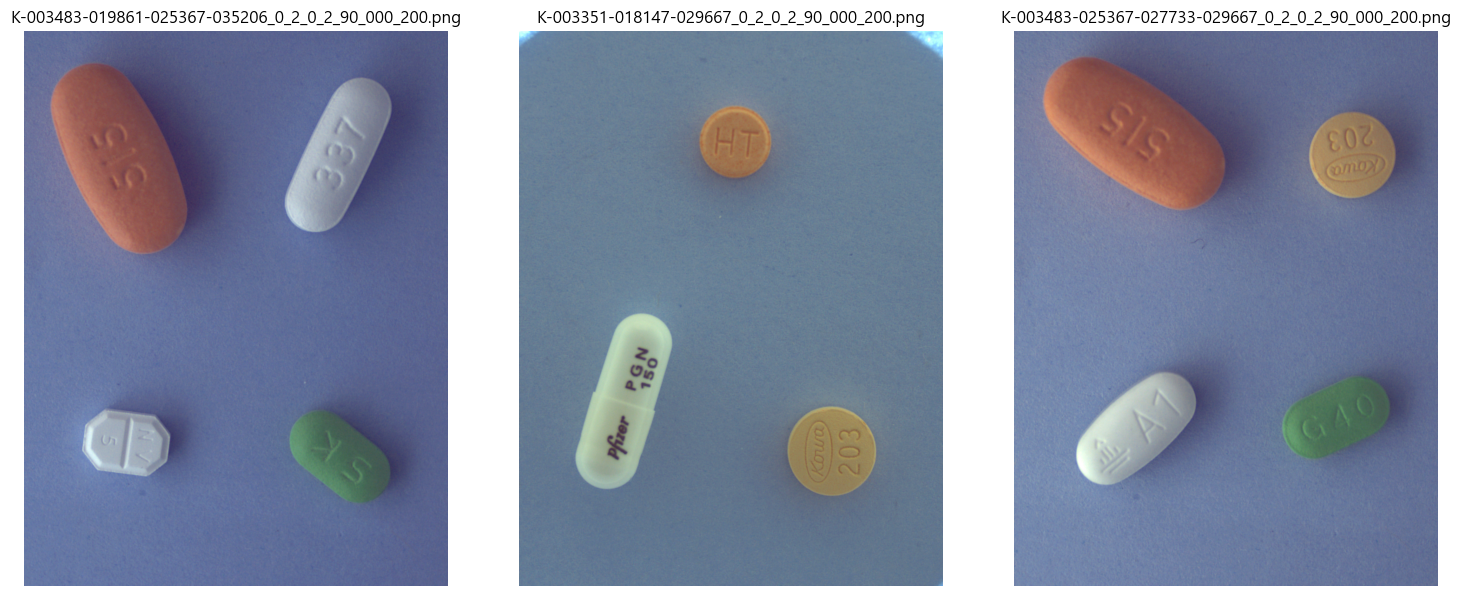

In [14]:
# 시각화할 이미지 파일 경로 목록 생성
# master_data의 키(파일 이름)들을 리스트로 가져온다
all_filenames = list(master_data.keys())

# 전체 파일 목록 중 3개를 랜덤으로 선택
if len(all_filenames) >= 3:
    sample_filenames = random.sample(all_filenames, 3)
else:
    # 파일이 3개 미만일 경우 전체 파일을 사용
    sample_filenames = all_filenames

# image_path를 재구성
sample_image_paths = [
    os.path.join(train_img_dir, filename) for filename in sample_filenames
]

# 이미지 로드 및 플로팅
plt.figure(figsize = (15, 6))
plot_index = 1

for i, img_path in enumerate(sample_image_paths):
    # OpenCV를 사용하여 이미지 로드
    img = cv2.imread(img_path)
    
    # 파일 로드 실패 검사 (안정성 확보)
    if img is None:
        print(f"파일 로드 실패 - '{img_path}'")
        continue

    # BGR -> RGB 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 서브플롯에 표시
    plt.subplot(1, 3, plot_index)
    plt.imshow(img_rgb)
    
    # 파일 이름에서 경로와 확장자 제거하여 제목으로 사용
    title = os.path.basename(img_path)
    plt.title(title, fontsize = 12)
    plt.axis('off')

    plot_index += 1

plt.tight_layout()
plt.savefig('random_sample_images.png')
plt.show()

약의 이미지를 실제로 시각화 해보았다

### 실제 BBox 확인

시각화 샘플 선정 완료: ['K-003351-019232-036637_0_2_0_2_75_000_200.png', 'K-003483-016232-020877-030308_0_2_0_2_90_000_200.png']
'bbox_visualization_samples.png' 파일로 시각화 결과 저장


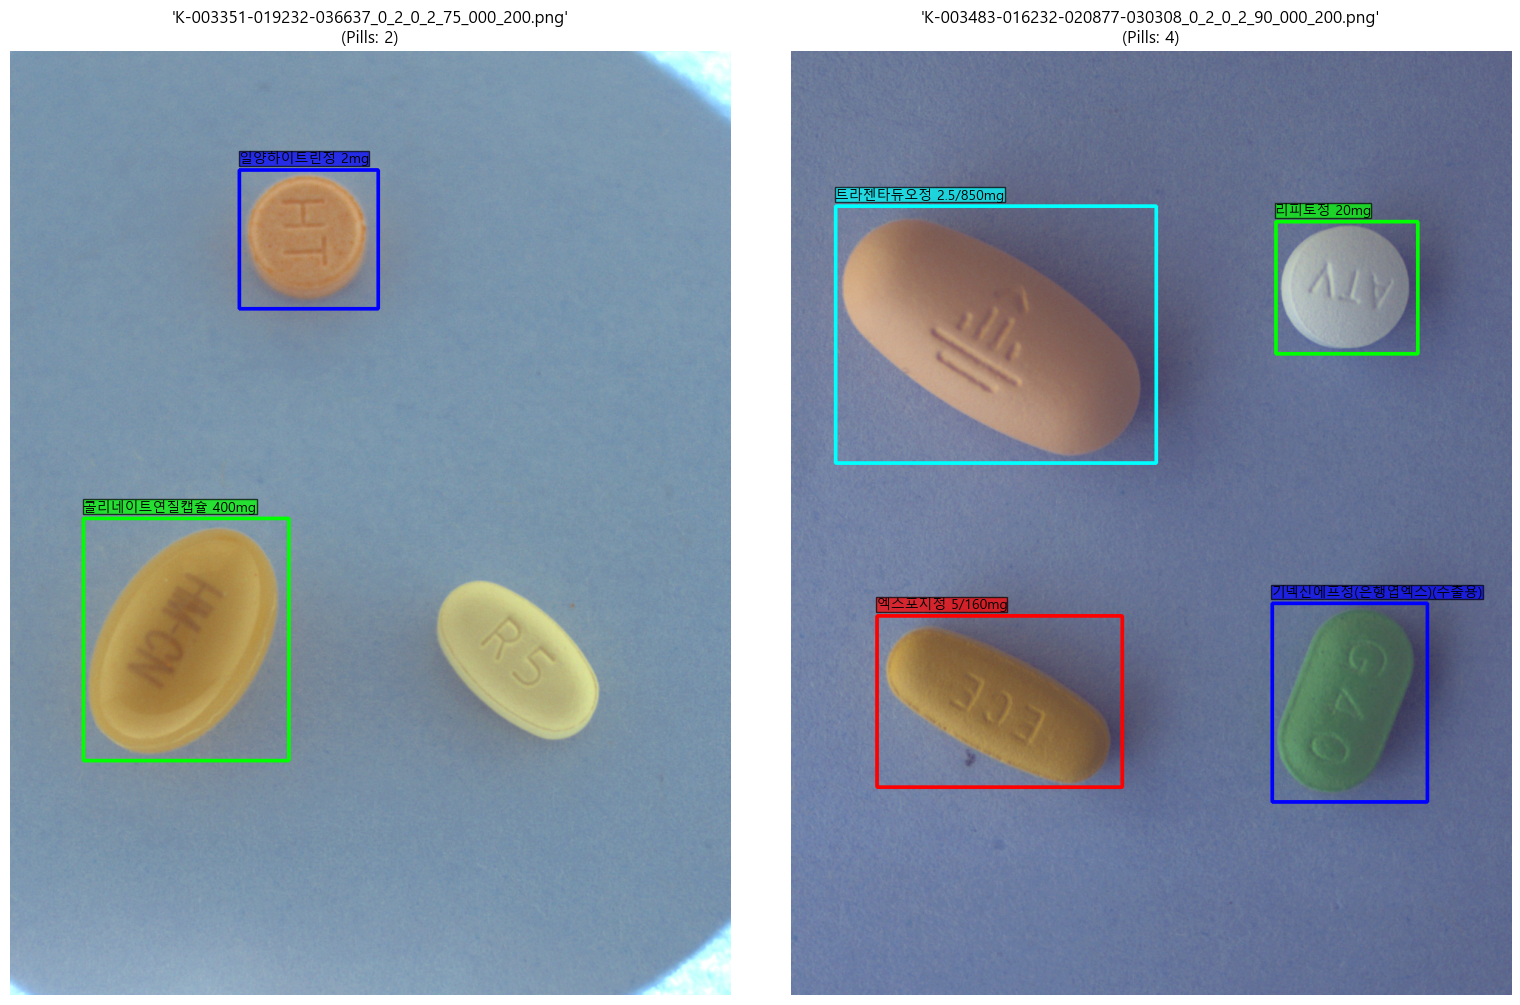

In [15]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# class_to_id의 key(이름)와 value(id)를 뒤집은 id_to_class 맵
id_to_class = {v: k for k, v in class_to_id.items()}

# 시각화할 샘플 이미지 선정
images_by_count = defaultdict(list)
for img_filename, data in master_data.items():
    pill_count = len(data['annotations'])
    if pill_count > 0:  # 어노테이션이 1개 이상 있는 이미지만
        images_by_count[pill_count].append(img_filename)

# 알약 2개짜리, 4개짜리 이미지 파일명을 랜덤으로 하나씩 선택
try:
    sample_2_pill = random.choice(images_by_count[2])
    sample_4_pill = random.choice(images_by_count[4])
    sample_filenames = [sample_2_pill, sample_4_pill]
    print(f"시각화 샘플 선정 완료: {sample_filenames}")
except Exception as e:
    print(f"샘플 선정 오류: {e}. (2개 또는 4개짜리 이미지가 없을 수 있음)")
    sample_filenames = random.sample(list(master_data.keys()), 2)  # 대안: 그냥 2개 랜덤

# BBox 시각화 및 저장
plt.figure(figsize=(16, 10))

# BBox 색상 (BGR)
COLORS = [
    (255, 0, 0),    # Blue
    (0, 255, 0),    # Green
    (0, 0, 255),    # Red
    (255, 255, 0)   # Yellow
]

for i, img_filename in enumerate(sample_filenames):
    img_path = os.path.join(train_img_dir, img_filename)

    # 이미지 로드 (BGR)
    image = cv2.imread(img_path)
    if image is None:
        print(f"오류: '{img_path}' 파일을 로드할 수 없음")
        continue

    annotations = master_data[img_filename]['annotations']

    # OpenCV에서 BGR로 박스 그리기
    for j, ann in enumerate(annotations):
        x, y, w, h = map(int, ann['bbox'])
        class_id = ann['class_id']
        class_name = id_to_class.get(class_id, "Unknown")

        color = COLORS[j % len(COLORS)]  # BGR
        cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness=3)

        # 텍스트는 matplotlib에서 RGB 색상으로 표시
        ann['class_name'] = class_name
        ann['color'] = (color[2]/255, color[1]/255, color[0]/255)  # RGB 변환

    # subplot에 표시
    plt.subplot(1, 2, i + 1)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(f"'{img_filename}'\n(Pills: {len(annotations)})", fontsize=12)
    plt.axis('off')

    # 텍스트 올리기
    for ann in annotations:
        x, y, w, h = map(int, ann['bbox'])
        plt.text(x, y - 10, ann['class_name'],
                 color='black',
                 fontsize=10,
                 bbox=dict(facecolor=ann['color'], alpha=0.7, pad=0.1))

plt.tight_layout()
output_filename = 'bbox_visualization_samples.png'
plt.savefig(output_filename)
print(f"'{output_filename}' 파일로 시각화 결과 저장")
plt.show()

BBox를 실제로 시각화를 해보았다

## 클래스 분석

### 클래스 분포 확인

총 4526개의 알약(= 바운딩 박스)
(전체 73개 클래스)
                  class_name  count
0         기넥신에프정(은행엽엑스)(수출용)    514
1                일양하이트린정 2mg    240
2                 보령부스파정 5mg    180
3                뮤테란캡슐 100mg    172
4                가바토파정 100mg    143
5              동아가바펜틴정 800mg    139
6               아토젯정 10/40mg    113
7                   리바로정 4mg    111
8                  리피토정 20mg    109
9               로수젯정10/5밀리그램    108
10                크레스토정 20mg    108
11         무코스타정(레바미피드)(비매품)     99
12                플라빅스정 75mg     97
13              트윈스타정 40/5mg     94
14         제미메트서방정 50/1000mg     88
15            자누메트정 50/850mg     88
16              트라젠타정(리나글립틴)     87
17                자누비아정 50mg     85
18     자누메트엑스알서방정 100/1000mg     85
19                 카나브정 60mg     84
20         트라젠타듀오정 2.5/850mg     81
21             엑스포지정 5/160mg     80
22              세비카정 10/40mg     79
23             아모잘탄정 5/100mg     76
24                 노바스크정 5mg     66
25           큐시드정 31.5mg/PTP 

C:\Users\daboi\AppData\Local\Temp\ipykernel_8532\4087164581.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


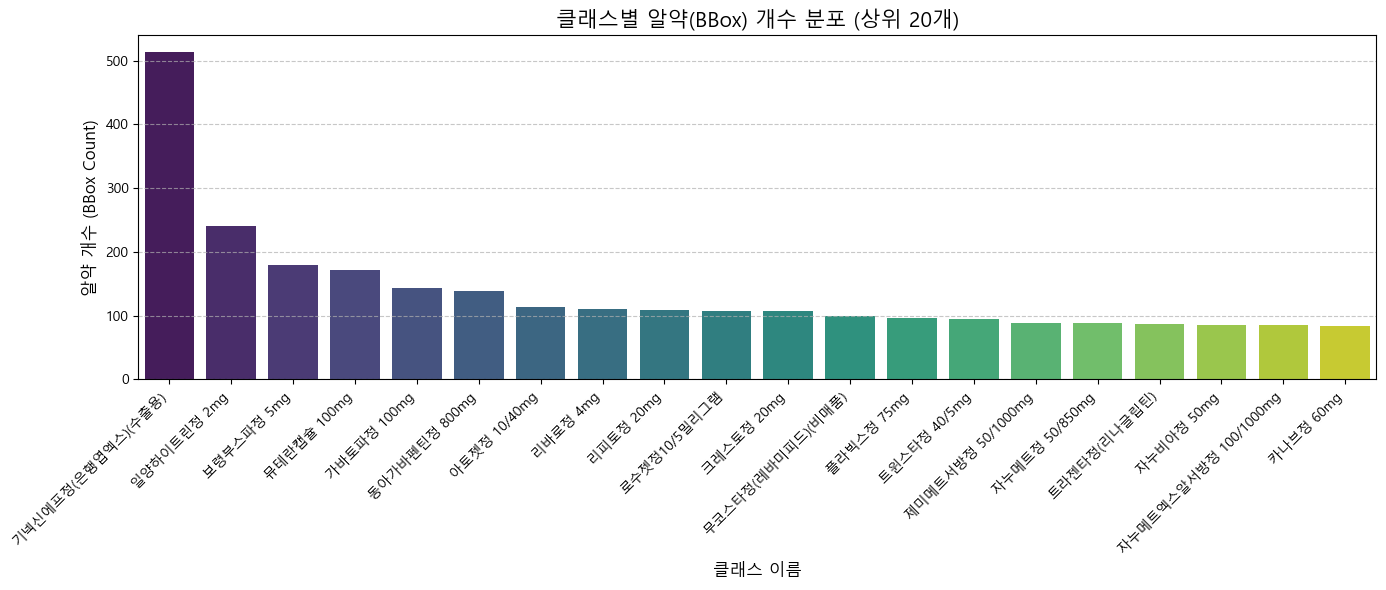

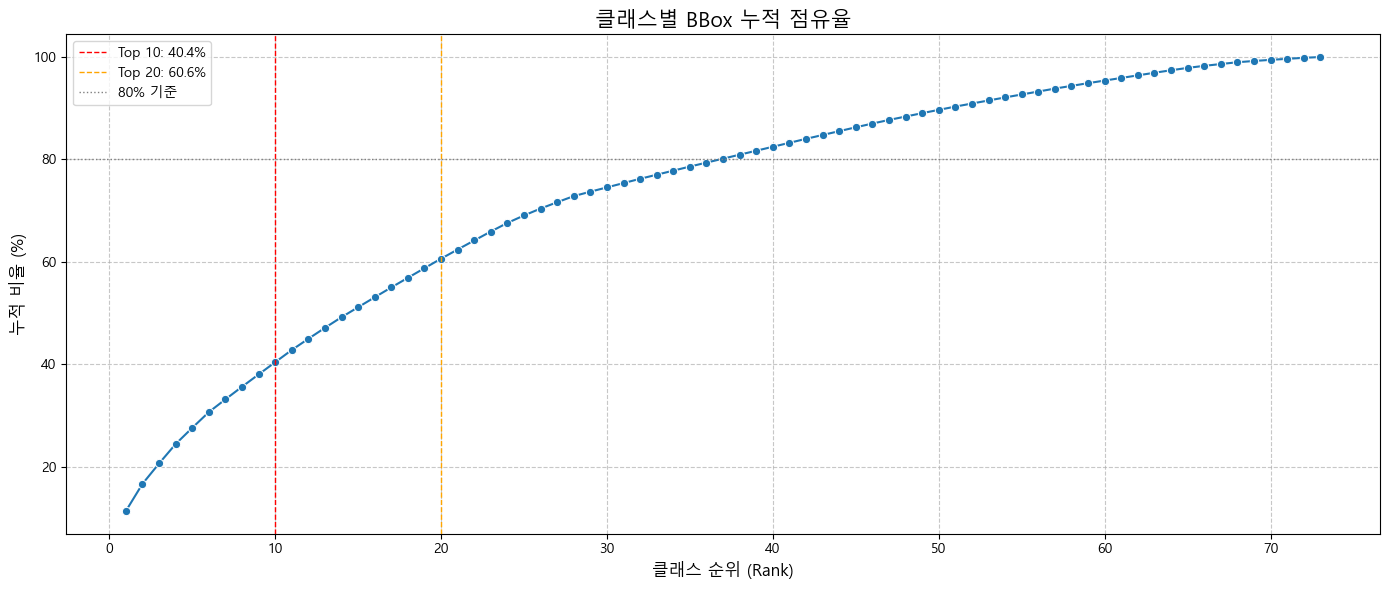

In [16]:
# master_data의 모든 'class_name'을 수집할 리스트
all_class_names = []
# 1489개 이미지를 순회하며, 각 이미지의 모든 BBox('annotations')에서 'class_name'을 추출해 리스트에 추가
for img_data in master_data.values():
    for ann in img_data['annotations']:
        all_class_names.append(ann['class_name'])

# 총 BBox 개수(4526개) 출력
print(f"총 {len(all_class_names)}개의 알약(= 바운딩 박스)")

# Counter를 사용해 'class_name'별 빈도수 계산
class_counts = Counter(all_class_names)

# (클래스명, 개수)를 DataFrame으로 변환
class_df = pd.DataFrame(class_counts.items(), columns = ['class_name', 'count'])
# 'count' (개수) 기준으로 내림차순 정렬
class_df = class_df.sort_values(by = 'count', ascending = False).reset_index(drop = True)

# 총 고유 클래스 개수(73개) 출력
print(f"(전체 {len(class_df)}개 클래스)")

# 전체 DataFrame (73개 클래스) 출력
print(class_df.to_string())

# 클래스 시각화
# 상위 20개 클래스만 시각화
TOP_N = 20

plt.figure(figsize = (14, 6))
# Seaborn 막대 그래프(barplot) 생성
sns.barplot(
    x = 'class_name', 
    y = 'count', 
    data = class_df.head(TOP_N), # 상위 20개 데이터만 사용
    palette = 'viridis' 
)
plt.title(f'클래스별 알약(BBox) 개수 분포 (상위 {TOP_N}개)', fontsize = 15)
plt.xlabel('클래스 이름', fontsize = 12)
plt.ylabel('알약 개수 (BBox Count)', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10) # X축 레이블 45도 회전
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.savefig('class_distribution_bar_plot_korean.png') # 그래프 파일로 저장
plt.show() # 그래프 출력


# 누적 분포 그래프 (Cumulative Distribution Plot)
# 전체 BBox 개수 합계 (4526)
total_bbox_count = class_df['count'].sum()
# 누적 개수 계산
class_df['cumulative_count'] = class_df['count'].cumsum()
# 누적 비율(%) 계산
class_df['cumulative_ratio'] = class_df['cumulative_count'] / total_bbox_count * 100

plt.figure(figsize = (14, 6))
# 누적 비율을 선 그래프(lineplot)로 표시
sns.lineplot(
    x = class_df.index + 1, # x축은 순위 (1~73)
    y = 'cumulative_ratio',
    data = class_df,
    marker = 'o'
)

# 상위 10위/20위 지점의 누적 비율 계산
top_10_ratio = class_df.iloc[min(9, len(class_df) - 1)]['cumulative_ratio']
top_20_ratio = class_df.iloc[min(19, len(class_df) - 1)]['cumulative_ratio']

# 그래프에 Top 10, Top 20, 80% 기준선(axvline, axhline) 추가
plt.axvline(x = 10, color = 'r', linestyle = '--', linewidth = 1, label = f'Top 10: {top_10_ratio:.1f}%')
plt.axvline(x = 20, color = 'orange', linestyle = '--', linewidth = 1, label = f'Top 20: {top_20_ratio:.1f}%')
plt.axhline(y = 80, color = 'gray', linestyle = ':', linewidth = 1, label = '80% 기준')

plt.title('클래스별 BBox 누적 점유율', fontsize = 15)
plt.xlabel('클래스 순위 (Rank)', fontsize = 12)
plt.ylabel('누적 비율 (%)', fontsize = 12)
plt.grid(linestyle = '--', alpha = 0.7)
plt.legend() # 범례 표시
plt.tight_layout()
plt.savefig('class_cumulative_distribution_plot_korean.png') # 그래프 파일로 저장
plt.show() # 그래프 출력

- 클래스 불균형이 심각한 것 같다
- 최다 클래스: '기넥신에프정(은행엽엑스)(수출용)' (514개, 전체의 11.4%)
- 최소 클래스: '브린텔릭스정 20mg' (7개, 전체의 0.15%)
- 상위 10개 클래스만 해도 40%는 넘는다
- 분할을 할 때 희귀한 알약들을 그나마 최대한 학습과 테스트에 나눠질 수 있도록 분할을 하는게 좋을 것 같다 stratified split (클래스 비율 유지)를 고려해본다
- 데이터 증강을 고려해본다(이전 미션 때 데이터가 이거보다 더 적은 미션을 한적이 있었는데 오히려 과한 증강이 해가된적은 있었다)
- 클래스 가중치를 조절해주는 방법들을 고려해본다
    - Oversampling or Undersampling or WeightedRandomSampler
    - 소수 클래스(예를 들면 50개 이하)는 강하게 증강
    - 클래스 그룹화(극도로 적은 클래스(예: 10개 미만)는 초반에는 묶어서 학습 후, 후반에 세분화)
    - 손실 함수에서 소수 클래스에 더 큰 가중치를 부여
        - Focal Loss
        - Class Weightd Loss
    - 앙상블 기법 (Ensemble Methods)
    - Two stage 학습
    - 이외에도 여러 기법을 고려해본다
    - 모델에 따라서 적용할 수 있는 방법이 달라질 수도 있을 것 같다

### 클래스별 고유값 확인

In [17]:
# 분석 대상 메타데이터 속성
TARGET_PROPERTIES = ['drug_shape', 'color_class1', 'print_front', 'print_back', 'dl_company_en']

# 클래스별 속성값 저장을 위한 딕셔너리
# Key: 클래스 이름 (dl_name), Value: {속성: [값1, 값2, ...]}
class_metadata_agg = defaultdict(lambda: {prop: [] for prop in TARGET_PROPERTIES})

for json_path in tqdm(json_files, desc = "Processing JSON metadata"):
    try:
        with open(json_path, 'r', encoding = 'utf-8') as f:
            data = json.load(f)
        # 'images' 섹션의 메타데이터 추출
        if not data['images']:
            continue

        img_info = data['images'][0]
        
        # 클래스 이름 추출 (dl_name이 실제 알약 이름)
        class_name = img_info.get('dl_name')
        if not class_name:
            continue
            
        # 각 속성값 추출 및 저장
        for prop in TARGET_PROPERTIES:
            value = img_info.get(prop)
            if value is not None:
                class_metadata_agg[class_name][prop].append(value)
                
    except Exception as e:
        # print(f"Error processing {json_path}: {e}")
        continue

# 클래스별 메타데이터 고유값 카운트 분석
analysis_records = []
# class_metadata_agg에 집계된 73개 클래스 순회
for class_name, props in class_metadata_agg.items():
    record = {'class_name': class_name} # 현재 클래스의 분석 결과를 저장할 딕셔너리
    
    # 'drug_shape', 'color_class1' 등 5개 속성 순회
    for prop, values in props.items():
        # 해당 속성의 '고유값 개수' 계산
        # (예: 'drug_shape' 리스트가 ['원형', '원형']이면 set{'원형'}의 길이는 1)
        record[f'unique_{prop}_count'] = len(set(values))
    
    # 해당 클래스가 전체 데이터셋에서 몇 번 등장했는지 (BBox가 아닌 JSON 파일 수 기준)
    record['json_count'] = len(props['drug_shape']) # 모든 JSON 파일은 drug_shape을 가질 것이므로 이를 기준으로 카운트
    analysis_records.append(record)

# DataFrame으로 변환
metadata_df = pd.DataFrame(analysis_records)

# 클래스 등장 횟수(json_count) 기준으로 내림차순 정렬
metadata_df = metadata_df.sort_values(by = 'json_count', ascending = False)

# 결과 출력 (상위 10개만 예시로 출력)
print("\n")
print("클래스별 메타데이터 고유값 개수 (상위 10개)")
print(metadata_df.head(10).to_string())

# 전체 클래스 메타데이터 분석 결과 CSV 저장 (전체 분석을 위해)
metadata_df.to_csv('class_metadata_uniqueness_analysis.csv', index = False, encoding = 'utf-8')
print("\n'class_metadata_uniqueness_analysis.csv' 파일 저장")

Processing JSON metadata: 100%|██████████| 4526/4526 [00:00<00:00, 12107.75it/s]




클래스별 메타데이터 고유값 개수 (상위 10개)
            class_name  unique_drug_shape_count  unique_color_class1_count  unique_print_front_count  unique_print_back_count  unique_dl_company_en_count  json_count
50  기넥신에프정(은행엽엑스)(수출용)                        1                          1                         1                        1                           1         514
29         일양하이트린정 2mg                        1                          1                         1                        1                           1         240
0           보령부스파정 5mg                        1                          1                         1                        1                           1         180
15         뮤테란캡슐 100mg                        1                          1                         1                        1                           1         172
1        동아가바펜틴정 800mg                        1                          1                         1                        1                

- class_name = 알약의 정식 명칭 (예: '스토가정 10mg')
- unique_drug_shape_count = 해당 알약이 데이터셋 내에서 가진 모양의 고유한 개수
- unique_color_class1_count	= 해당 알약의 주 색상의 고유한 개수
- unique_print_front_count = 알약 앞면에 인쇄된 문자/숫자의 고유한 개수
- unique_print_back_count = 알약 뒷면에 인쇄된 문자/숫자의 고유한 개수
- unique_dl_company_en_count = 알약을 제조한 회사 이름(영문)의 고유한 개수
- json_count = 해당 클래스를 포함하고 있는 JSON 어노테이션 파일의 총 개수(BBox 개수와 같다)

- 클래스 모두에서 모양, 색상, 각인, 제조사 속성의 고유값 개수가 1로 나타났다
- 클래스 내부의 데이터 일관성은 문제가 없는 것 같다

### 클래스별 색상 모양 확인

In [18]:
# 색상/모양 고정 클래스 비율 계산
print("데이터셋의 색상/모양 고정 클래스 비율")

total_classes = len(metadata_df)

# 모양(Shape)이 고정된 클래스 수
fixed_shape_count = len(metadata_df[metadata_df['unique_drug_shape_count'] == 1])
fixed_shape_ratio = fixed_shape_count / total_classes * 100

# 색상(Color)이 고정된 클래스 수
fixed_color_count = len(metadata_df[metadata_df['unique_color_class1_count'] == 1])
fixed_color_ratio = fixed_color_count / total_classes * 100

print(f"총 클래스 수: {total_classes}개")
print(f"- 모양(drug_shape)이 1개인 클래스: {fixed_shape_count}개 ({fixed_shape_ratio:.1f}%)")
print(f"- 색상(color_class1)이 1개인 클래스: {fixed_color_count}개 ({fixed_color_ratio:.1f}%)")

데이터셋의 색상/모양 고정 클래스 비율
총 클래스 수: 73개
- 모양(drug_shape)이 1개인 클래스: 72개 (98.6%)
- 색상(color_class1)이 1개인 클래스: 72개 (98.6%)


- 72개 클래스가 단 하나의 고유한 모양과 고유한 색상을 가진다
- 모델이 색상이나 모양만 보고 학습을 할 수 있을 것 같다
- 과적합이 우려된다 데이터 증강은 강하게 해줘야 될 것 같다
    - Color Jittering은 적극적으로 사용한다
    - 회전이나 원근 등 기하학적인 변환도 적극 사용한다(그림자 차이도 조금이라도 있을까 생각이 된다)
- 저 1개는 고유한 모양과 색상이 아닌 1개 이상의 모양과 색상을 가지는 것 같다 이상하니 한번 확인을 해본다

#### 클래스 이상치 확인

In [19]:
# 클래스 이상치 확인
# metadata_df에서 'unique_drug_shape_count'가 1이 아니거나,
# 'unique_color_class1_count'가 1이 아닌 클래스(행)를 필터링
variant_classes_df = metadata_df[
    (metadata_df['unique_drug_shape_count'] != 1) | 
    (metadata_df['unique_color_class1_count'] != 1)
]

print(f"이상 클래스: {len(variant_classes_df)}개")
print(variant_classes_df[['class_name', 'json_count', 'unique_drug_shape_count', 'unique_color_class1_count']].to_string())

이상 클래스: 1개
    class_name  json_count  unique_drug_shape_count  unique_color_class1_count
4  가바토파정 100mg           0                        0                          0


- 가비토정은 모양이나 색상 정보가 아예 없다 메타데이터가 누락됐다
- 그런데 이 약은 143개나 있다
- BBox와 class id는 있어서 모델 학습은 가능하겠으나 이 정보를 활용하는 EDA 분석은 할 수 없을 것 같다

### 클래스별 인쇄 패턴 확인

In [20]:
# 데이터의 다양성 인쇄 내용이 2가지 이상인 클래스 필터링
print("2가지 이상 인쇄 패턴을 가진 클래스")

# metadata_df에서 'unique_print_front_count'가 1보다 크거나 (앞면 각인이 2개 이상)
# 'unique_print_back_count'가 1보다 큰 (뒷면 각인이 2개 이상) 클래스를 필터링
diverse_print_df = metadata_df[
    (metadata_df['unique_print_front_count'] > 1) | 
    (metadata_df['unique_print_back_count'] > 1)
]

# 결과 출력
print(f"총 {len(diverse_print_df)}개의 클래스가 다양한 인쇄 패턴이 있음")
print(diverse_print_df[['class_name', 'json_count', 'unique_print_front_count', 'unique_print_back_count']].head(5).to_string())

2가지 이상 인쇄 패턴을 가진 클래스
총 0개의 클래스가 다양한 인쇄 패턴이 있음
Empty DataFrame
Columns: [class_name, json_count, unique_print_front_count, unique_print_back_count]
Index: []


- 73개의 클래스는 100% 똑같은 인쇄 내용을 가진다(예: 앞에는 100% LIP20 뒤에는 100% 화이자라 적혀있다)
- 모양과 색상이 아니라 약에 인쇄된 패턴을 봐도 패턴 자체를 외워버릴 가능성이 높을 것 같다
- 강력한 랜덤 회전과 블러 그리고 노이즈를 증강으로 적용해서 글자의 특징을 학습하는걸 고려해본다

#### 인쇄 오류 확인

In [21]:
# 인쇄 확인
# DataFrame으로 변환
metadata_all_pills_df = pd.DataFrame(all_metadata_records)
print(f"\n'metadata_all_pills_df' 생성 완료. (총 {len(metadata_all_pills_df)}개 레코드)")

# 메타데이터 논리 오류 탐색
# 데이터 준비
df = metadata_all_pills_df.copy()

# 'print_front', 'print_back', 'line_front', 'line_back'의 NaN을 빈 문자열('')로 대체
print_cols = ['print_front', 'print_back', 'line_front', 'line_back']
for col in print_cols:
    df[col] = df[col].fillna('')

# 논리 오류 조건 정의
# "앞면" 사진인데, '앞면 각인/줄'은 없고 '뒷면 각인/줄' 정보만 있음
cond1_dir = df['drug_dir'] == '앞면'
cond1_front_empty = (df['print_front'] == '') & (df['line_front'] == '')
cond1_back_filled = (df['print_back'] != '') | (df['line_back'] != '')

contradiction1 = df[cond1_dir & cond1_front_empty & cond1_back_filled]

# "뒷면" 사진인데, '뒷면 각인/줄'은 없고 '앞면 각인/줄' 정보만 있음
cond2_dir = df['drug_dir'] == '뒷면'
cond2_front_filled = (df['print_front'] != '') | (df['line_front'] != '')
cond2_back_empty = (df['print_back'] == '') & (df['line_back'] == '')

contradiction2 = df[cond2_dir & cond2_front_filled & cond2_back_empty]

# 결과 집계 및 출력
print("\n" + "="*70)
print("메타데이터 논리 오류 탐색 결과")
print("'앞면' 사진인데 '뒷면' 정보만 있는 경우: {:,} 건".format(len(contradiction1)))
print("'뒷면' 사진인데 '앞면' 정보만 있는 경우: {:,} 건".format(len(contradiction2)))

total_contradictions = len(contradiction1) + len(contradiction2)
print(f"총 {total_contradictions:,} 건의 논리적 모순 데이터 발견")

if total_contradictions > 0:
    # .drop_duplicates()를 제거하여 리스트 타입 컬럼 문제 해결
    all_contradictions_df = pd.concat([contradiction1, contradiction2])
    
    print("\n" + "="*70)
    print("논리 오류가 가장 많이 발생한 클래스:")
    # 'dl_name' (클래스 이름) 기준으로 카운트
    print(all_contradictions_df['dl_name'].value_counts().to_string())
    
    print("\n" + "="*70)
    print("논리 오류가 발생한 이미지 파일:")
    # 'file_name' (이미지 파일) 기준으로 카운트
    print(all_contradictions_df['file_name'].value_counts().to_string())

else:
    print("\n논리적 모순 데이터 없음")


'metadata_all_pills_df' 생성 완료. (총 4526개 레코드)

메타데이터 논리 오류 탐색 결과
'앞면' 사진인데 '뒷면' 정보만 있는 경우: 21 건
'뒷면' 사진인데 '앞면' 정보만 있는 경우: 2 건
총 23 건의 논리적 모순 데이터 발견

논리 오류가 가장 많이 발생한 클래스:
dl_name
글리틴정(콜린알포세레이트)     21
콜리네이트연질캡슐 400mg     2

논리 오류가 발생한 이미지 파일:
file_name
K-003351-016232-033880_0_2_0_2_75_000_200.png    1
K-003351-016232-033880_0_2_0_2_90_000_200.png    1
K-003351-016262-033880_0_2_0_2_70_000_200.png    1
K-003351-016262-033880_0_2_0_2_75_000_200.png    1
K-003351-016262-033880_0_2_0_2_90_000_200.png    1
K-003351-020238-033880_0_2_0_2_75_000_200.png    1
K-003351-020238-033880_0_2_0_2_90_000_200.png    1
K-003351-021325-033880_0_2_0_2_70_000_200.png    1
K-003351-021325-033880_0_2_0_2_75_000_200.png    1
K-003351-021325-033880_0_2_0_2_90_000_200.png    1
K-003351-022074-033880_0_2_0_2_70_000_200.png    1
K-003351-022074-033880_0_2_0_2_75_000_200.png    1
K-003351-022074-033880_0_2_0_2_90_000_200.png    1
K-003351-029667-033880_0_2_0_2_70_000_200.png    1
K-003351-029667-033880_0_2_0_2_75

- 23개는 라벨링이 제대로 되지 않은 것 같다
- 역시 부가정보인 메타 데이터라서 이미지를 보고 학습할 때는 문제가 되지 않을 것 같다

### 클래스별 이미지 안에서의 중복 확인

In [22]:
# 이미지 안에서 알약 중복 확인
# any()는 하나라도 True가 있으면 True를 반환
has_duplicates = any(
    # 한 이미지의 어노테이션 리스트(예: ['A', 'B', 'C'])의 길이(3)와
    len([ann['class_name'] for ann in img_data['annotations']]) != 
    # 해당 리스트를 set으로 변환(예: {'A', 'B', 'C'})한 길이(3)가 다른지 비교
    # 만약 중복(예: ['A', 'B', 'B'])이 있다면, list 길이(3) != set 길이(2)가 되어 True 반환
    len(set(ann['class_name'] for ann in img_data['annotations']))
    # 1489개의 모든 이미지를 순회
    for img_data in master_data.values()
)

print("한 이미지 내 동일 클래스 중복 존재:", "없음" if not has_duplicates else "있음")

한 이미지 내 동일 클래스 중복 존재: 없음


- 한 이미지 내에서 똑같은 클래스가 나오는 경우는 없다
- 실제 환경에서는 동일한 알약이 여러 개 동시에 놓이는 경우가 많을 것 같은데 YOLO의 Mosaic + Copy-Paste를 고려해본다
    - Mosaic Augmentation: YOLO의 기본 Mosaic 증강은 4개의 이미지를 조합하므로 서로 다른 이미지에 있던 동일 클래스(예: 1번 이미지의 'A'와 2번 이미지의 'A')가 한 프레임에 모일 수 있다
    - Copy-Paste Augmentation: 더 적극적인 방법이다 특정 알약의 BBox 안을 복사하여 동일한 이미지의 다른 위치에 붙여넣기 하는 Copy-Paste 증강을 적용하는 것을 강력히 고려한다 모델이 동일 객체를 여러 번 탐지하도록 강제하는 효과적인 훈련 방법이다

### 클래스별 이미지 안에서의 개수 분포 확인

C:\Users\daboi\AppData\Local\Temp\ipykernel_8532\2225168115.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


이미지당 알약 개수 분포
   pill_count  image_count
0           1           64
1           2          302
2           3          634
3           4          489


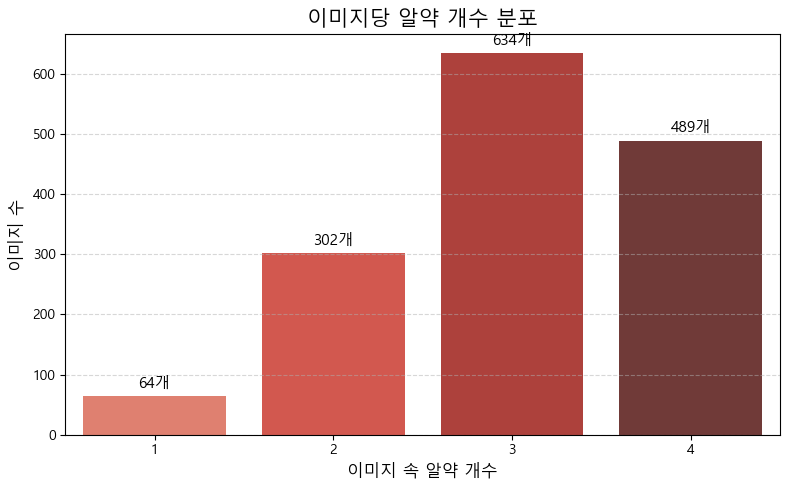

In [23]:
# master_data에서 이미지별 알약 개수(ann_count)를 뽑아 리스트로 만든다
ann_counts_list = []
for img_data in master_data.values():
    ann_counts_list.append(len(img_data['annotations']))

# 개수별로 카운트
count_distribution = Counter(ann_counts_list)

# DataFrame으로 변환
count_df = pd.DataFrame(count_distribution.items(), columns = ['pill_count', 'image_count'])
# 'pill_count' (알약 개수) 기준으로 오름차순 정렬
count_df = count_df.sort_values(by = 'pill_count', ascending = True).reset_index(drop = True)

print("이미지당 알약 개수 분포")
print(count_df.to_string())

# 시각화 (Bar Plot)
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='pill_count', 
    y='image_count', 
    data=count_df, 
    palette='Reds_d'
)

# 각 막대 위에 이미지 개수 텍스트 추가
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}개", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 11)

plt.title('이미지당 알약 개수 분포', fontsize = 15)
plt.xlabel('이미지 속 알약 개수', fontsize = 12)
plt.ylabel('이미지 수', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.savefig('pill_count_distribution_bar_plot_clean.png')
plt.show()

- 이미지당 최대 4개의 이미지가 있다
- 대부분 이미지당(약 75%) 3 - 4개의 알약이 있다
    - 객체들이 서로 겹쳐져 있을 수도 있어서 NMS (Non-Maximum Suppression) 임계값이 중요할 수도 있다 임계값이 너무 낮으면 겹쳐진 정상 알약을 제거할 수 있고, 너무 높으면 중복 탐지를 제거하지 못할 수 있는걸 유의한다
    - 다양한 알약들이 있을테니 다양한 크기의 물체를 동시에 잘 탐지하기 위해 FPN을 사용해볼 수도 있겠다
- 눈으로 대충 봤을 때 1 - 2개짜리는 없었던 것 같다 더 자세히 확인을 해본다

#### 파일명 기준 이미지별 알약 개수 분포

In [24]:
# 'K-ID' 개수를 저장할 리스트
true_counts_list = []
# 'K-ID' 패턴이 아닌 파일명을 저장할 리스트
filenames_without_k_ids = []

# master_data의 1,489개 이미지 파일명을 모두 순회
for img_filename in master_data.keys():
    
    try:
        # 파일명에서 "True Count"를 파싱
        
        # '_'를 기준으로 앞부분만 추출
        # 예: 'K-001900-016548-018110-027926'
        base_name = img_filename.split('_')[0]
        
        # 'K-' ID 패턴인지 확인
        if not base_name.startswith('K-'):
            filenames_without_k_ids.append(img_filename)
            continue # K-ID 파일이 아니면 건너뜀

        # '-'를 기준으로 K-ID들을 분리
        # 예: ['K', '001900', '016548', '018110', '027926']
        k_parts = base_name.split('-')
        
        # 'K'를 제외한 ID 개수 (예: 5 - 1 = 4)
        true_count = len(k_parts) - 1
        
        true_counts_list.append(true_count)
        
    except Exception as e:
        # 혹시 모를 파싱 오류
        print(f"파싱 오류 발생: {img_filename}, 오류: {e}")

# "True Count"의 분포를 집계한다
if true_counts_list:
    # Counter를 사용해 개수별 빈도 계산
    count_distribution = Counter(true_counts_list)
    
    # DataFrame으로 변환
    count_df = pd.DataFrame(count_distribution.items(), 
                            columns=['알약 개수 (파일명 기준)', '이미지 수'])
    count_df = count_df.sort_values(by='알약 개수 (파일명 기준)').reset_index(drop=True)
    
    print("\n" + "="*50)
    print("파일명(True Count) 기준, 이미지별 알약 개수 분포")
    print("="*50)
    print(count_df.to_string(index=False))
else:
    print("\n[코드 검증 결과]")
    print("K-ID 패턴을 가진 이미지 파일을 찾을 수 없습니다.")

if filenames_without_k_ids:
    print("\n" + "="*50)
    print(f"참고: {len(filenames_without_k_ids)}개 파일은 K-ID 패턴이 아님")
    # 예시 5개만 출력
    print(filenames_without_k_ids[:5])


파일명(True Count) 기준, 이미지별 알약 개수 분포
 알약 개수 (파일명 기준)  이미지 수
              3    294
              4   1195


- 1489개의 이미지에서 이미지당 알약 개수가 무조건 3 - 4개인건 확실해 보인다
- 그런데 위에선 1 - 2개짜리가 있다고 했다 레이블이 누락된 것 같다

#### 클린셋 & 오류셋 확인

In [25]:
# 결과를 저장할 리스트
error_records = []
clean_files = []
missing_label_files = []

# master_data의 모든 이미지를 검사 (1489개)
for img_filename, data in master_data.items():
    
    # 1. 파일명에서 "True Count" 파싱
    # 'K-001900-016548-018110-027926_0_...png'
    
    # '_'를 기준으로 앞부분만 추출
    base_name = img_filename.split('_')[0] 
    # 'K-001900-016548-018110-027926'
    
    # '-'를 기준으로 K-ID들을 분리
    k_parts = base_name.split('-')
    # ['K', '001900', '016548', '018110', '027926']
    
    # 'K'를 제외한 ID 개수
    true_count = len(k_parts) - 1 
    
    # 2. 어노테이션에서 "Annotation Count" 파악
    annotation_count = len(data['annotations'])

    # 3. 두 개수 비교
    if true_count == annotation_count:
        # 두 개수가 일치 = 완벽한 데이터
        clean_files.append(img_filename)
        
    else:
        # 두 개수가 불일치 = 오류 데이터
        error_records.append({
            'filename': img_filename,
            'true_count': true_count,          # 파일명 기준 개수
            'annotation_count': annotation_count # JSON 기준 개수
        })
        
        if annotation_count < true_count:
            # 발견한 "레이블 누락" (예: 파일명 4개, 어노테이션 1개)
            missing_label_files.append(img_filename)
        # else:
            # (만약 있다면) 어노테이션이 더 많은 경우

# 결과 분석
print(f"총 {len(master_data)}개 이미지 검사 완료\n")
print("="*50)
print(f"[클린셋] 개수 일치: {len(clean_files)}개")
print(f"[오류셋] 개수 불일치: {len(error_records)}개")
print("="*50)

if error_records:
    # 오류 상세 내용 (상위 20개)
    error_df = pd.DataFrame(error_records)
    print("\n[오류 상세 내역 (개수 불일치 Top 20)]")
    print(error_df.head(20).to_string())
    
    # 오류 유형별 집계
    print("\n[오류 유형별 집계]")
    print(error_df.groupby(['true_count', 'annotation_count']).size())

총 1489개 이미지 검사 완료

[클린셋] 개수 일치: 639개
[오류셋] 개수 불일치: 850개

[오류 상세 내역 (개수 불일치 Top 20)]
                                                filename  true_count  annotation_count
0   K-001900-010224-016551-031705_0_2_0_2_70_000_200.png           4                 3
1   K-001900-010224-016551-031705_0_2_0_2_75_000_200.png           4                 2
2   K-001900-010224-016551-031705_0_2_0_2_90_000_200.png           4                 3
3   K-001900-010224-016551-033009_0_2_0_2_70_000_200.png           4                 2
4   K-001900-010224-016551-033009_0_2_0_2_75_000_200.png           4                 2
5   K-001900-010224-016551-033009_0_2_0_2_90_000_200.png           4                 3
6   K-001900-016548-018110-021026_0_2_0_2_90_000_200.png           4                 2
7   K-001900-016548-018110-027926_0_2_0_2_70_000_200.png           4                 3
8   K-001900-016548-018110-027926_0_2_0_2_90_000_200.png           4                 3
9   K-001900-016548-018110-029345_0_2_0_2_75_0

- 1489개의 전체 학습 데이터 중 850개가 파일명에 명시된 개수보다 적은 수의 어노테이션을 가진 오류셋임을 최종 확인했다
- 이 850개의 오류셋을 그대로 학습에 사용한다면 모델은 4개의 알약이 보여도 3개만 탐지하라는 잘못된 정보를 학습하게 될 수 있다
- 원래도 데이터가 많은 느낌은 아니었는데 거의 절반을 못쓰게 되었다
- 학습을 할 때 무조건 오류셋은 놔두고 학습을 한다

클린셋 639개 기반 의사 레이블링 계획
- 1단계: "클린셋" 분리 및 "베이스라인" 모델 학습
    - 데이터 분리: 
        - 전체 1,489개 이미지를 2개 그룹으로 분리
        - "클린셋" (Clean Set): 639개 (파일명 개수 == 어노테이션 개수인 완벽한 데이터)
        - "오류셋" (Error Set): 850개 (파일명 개수 != 어노테이션 개수인 "레이블 누락" 데이터)
        - 검증셋 구성: "클린셋" (639개) 안에서만 8:2 등으로 훈련/검증 데이터 분리
        - 예: train_clean (약 575개) / val_clean (약 64개)
        - "베이스라인" 모델 학습: train_clean (575개) 데이터로만 베이스라인 모델을 학습시킴
        - 데이터가 639개뿐이므로 과적합 위험이 매우 높음 Copy-Paste, Mosaic 등 강력한 데이터 증강(Augmentation)이 필요할 수 있음

- 2단계: "오류셋" 예측 및 레이블 필터링
    - 예측: 
        - 1단계에서 학습시킨 "베이스라인 모델"을 "오류셋" 850장 이미지에 대해 실행시킴
        
- 3단계: 의사 레이블링
    - 목표: "오류셋"(850개) 의사 레이블링

- 4단계: "최종" 모델 재학습
    - 최종 데이터셋 구성:
        - train_clean (약 575개) + fixed_error_set (850개)
        - 최종 모델 학습:
            - 보강된 전체 학습 데이터(약 1425개)를 사용하여 모델을 처음부터 다시 학습시킴
            - 이 최종 모델은 베이스라인 모델보다 훨씬 많은(수리된) 데이터를 학습했으므로 더 높은 성능을 기대할 수 있다

#### 이미지당 알약 개수 vs BBox 크기 재확인

C:\Users\daboi\AppData\Local\Temp\ipykernel_8532\414618382.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


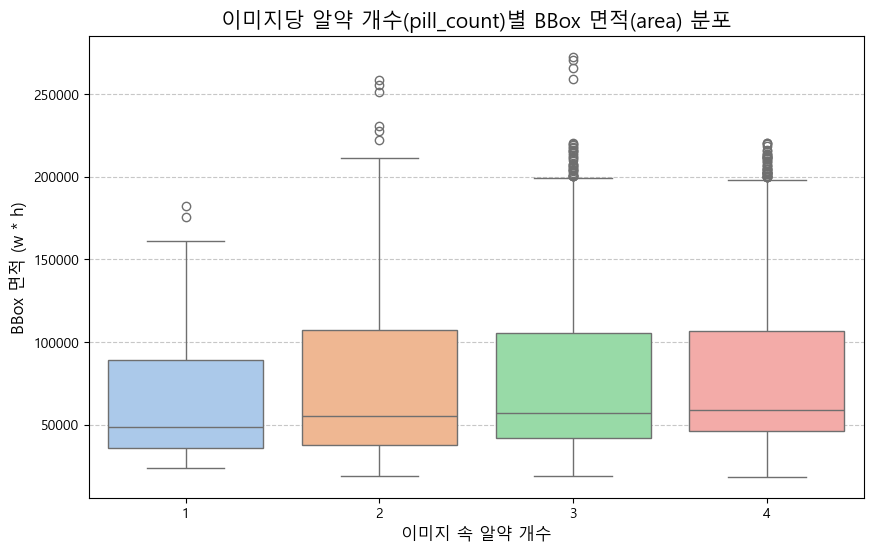

In [26]:
# master_data에서 모든 BBox 정보를 수집
all_bboxes_data = []
ann_counts_map = {}

for img_filename, img_data in master_data.items():
    
    # 이미지당 알약 개수 미리 계산
    pill_count = len(img_data['annotations'])
    ann_counts_map[img_filename] = pill_count
    
    for ann in img_data['annotations']:
        x, y, w, h = ann['bbox']
        
        # BBox 속성 계산 및 리스트에 추가
        all_bboxes_data.append({
            'filename': img_filename,
            'class_name': ann['class_name'],
            'w': w,
            'h': h,
            'area': w * h,
            'x_center': x + w / 2,
            'y_center': y + h / 2,
        })

# DataFrame으로 변환
bbox_df = pd.DataFrame(all_bboxes_data)
# 이미지당 알약 개수 (pill_count) 정보 추가
bbox_df['pill_count'] = bbox_df['filename'].map(ann_counts_map)

plt.figure(figsize = (10, 6))
sns.boxplot(
    x='pill_count', 
    y='area', 
    data=bbox_df,
    palette='pastel' 
)
plt.title('이미지당 알약 개수(pill_count)별 BBox 면적(area) 분포', fontsize = 15)
plt.xlabel('이미지 속 알약 개수', fontsize = 12)
plt.ylabel('BBox 면적 (w * h)', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.savefig('pill_count_vs_area_boxplot.png')

- 원래 직관대로라면 이미지에 알약이 4개나 있으면 BBox가 줄어들거라 생각되지만(줌아웃을 하거나 작은약만 넣어야 될 수 있으니) 2 3 4개일 때의 중앙값과 분포가 거의 동일하다
- 데이터셋이 매우 엄격하게 통제된 환경에서 촬영이 된 것 같다
- 2 3 4개일때 모두 완전히 동일한 조건에서 찍혔다고 봐도 되는데 아까 2개가 있는 이미지는 없다고 했었다 그런데 모든 환경이 거의 똑같은데 BBox 크기가 똑같다는건 알약의 물리적인 크기 자체가 같다는 것 같다 다른점은 어노테이션의 개수 밖에 없는 것 같다
- 1개짜리도 아까 없다는걸 확인했다 그런데 분포가 아래쪽에 있다 이 64개는 다른 약들보다 더 작은 약들일 것이다
- 알약 개수에 따른 BBox 크기 편향은 없다고 봐도 될 것 같다

## 이미지 분석

### 이미지 크기 확인

In [27]:
# 이미지 속성 분석 시작
# master_data에서 이미지 크기 정보를 수집
image_properties = []
for img_filename, img_data in master_data.items():
    w = img_data['width']
    h = img_data['height']
    image_properties.append({
        'filename': img_filename,
        'width': w,
        'height': h,
    })

# DataFrame으로 변환
img_df = pd.DataFrame(image_properties)

print(f"총 {len(img_df)}개의 이미지 속성 분석")

# 이미지 크기(w, h) 통계
print("\n" + "=" * 50)
print("이미지 크기 (Width, Height) 통계")
# .describe()로 통계 확인
print(img_df[['width', 'height']].describe().to_string())

# 이미지 크기(w, h) 고유값 확인
print("\n" + "=" * 50)
print("이미지 크기 고유값")
# .groupby()로 (w, h) 조합별 개수 확인
size_counts = img_df.groupby(['width', 'height']).size().reset_index(name='count')
print(size_counts.to_string())

총 1489개의 이미지 속성 분석

이미지 크기 (Width, Height) 통계
        width  height
count  1489.0  1489.0
mean    976.0  1280.0
std       0.0     0.0
min     976.0  1280.0
25%     976.0  1280.0
50%     976.0  1280.0
75%     976.0  1280.0
max     976.0  1280.0

이미지 크기 고유값
   width  height  count
0    976    1280   1489


- 이미지 크기는 모두 976 X 1280으로 균일하다
- 이미지를 입력할 때는 수월할 것 같다 이미지 크기 리사이즈, 패딩, 크롭 같은 전처리 작업은 따로 하지 않아도 될 수도 있겠다
- YOLO를 사용할 때는 처음에는 640으로 넣는걸 고려해본다

### 이미지 속성 확인

In [28]:
# 분석 대상 속성 (JSON 파일의 'images' 섹션에서 추출)
# back_color: 배경색, light_color: 조명색, camera_la/lo: 카메라 각도, 'size' 추가
CAPTURE_PROPERTIES = ['back_color', 'light_color', 'camera_la', 'camera_lo', 'drug_dir', 'size']

# 데이터를 통합할 딕셔너리
# Key: 이미지 파일 이름, Value: 해당 이미지의 캡처 속성
image_capture_agg = {}

for json_path in tqdm(json_files, desc="Processing JSON files"):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        if not data.get('images'):
            continue

        img_info = data['images'][0]
        img_filename = img_info['file_name']
        
        # 이미지당 캡처 정보는 하나만 존재하므로, 중복 저장 방지
        if img_filename not in image_capture_agg:
            record = {}
            for prop in CAPTURE_PROPERTIES:
                # 속성값을 추출 (값이 없으면 'N/A'로 처리)
                record[prop] = img_info.get(prop, 'N/A')
            
            image_capture_agg[img_filename] = record
                
    except Exception as e:
        # print(f"Error processing {json_path}: {e}") # 에러 메시지 출력은 생략
        continue

# DataFrame으로 변환
capture_df = pd.DataFrame.from_dict(image_capture_agg, orient='index')
capture_df = capture_df.reset_index().rename(columns={'index': 'filename'})

# 캡처 환경 다양성 분석
# 고유값 개수 (다양성)
print("\n1. 캡처 환경 속성별 고유값 개수 (다양성)")
for prop in CAPTURE_PROPERTIES:
    print(f"- {prop:<10}: {capture_df[prop].nunique()}개의 고유값")

# 배경색 분포 (가장 중요한 편향 요소)
print("\n2. 배경색 (back_color) 분포 (Top 5)")
print(capture_df['back_color'].value_counts().head(5).to_string())

# 조명색 분포
print("\n3. 조명색 (light_color) 분포")
print(capture_df['light_color'].value_counts().head(5).to_string())

# 카메라 각도 통계 (수치형 속성)
print("\n4. 카메라 각도 및 크기 (camera_la, camera_lo, size) 통계")
# camera_la, camera_lo, size에 대해 describe()를 통해 통계 확인
print(capture_df[['camera_la', 'camera_lo', 'size']].describe().to_string())

Processing JSON files: 100%|██████████| 4526/4526 [00:00<00:00, 12224.88it/s]


1. 캡처 환경 속성별 고유값 개수 (다양성)
- back_color: 1개의 고유값
- light_color: 1개의 고유값
- camera_la : 3개의 고유값
- camera_lo : 1개의 고유값
- drug_dir  : 2개의 고유값
- size      : 1개의 고유값

2. 배경색 (back_color) 분포 (Top 5)
back_color
연회색 배경    1489

3. 조명색 (light_color) 분포
light_color
주백색    1489

4. 카메라 각도 및 크기 (camera_la, camera_lo, size) 통계
         camera_la  camera_lo    size
count  1489.000000     1489.0  1489.0
mean     78.331095        0.0   200.0
std       8.498805        0.0     0.0
min      70.000000        0.0   200.0
25%      70.000000        0.0   200.0
50%      75.000000        0.0   200.0
75%      90.000000        0.0   200.0
max      90.000000        0.0   200.0


- file_name = 이미지 파일의 이름
- imgfile = 이미지 파일의 이름 (동일한 정보)
- width	= 이미지의 너비 (픽셀)
- height = 이미지의 높이 (픽셀)
- back_color = 알약이 놓인 배경색 (예: '연회색 배경').
- light_color = 알약을 비춘 조명색 (예: '주백색').
- camera_la = 카메라 고도 (Latitude) 각도
- camera_lo	= 카메라 방위각 (Longitude) 각도
- drug_dir = 알약의 방향/면	알약의 앞면 또는 뒷면 정보
- size = 알약이 이미지에 차지하는 크기 스케일 이미지의 확대/축소 정도를 나타내는 상대적 값

    - 배경색 (back_color): 1개의 고유값 (연회색 배경 100%)
    - 조명색 (light_color): 1개의 고유값 (주백색 100%)
        - 배경과 조명은 심각한 과적합 위험이 있다
    - 카메라 방위각 (camera_lo): 1개의 고유값 (0.0 100%)
        - 역시 과적합 위험이 있다
    - 카메라 고도 (camera_la): 3개의 고유값 (70, 75, 90)
    - 알약 방향 (drug_dir): 2개의 고유값 (앞면, 뒷면)

- 아까 예상했듯 극단적으로 통제된 촬영 환경이다
- 배경 조명 모두 100% 동일하다 ColorJitter를 한다
- 방위각도 100% 고정이다 회전 증강은 필수일 수도 있겠다
- 그나마 카메라의 고도와 알약의 방향은 변화가 아주 조금이라도 있다

## BBox 분석

### BBox 속성 확인

In [29]:
# BBox 분석 시작
IMG_W = 976 # 이미지 너비 (상수)
IMG_H = 1280 # 이미지 높이 (상수)

# master_data에서 모든 BBox 정보를 수집하고 DataFrame 생성
all_bboxes_data = []
ann_counts_map = {}

# master_data를 순회하며 데이터 추출
for img_filename, img_data in master_data.items():
    
    # 이미지당 알약 개수 미리 계산 (이전 셀에서 이미 함)
    pill_count = len(img_data['annotations'])
    ann_counts_map[img_filename] = pill_count
    
    # 해당 이미지의 모든 BBox 어노테이션 순회
    for ann in img_data['annotations']:
        x, y, w, h = ann['bbox'] # COCO 형식 좌표
        
        # BBox 속성 계산 및 리스트에 추가 (총 4526개)
        all_bboxes_data.append({
            'filename': img_filename,
            'class_name': ann['class_name'],
            'w': w, # 너비
            'h': h, # 높이
            'area': w * h, # 면적
            
            # 위치 분석을 위한 중심 좌표 계산
            'x_center': x + w / 2,
            'y_center': y + h / 2,
        })

# 리스트를 DataFrame으로 변환 (4526 행)
bbox_df = pd.DataFrame(all_bboxes_data)
# 'filename' 기준으로 'pill_count' 열 추가 (이전 셀 결과 사용)
bbox_df['pill_count'] = bbox_df['filename'].map(ann_counts_map)

# 1. BBox 절대 크기 통계 (Width, Height, Area)
print("=" * 60)
print("1. BBox 크기 (Width, Height, Area) 통계")
# 너비, 높이, 면적 열의 기술 통계 (.describe()) 출력
print(bbox_df[['w', 'h', 'area']].describe().to_string())

# 2. BBox 종횡비 분석 (Aspect Ratio: w / h)
# 너비/높이 비율 계산하여 'aspect_ratio' 열 추가
bbox_df['aspect_ratio'] = bbox_df['w'] / bbox_df['h']
print("\n" + "=" * 60)
print("2. BBox 종횡비 (Aspect Ratio) 통계")
# 종횡비 열의 기술 통계 출력
print(bbox_df['aspect_ratio'].describe().to_string())

# 종횡비 대략적 분포 계산
total_count = len(bbox_df)
# 0.9 ~ 1.1 사이 (정사각형/원형 유사) 개수 계산
square_ish = len(bbox_df[(bbox_df['aspect_ratio'] >= 0.9) & (bbox_df['aspect_ratio'] <= 1.1)])
# < 0.9 (세로로 긴 형태) 개수 계산
portrait = len(bbox_df[bbox_df['aspect_ratio'] < 0.9])
# > 1.1 (가로로 긴 형태) 개수 계산
landscape = len(bbox_df[bbox_df['aspect_ratio'] > 1.1])
print("\n" + "BBox 종횡비 대략적 분포")
print(f"정사각형/원형에 가까움 (0.9 ~ 1.1): {square_ish/total_count:.1%}") # 41.4%
print(f"세로로 김 (< 0.9): {portrait/total_count:.1%}") # 33.5%
print(f"가로로 김 (> 1.1): {landscape/total_count:.1%}") # 25.2%

# 3. BBox 위치 분포 분석 (Normalized Center)
# 중심 좌표를 0에서 1 사이로 정규화
# x 중심 좌표 / 이미지 너비
bbox_df['x_center_norm'] = bbox_df['x_center'] / IMG_W
# y 중심 좌표 / 이미지 높이
bbox_df['y_center_norm'] = bbox_df['y_center'] / IMG_H
print("\n" + "=" * 60)
print("3. 정규화된 BBox 중심 좌표 (0~1) 통계")
# 정규화된 중심 좌표의 기술 통계 출력
print(bbox_df[['x_center_norm', 'y_center_norm']].describe().to_string())

# 4. 이미지당 알약 개수와 BBox 평균 크기 관계 분석
# 'pill_count' (1, 2, 3, 4) 그룹별로 'area'의 평균, 중앙값, 표준편차 계산
area_by_pill_count = bbox_df.groupby('pill_count')['area'].agg(['mean', 'median', 'std'])
print("\n" + "=" * 60)
print("4. 이미지당 알약 개수별 BBox 면적 통계")
# 결과 DataFrame 출력 (소수점 첫째 자리까지)
print(area_by_pill_count.to_string(float_format="%.1f"))

1. BBox 크기 (Width, Height, Area) 통계
                 w            h           area
count  4526.000000  4526.000000    4526.000000
mean    259.326558   288.745913   78884.169244
std      70.032392   116.951857   47201.727592
min     125.000000   123.000000   18492.000000
25%     209.000000   199.000000   43397.000000
50%     242.000000   231.000000   57452.000000
75%     295.000000   403.000000  106294.750000
max     529.000000   669.000000  272435.000000

2. BBox 종횡비 (Aspect Ratio) 통계
count    4526.000000
mean        0.986265
std         0.310422
min         0.396084
25%         0.758759
50%         1.012592
75%         1.103955
max         2.108374

BBox 종횡비 대략적 분포
정사각형/원형에 가까움 (0.9 ~ 1.1): 41.4%
세로로 김 (< 0.9): 33.5%
가로로 김 (> 1.1): 25.2%

3. 정규화된 BBox 중심 좌표 (0~1) 통계
       x_center_norm  y_center_norm
count    4526.000000    4526.000000
mean        0.498405       0.491009
std         0.258301       0.251547
min         0.146004       0.132812
25%         0.256660       0.257031
50%   

- w = BBox의 너비
- h = BBox의 높이
- x_min = BBox의 좌상단 X 좌표
- y_min = BBox의 좌상단 Y 좌표
- x_center = BBox의 중심 X 좌표 (절대 픽셀)
- y_center = BBox의 중심 Y 좌표 (절대 픽셀)
- aspect_ratio = BBox의 종횡비 (모양 분석)
- x_center_norm = 정규화된 중심 X 좌표 (0 - 1)
- y_center_norm = 정규화된 중심 Y 좌표 (0 - 1)
- class_name = BBox에 연결된 알약 이름
- pill_count = 해당 이미지가 가진 총 알약 개수

1. BBox 크기 통계
    - 평균적으로 높이가 너비보다 더 길다 높이의 표준편차도 더 커서 세로 길이가 너비보다 더 다양한 것 같다

2. BBox 종횡비 통계
    - 가장 많은 비율은 정사각형과 원형이다 평균 0.986 (1.0에 매우 가까움)
    - 1.0 근처의 비율이 가장 많지만, 세로 또는 가로로 긴 형태도 상당수 존재
    - 만약에 앵커 기반 모델을 쓴다면 비율에 맞게 앵커 박스를 맞춰야겠다

3. 정규화된 BBox 중심 좌표(0 - 1) 통계
    - 평균 좌표가 거의 0.5에 가깝다 알약들이 대부분 중앙에 고르게 있는 것 같다
    - 하지만 max를 보면 치명적인 결점(6.88, 7.02)이 있는 것 같다 저 BBox는 수정이나 삭제를 해야겠다

4. 이미지당 알약 개수별 BBox 면적 통계
    - 오히려 개수가 많으면 면적이 커진다
    - 간격이 좁지는 않을 수도 있을 것 같다 아니면 크기가 큰 알약 클래스가 포함이 됐을 수도 있다

### 알약 모양(메타데이터) vs BBox 종횡비(실측) 교차 검증

알약 모양(drug_shape)별 실제 BBox 종횡비(w/h) 통계
              count  mean   std   min   25%   50%   75%   max
drug_shape                                                   
기타            7.000 1.108 0.426 0.751 0.767 0.783 1.534 1.618
원형         1491.000 1.022 0.030 0.948 1.004 1.021 1.040 1.131
육각형          84.000 0.886 0.014 0.864 0.875 0.880 0.893 0.927
장방형        1273.000 0.998 0.408 0.396 0.610 1.036 1.321 2.101
타원형        1462.000 0.926 0.376 0.480 0.631 0.774 1.142 2.108
팔각형          66.000 1.295 0.017 1.251 1.282 1.292 1.306 1.345

메타데이터와 실측값의 논리적 모순

  - 이상치 1 ('원형' 아님): 0개 발견

  - 이상치 2 ('장방형/타원형' 아님): 250개 발견
    -> 예시 클래스 (상위 5개):
class_name
자누메트정 50/850mg           41
제미메트서방정 50/1000mg        36
트라젠타듀오정 2.5/850mg        35
보령부스파정 5mg               22
자누메트엑스알서방정 100/1000mg    19

모양별 종횡비 분포


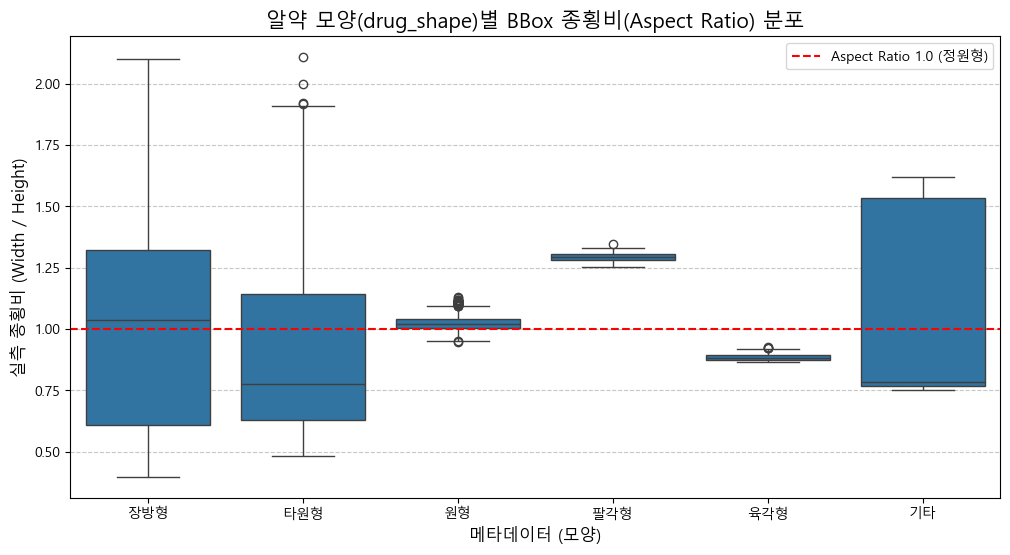

In [30]:
# 데이터 준비
shape_map_df = metadata_all_pills_df[['dl_name', 'drug_shape']].drop_duplicates()

# 'bbox_df'와 'shape_map_df'를 병합 ('class_name'과 'dl_name' 기준)
cross_validation_df = pd.merge(
    bbox_df, 
    shape_map_df, 
    left_on = 'class_name', 
    right_on = 'dl_name', 
    how = 'left'
)

# 바로 여기서 '가바토파정 100mg' 같이 'drug_shape' 정보가 없는 데이터는 제외시켜준다
cross_validation_df = cross_validation_df.dropna(subset = ['drug_shape'])

# 모양(Shape)별 종횡비(Aspect Ratio) 통계 분석
print("알약 모양(drug_shape)별 실제 BBox 종횡비(w/h) 통계")
shape_ar_stats = cross_validation_df.groupby('drug_shape')['aspect_ratio'].describe()
print(shape_ar_stats.to_string(float_format = "%.3f"))

# 이상치 탐지: 논리적 모순
print("\n" + "="*70)
print("메타데이터와 실측값의 논리적 모순")

# '원형'인데 종횡비가 1.0에서 크게 벗어난 경우
outlier_circle = cross_validation_df[
    (cross_validation_df['drug_shape'] == '원형') & 
    ((cross_validation_df['aspect_ratio'] < 0.7) | (cross_validation_df['aspect_ratio'] > 1.3))
]

# '장방형' 또는 '타원형'인데 종횡비가 1.0에 가까운 경우
outlier_rectangle = cross_validation_df[
    (cross_validation_df['drug_shape'].isin(['장방형', '타원형', '캡슐제'])) & 
    (cross_validation_df['aspect_ratio'] >= 0.9) & (cross_validation_df['aspect_ratio'] <= 1.1)
]

print(f"\n  - 이상치 1 ('원형' 아님): {len(outlier_circle)}개 발견")
if len(outlier_circle) > 0:
    print("    -> 예시 클래스 (상위 5개):")
    print(outlier_circle['class_name'].value_counts().head(5).to_string())

print(f"\n  - 이상치 2 ('장방형/타원형' 아님): {len(outlier_rectangle)}개 발견")
if len(outlier_rectangle) > 0:
    print("    -> 예시 클래스 (상위 5개):")
    print(outlier_rectangle['class_name'].value_counts().head(5).to_string())
    
# 시각화 (Boxplot)
print("\n" + "="*70)
print("모양별 종횡비 분포")

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'drug_shape', y = 'aspect_ratio', data = cross_validation_df)
plt.axhline(y = 1.0, color = 'r', linestyle = '--', label = 'Aspect Ratio 1.0 (정원형)')
plt.title('알약 모양(drug_shape)별 BBox 종횡비(Aspect Ratio) 분포', fontsize = 15)
plt.xlabel('메타데이터 (모양)', fontsize = 12)
plt.ylabel('실측 종횡비 (Width / Height)', fontsize = 12)
plt.legend()
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

output_filename = 'shape_vs_aspect_ratio_boxplot.png'
plt.savefig(output_filename)

- 실제 이미지에서 측정된 BBox의 종횡비가 논리적으로 일치하는지 교차 검증했다
- 기대되는 종횡비(w/h)가 명확한 원형과 장방형/타원형 이 두 그룹만 검사했다
- 원형 (Circle): 수학적으로 종횡비(Aspect Ratio)가 무조건 1.0에 가까워야 한다 그래서 (종횡비 < 0.7) 이거나 (종횡비 > 1.3)처럼 1.0에서 크게 벗어나는 놈이 있는지 검사한다 (결과: 0개 발견)
- 장방형 (Rectangle) / 타원형 (Ellipse): 길쭉한 모양이므로 종횡비가 1.0에서 벗어나야 한다 그래서 (종횡비 >= 0.9) 이고 (종횡비 <= 1.1)처럼 오히려 1.0에 가까운 (즉, 정사각형/정원형에 가까운) 놈이 있는지 검사한다 (결과: 250개 발견)
- 나머지 모양(육각형, 팔각형, 기타)은 육각형/팔각형인 경우에는 통계표를 보면 육각형은 평균 0.886, 팔각형은 평균 1.295로, 그 자체로 일관된 종횡비를 가진다 원형이나 장방형처럼 명확한 논리적 모순을 정의하기 애매해서 검사에서 빠졌다
- 기타는 말그대로 기타라서 정해진 형태가 없으므로 검사할 기준 자체가 없다
- 촬영을 어떻게 하느냐에 따라 그리고 약을 어떻게 배치하느냐 등에 따라 BBox의 종횡비가 달라지는 것 같다
    - 저 250개는 이상치가 아니다 촬영 각도 또는 알약의 놓인 방향 때문에 발생하는 자연스러운 현상이라 생각된다
- 오히려 모델이 더 다양하게 학습을 할 수 있을 것 같기도 하다

### BBox 이상치 확인

In [31]:
# 바운딩 박스 이상치 탐지
def find_bbox_outliers(bbox_df, img_w=976, img_h = 1280):
    # 이미지 경계를 벗어나는 바운딩 박스
    out_of_bound = bbox_df[
        (bbox_df['x_center'] - bbox_df['w']/2 < 0) | 
        (bbox_df['y_center'] - bbox_df['h']/2 < 0) | 
        (bbox_df['x_center'] + bbox_df['w']/2 > img_w) | 
        (bbox_df['y_center'] + bbox_df['h']/2 > img_h)
    ]
    
    # 비정상적으로 작거나 큰 바운딩 박스 (IQR)
    Q1 = bbox_df['area'].quantile(0.25)
    Q3 = bbox_df['area'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    size_outliers = bbox_df[
        (bbox_df['area'] < lower_bound) | 
        (bbox_df['area'] > upper_bound)
    ]
    
    return out_of_bound, size_outliers, lower_bound, upper_bound

# 이상치 탐지 실행
out_of_bound, size_outliers, lower_bound, upper_bound = find_bbox_outliers(bbox_df)

print(f"이미지 경계 벗어난 바운딩 박스: {len(out_of_bound)}개")
print(f"크기 이상치 바운딩 박스: {len(size_outliers)}개")
print(f"이상치 기준 - 작은쪽: {lower_bound:.1f}, 큰쪽: {upper_bound:.1f}")

이미지 경계 벗어난 바운딩 박스: 2개
크기 이상치 바운딩 박스: 74개
이상치 기준 - 작은쪽: -50949.6, 큰쪽: 200641.4


#### BBox 이상치 탐색

In [32]:
# 이상치 상세 분석
# 이미지 경계 벗어난 바운딩 박스 상세
if len(out_of_bound) > 0:
    print("이미지 경계를 벗어난 바운딩 박스:")
    for idx, row in out_of_bound.iterrows():
        print(f"  - 파일: {row['filename']}")
        print(f"    클래스: {row['class_name']}")
        print(f"    위치: ({row['x_center']:.1f}, {row['y_center']:.1f})")
        print(f"    크기: {row['w']}x{row['h']} (면적: {row['area']})")
else:
    print("이미지 경계를 벗어난 바운딩 박스 없음")

print("\n", '=' * 70)

# 크기 이상치 바운딩 박스 상세
if len(size_outliers) > 0:
    print(f"\n크기 이상치 바운딩 박스 ({len(size_outliers)}개):")
    
    # 너무 큰 바운딩 박스
    too_large = size_outliers[size_outliers['area'] > upper_bound]
    print(f"너무 큰 바운딩 박스: {len(too_large)}개")
    if len(too_large) > 0:
        print("대표적인 큰 바운딩 박스 클래스:")
        print(too_large['class_name'].value_counts().head(5))
    
    # 너무 작은 바운딩 박스
    too_small = size_outliers[size_outliers['area'] < lower_bound]
    print(f"너무 작은 바운딩 박스: {len(too_small)}개")
    if len(too_small) > 0:
        print("대표적인 작은 바운딩 박스 클래스:")
        print(too_small['class_name'].value_counts().head(5))

이미지 경계를 벗어난 바운딩 박스:
  - 파일: K-003351-016262-018357_0_2_0_2_75_000_200.png
    클래스: 종근당글리아티린연질캡슐(콜린알포세레이트) 
    위치: (6722.5, 782.5)
    크기: 311x315 (면적: 97965)
  - 파일: K-003544-004543-012247-016551_0_2_0_2_70_000_200.png
    클래스: 무코스타정(레바미피드)(비매품)
    위치: (761.5, 8997.5)
    크기: 217x217 (면적: 47089)


크기 이상치 바운딩 박스 (74개):
너무 큰 바운딩 박스: 74개
대표적인 큰 바운딩 박스 클래스:
class_name
자누메트엑스알서방정 100/1000mg       52
오마코연질캡슐(오메가-3-산에틸에스테르90)    12
제미메트서방정 50/1000mg            7
자누메트정 50/850mg               3
Name: count, dtype: int64
너무 작은 바운딩 박스: 0개


- 저 2개는 수정할 수 있으면 수정을 하고 안되면 삭제를 고려해본다
- 저 74개가 아까 BBox 면적을 늘린 것 같다 단순히 그냥 큰 알약들이라 생각되니 삭제하지 않는다
    - 예를 들어 오마코연질캡슐(12개)는 실제 크기가 2.4cm로 연질캡슐이며 삼키기 어려울 정도로 크기가 큰 것으로 매우 유명한 약이라고 한다

### BBox IoU 확인

In [33]:
# master_data에서 모든 BBox 정보를 수집하고 DataFrame 생성

# BBox 종횡비 분석 (Aspect Ratio: w / h)
bbox_df['aspect_ratio'] = bbox_df['w'] / bbox_df['h']
# BBox 위치 분포 분석 (Normalized Center)
bbox_df['x_center_norm'] = bbox_df['x_center'] / IMG_W
bbox_df['y_center_norm'] = bbox_df['y_center'] / IMG_H

# IoU 계산 함수
# IoU 계산 함수 (Intersection over Union)
# BBox 형식: [x_center, y_center, w, h]를 사용하여 계산
def calculate_iou_from_center(box1, box2):
    # 형식: [xc, yc, w, h]
    xc1, yc1, w1, h1 = box1
    xc2, yc2, w2, h2 = box2
    
    # BBox를 [x_min, y_min, x_max, y_max] 형식으로 변환
    x_min1, y_min1 = xc1 - w1/2, yc1 - h1/2
    x_max1, y_max1 = xc1 + w1/2, yc1 + h1/2
    
    x_min2, y_min2 = xc2 - w2/2, yc2 - h2/2
    x_max2, y_max2 = xc2 + w2/2, yc2 + h2/2

    # 교차 영역 (Intersection) 좌표
    x_left = max(x_min1, x_min2)
    y_top = max(y_min1, y_min2)
    x_right = min(x_max1, x_max2)
    y_bottom = min(y_max1, y_max2)

    # 교차 영역 면적
    if x_right < x_left or y_bottom < y_top:
        return 0.0 # 교차 영역이 없으면 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # 합집합 영역 (Union) 면적
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - intersection_area

    # IoU 계산
    return intersection_area / union_area

# IoU 계산 데이터 준비 및 실행
# 이미지별 BBox 쌍의 IoU 분석
all_iou_values = []
# master_data를 이미지별로 IoU 계산에 필요한 BBox 리스트로 변환
# { 'filename': [[x_center, y_center, w, h], ...], ... }
image_bboxes = defaultdict(list)

# 필요한 컬럼만 추출하여 BBox 리스트 생성 (순서 통일: [x_center, y_center, w, h])
for _, row in bbox_df.iterrows():
    # BBox는 [x_center, y_center, w, h] 형식으로 저장
    bbox_data = [row['x_center'], row['y_center'], row['w'], row['h']]
    image_bboxes[row['filename']].append(bbox_data)

# 이미지별 BBox 쌍 IoU 계산
for filename, bboxes in tqdm(image_bboxes.items(), desc="Calculating IoU"):
    num_bboxes = len(bboxes)
    if num_bboxes < 2:
        continue # 객체가 1개 이하면 IoU 계산 불필요

    # 모든 BBox 쌍에 대해 IoU 계산
    for i in range(num_bboxes):
        for j in range(i + 1, num_bboxes):
            # 수정된 중심 좌표 기반 IoU 함수 사용 (통일된 형식)
            iou = calculate_iou_from_center(bboxes[i], bboxes[j])
            all_iou_values.append(iou)

iou_df = pd.Series(all_iou_values, name='IoU')

print("\n" + "=" * 60)

# IoU 분포 통계
print("\n1. IoU 값 분포 통계")
print(iou_df.describe().to_string())

# 2. 겹침 수준별 BBox 쌍 개수
# IoU 임계값: 0.5 이상은 '높은 겹침', 0.2 이상은 '중간 겹침'으로 분류
HIGH_OVERLAP_THRESHOLD = 0.5
MEDIUM_OVERLAP_THRESHOLD = 0.1

high_overlap = len(iou_df[iou_df >= HIGH_OVERLAP_THRESHOLD])
medium_overlap = len(iou_df[(iou_df >= MEDIUM_OVERLAP_THRESHOLD) & (iou_df < HIGH_OVERLAP_THRESHOLD)])
low_overlap = len(iou_df[iou_df < MEDIUM_OVERLAP_THRESHOLD])

total_pairs = len(iou_df)

print("\n2. BBox 겹침 수준별 개수")
print(f"총 BBox 쌍 개수: {total_pairs}개")
print(f"- 높은 겹침 (IoU >= {HIGH_OVERLAP_THRESHOLD}): {high_overlap}개 ({high_overlap / total_pairs:.1%})")
print(f"- 중간 겹침 ({MEDIUM_OVERLAP_THRESHOLD} <= IoU < {HIGH_OVERLAP_THRESHOLD}): {medium_overlap}개 ({medium_overlap / total_pairs:.1%})")
print(f"- 낮은 겹침 (IoU < {MEDIUM_OVERLAP_THRESHOLD}): {low_overlap}개 ({low_overlap / total_pairs:.1%})")


# IoU >= 0.2인 이미지 파일 탐지
# IoU 임계값을 0.2로 설정하여 중간 겹침까지 포함
# IoU >= 0.1인 이미지 파일 탐지 (임계값을 0.1로 변경)
HIGH_IOU_THRESHOLD = 0.1  # 이 줄만 0.2 → 0.1로 변경
high_iou_files = set()

# image_bboxes 딕셔너리를 사용하여 파일명 기반으로 탐색
for filename, bboxes in image_bboxes.items():
    num_bboxes = len(bboxes)
    if num_bboxes < 2:
        continue # 객체가 1개 이하면 IoU 계산 불필요 

    is_high_overlap = False
    
    # 모든 BBox 쌍에 대해 IoU 계산
    for i in range(num_bboxes):
        for j in range(i + 1, num_bboxes):
            
            # BBox 데이터 [x_center, y_center, w, h]
            xc1, yc1, w1, h1 = bboxes[i]
            xc2, yc2, w2, h2 = bboxes[j]
            
            # [x_min, y_min, x_max, y_max] 형식으로 변환
            x_min1, y_min1 = xc1 - w1/2, yc1 - h1/2
            x_max1, y_max1 = xc1 + w1/2, yc1 + h1/2
            x_min2, y_min2 = xc2 - w2/2, yc2 - h2/2
            x_max2, y_max2 = xc2 + w2/2, yc2 + h2/2
            
            # 교차 영역 (Intersection) 계산
            x_left = max(x_min1, x_min2)
            y_top = max(y_min1, y_min2)
            x_right = min(x_max1, x_max2)
            y_bottom = min(y_max1, y_max2)

            if x_right < x_left or y_bottom < y_top:
                iou = 0.0
            else:
                intersection_area = (x_right - x_left) * (y_bottom - y_top)
                area1 = w1 * h1
                area2 = w2 * h2
                union_area = area1 + area2 - intersection_area
                iou = intersection_area / union_area

            # IoU가 임계값(0.1)을 초과하면 해당 파일명을 기록
            if iou >= HIGH_IOU_THRESHOLD:
                high_iou_files.add(filename)
                is_high_overlap = True
                break
        if is_high_overlap:
            break

print(f"\nIoU >= {HIGH_IOU_THRESHOLD}인 높은/중간 겹침 BBox를 포함하는 이미지 파일:")
for filename in high_iou_files:
    print(f"- {filename}")

Calculating IoU: 100%|██████████| 1489/1489 [00:00<00:00, 212722.46it/s]



1. IoU 값 분포 통계
count    5138.000000
mean        0.001225
std         0.032584
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

2. BBox 겹침 수준별 개수
총 BBox 쌍 개수: 5138개
- 높은 겹침 (IoU >= 0.5): 5개 (0.1%)
- 중간 겹침 (0.1 <= IoU < 0.5): 4개 (0.1%)
- 낮은 겹침 (IoU < 0.1): 5129개 (99.8%)

IoU >= 0.1인 높은/중간 겹침 BBox를 포함하는 이미지 파일:
- K-003483-019861-025367-029667_0_2_0_2_90_000_200.png
- K-003351-020238-031863_0_2_0_2_70_000_200.png
- K-003351-003832-029667_0_2_0_2_90_000_200.png
- K-001900-016548-019607-033009_0_2_0_2_70_000_200.png
- K-002483-003743-012081-019552_0_2_0_2_90_000_200.png
- K-003351-018147-020238_0_2_0_2_90_000_200.png
- K-003483-019861-020238-031885_0_2_0_2_70_000_200.png
- K-003351-029667-031863_0_2_0_2_70_000_200.png
- K-003483-027733-030308-036637_0_2_0_2_90_000_200.png


- BBox가 겹치는 경우는 거의 없다
    - 통제된 환경이 확실한 것 같다
- 높은/중간 겹침 BBox를 포함하는 이미지 파일들 9개는 직접 확인을 해봐야겠다
- 시각적으로 확인해서 오류면 수정이나 삭제를 고려해본다
- 겹침이 거의 없으므로 NMS(Non-Maximum Suppression) 임계값을 약간만 겹쳐도 중복으로 간주하고 보수적으로 설정할 수도 있겠다

#### IoU 겹침 이상치 확인

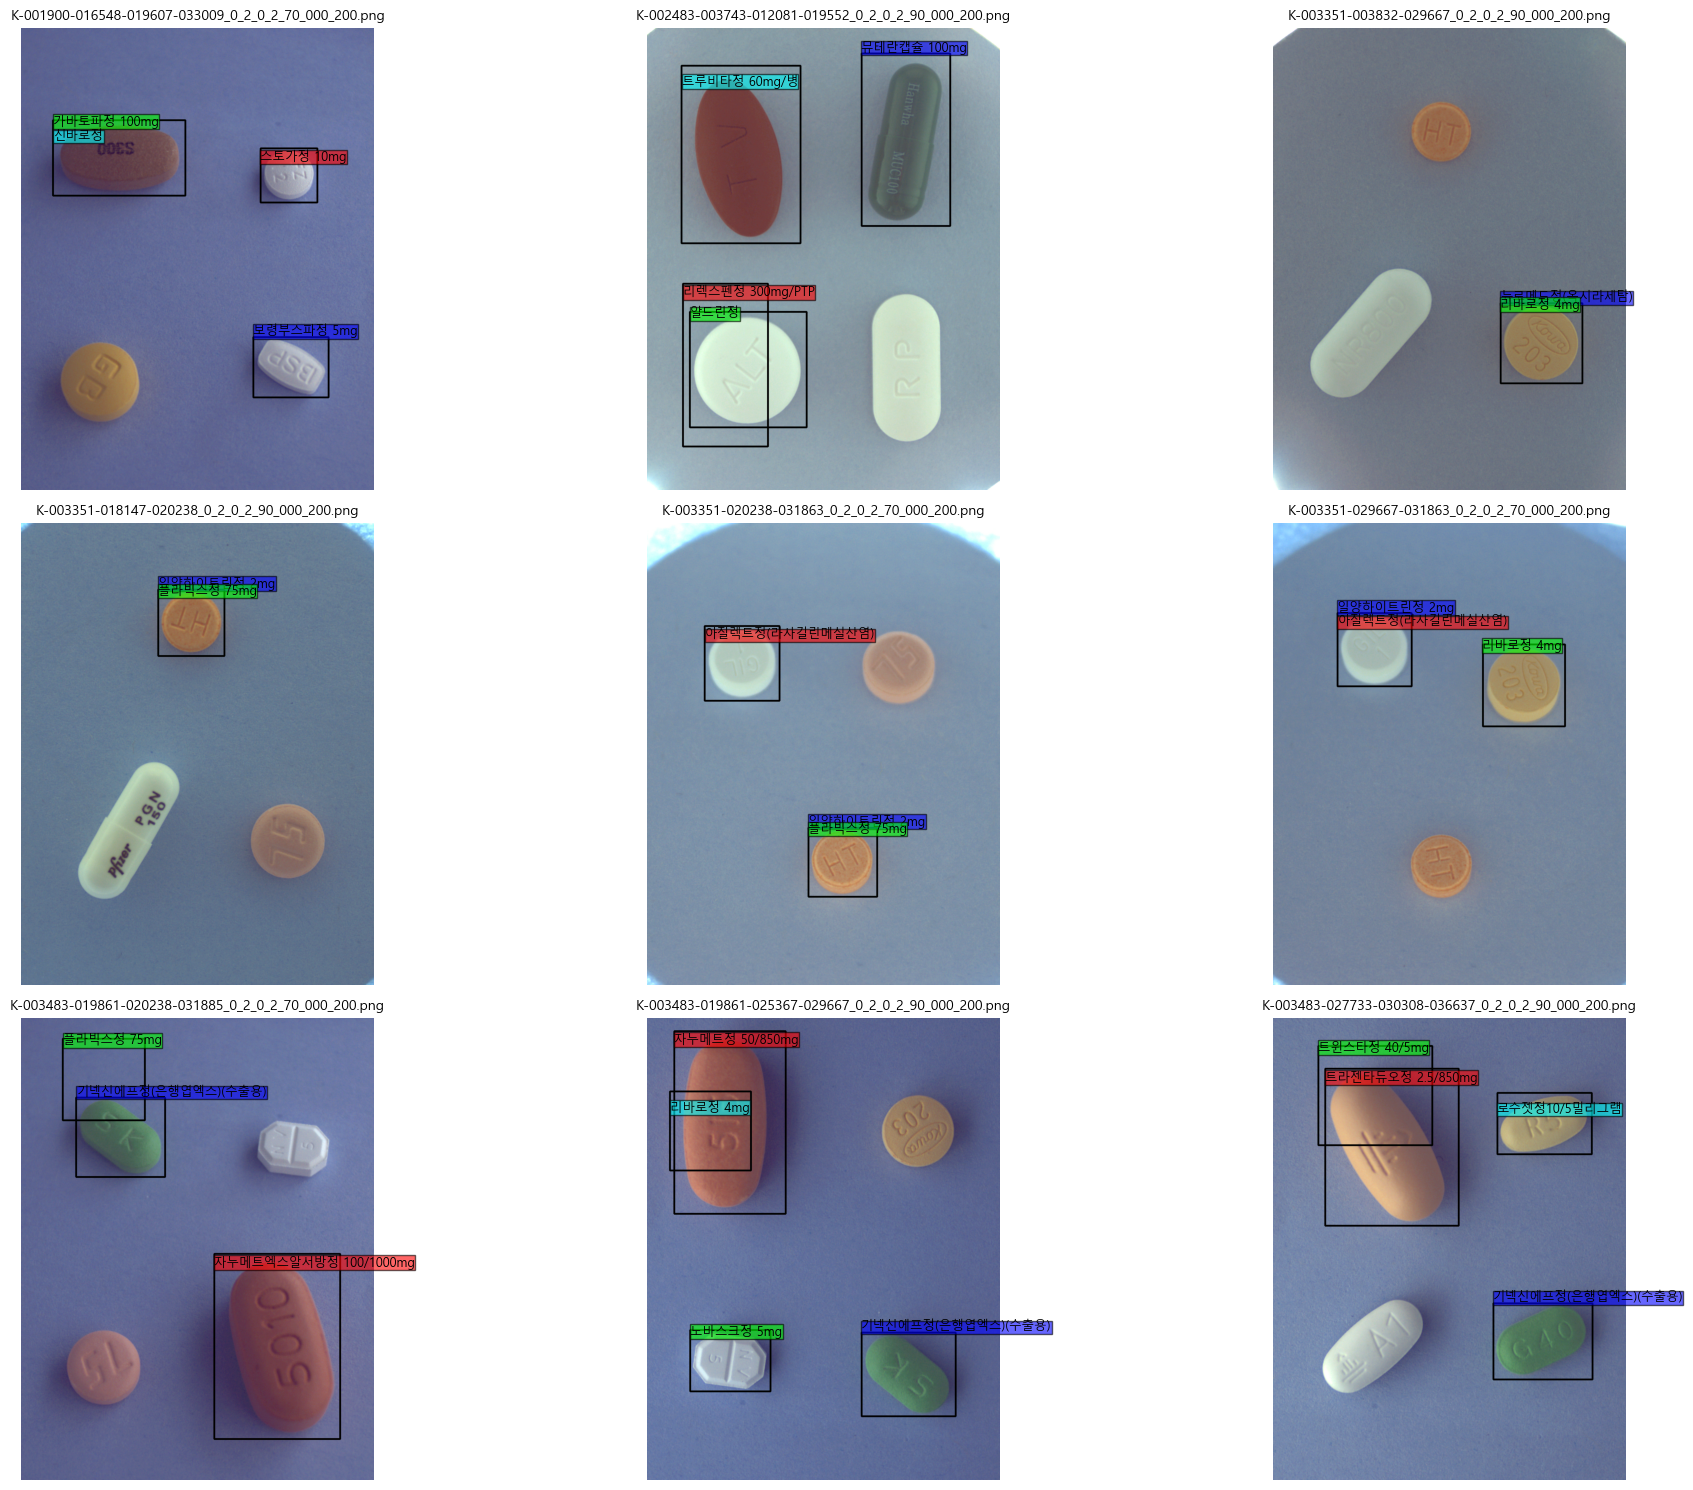

In [34]:
# 9개 파일명 리스트로 변환
overlap_filenames = sorted(list(high_iou_files))

# BBox를 그릴 색상 (B, G, R) - 최대 4개
COLORS = [
    (255, 0, 0),  # Blue
    (0, 255, 0),  # Green
    (0, 0, 255),  # Red
    (255, 255, 0) # Yellow
]

# 3x3 그리드로 설정 (4x2 → 3x3으로 변경)
plt.figure(figsize = (20, 15))  # 사이즈도 약간 조정

for i, img_filename in enumerate(overlap_filenames):
    img_path = os.path.join(train_img_dir, img_filename)
    
    # 이미지 로드 (OpenCV: BGR)
    image = cv2.imread(img_path)
    if image is None:
        print(f"오류: '{img_path}' 로드 실패. 다음으로 넘어갑니다.")
        continue
        
    # 이미지 -> RGB (Matplotlib 용)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # master_data에서 어노테이션 정보 가져오기
    annotations = master_data[img_filename]['annotations']
    
    # 서브플롯 생성 (4,2, i+1 → 3,3, i+1으로 변경)
    plt.subplot(3, 3, i + 1)
    
    # 이미지에 BBox와 텍스트 그리기
    for j, ann in enumerate(annotations):
        # BBox 좌표 [x, y, w, h]
        x, y, w, h = map(int, ann['bbox'])
        
        # 클래스 ID로 이름 찾기
        class_id = ann['class_id']
        class_name = id_to_class.get(class_id, "Unknown")
        
        # 색상 선택 (Matplotlib RGB 0~1 스케일)
        color_bgr = COLORS[j % len(COLORS)] 
        color_rgb = (color_bgr[2]/255, color_bgr[1]/255, color_bgr[0]/255) 
        
        # 사각형 그리기
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), color_rgb, thickness=3)
        
        # 텍스트 그리기 (j*20 : 텍스트가 겹치지 않게 y위치 살짝 조정)
        plt.text(x, y - 5 + (j*20), class_name, 
                 color='black', 
                 fontsize=9, 
                 bbox=dict(facecolor=color_rgb, alpha=0.6, pad=0.1))

    # 서브플롯에 이미지 표시
    plt.imshow(image_rgb)
    plt.title(f"{img_filename}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
output_filename = 'overlapping_bboxes_visualization.png'
plt.savefig(output_filename)

- 실제로 겹치는 것들이 있다
- 겹치는 것들은 수정을 시도 해보고 안되면 삭제를 한다

#### 오류 파일 삭제

In [35]:
# 삭제할 파일 목록 리스트업 (총 11개)
iou_error_files = [
    "K-003351-018147-020238_0_2_0_2_90_000_200.png",
    "K-003483-027733-030308-036637_0_2_0_2_90_000_200.png",
    "K-003351-020238-031863_0_2_0_2_70_000_200.png",
    "K-003351-029667-031863_0_2_0_2_70_000_200.png",
    "K-003483-019861-025367-029667_0_2_0_2_90_000_200.png",
    "K-002483-003743-012081-019552_0_2_0_2_90_000_200.png",
    "K-003483-019861-020238-031885_0_2_0_2_70_000_200.png",
    "K-003351-003832-029667_0_2_0_2_90_000_200.png",
    "K-001900-016548-019607-033009_0_2_0_2_70_000_200.png"
]

oob_error_files = [
    "K-003351-016262-018357_0_2_0_2_75_000_200.png",
    "K-003544-004543-012247-016551_0_2_0_2_70_000_200.png"
]

# 제거할 넥시움 의심 이미지 6개
nexium_suspect_images = [
    'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png',
    'K-001900-010224-016551-031705_0_2_0_2_75_000_200.png', 
    'K-001900-010224-016551-031705_0_2_0_2_90_000_200.png',
    'K-001900-010224-016551-033009_0_2_0_2_70_000_200.png',
    'K-001900-010224-016551-033009_0_2_0_2_75_000_200.png',
    'K-001900-010224-016551-033009_0_2_0_2_90_000_200.png'
]

files_to_delete = iou_error_files + oob_error_files + nexium_suspect_images

# master_data에서 해당 파일들 삭제
deleted_count = 0
print(f"삭제 전 원본 master_data 개수: {len(master_data)}개")

for filename in files_to_delete:
    # master_data에 해당 키(파일명)가 있는지 확인
    if filename in master_data:
        # 딕셔너리에서 해당 항목 삭제
        del master_data[filename]
        deleted_count += 1
        # print(f"삭제 완료: {filename}") # 확인용 로그
    else:
        # 혹시 모르니 master_data에 파일이 없는 경우 로그
        print(f"경고: {filename}이 master_data에 없음")

print(f"총 {deleted_count}개의 오류 파일을 삭제")
print(f"정제 후 master_data 개수: {len(master_data)}개")

삭제 전 원본 master_data 개수: 1489개
총 17개의 오류 파일을 삭제
정제 후 master_data 개수: 1472개


IoU >= 0.1인 높은/중간 겹침 BBox를 포함하는 이미지 파일:
- K-003351-003832-029667_0_2_0_2_90_000_200.png
- K-003483-019861-020238-031885_0_2_0_2_70_000_200.png
- K-003351-020238-031863_0_2_0_2_70_000_200.png
- K-003483-019861-025367-029667_0_2_0_2_90_000_200.png
- K-001900-016548-019607-033009_0_2_0_2_70_000_200.png
- K-002483-003743-012081-019552_0_2_0_2_90_000_200.png
- K-003483-027733-030308-036637_0_2_0_2_90_000_200.png
- K-003351-029667-031863_0_2_0_2_70_000_200.png
- K-003351-018147-020238_0_2_0_2_90_000_200.png

이미지 경계를 벗어난 바운딩 박스:
- K-003351-016262-018357_0_2_0_2_75_000_200.png
- K-003544-004543-012247-016551_0_2_0_2_70_000_200.png

그리고 의사 라벨링을 하다가 이미지에서 73개의 클래스에 포함되지 않는 넥시움이라는 약을 찾았다 제거를 해준다
- 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png',
- 'K-001900-010224-016551-031705_0_2_0_2_75_000_200.png', 
- 'K-001900-010224-016551-031705_0_2_0_2_90_000_200.png',
- 'K-001900-010224-016551-033009_0_2_0_2_70_000_200.png',
- 'K-001900-010224-016551-033009_0_2_0_2_75_000_200.png',
- 'K-001900-010224-016551-033009_0_2_0_2_90_000_200.png'

삭제를 해주었다

In [36]:
# 클린셋 추출
# clean_files 리스트를 사용
clean_master_data = {}

for filename in clean_files:
    # 1,478개의 master_data에서 clean_files 목록에 있는 파일만 골라서
    if filename in master_data:
        # clean_master_data 라는 새 딕셔너리에 복사
        clean_master_data[filename] = master_data[filename]

print(f"총 {len(master_data)}개 데이터 중,")
print(f"최종 클린 데이터셋 생성 완료: {len(clean_master_data)}개")

총 1472개 데이터 중,
최종 클린 데이터셋 생성 완료: 632개


- 그리고 위에서 확인했던 파일명 개수와 어노테이션 개수가 일치하는 클린한 것들만 클린셋으로 만들어준다
- 오류가 있었던 17개 중에서 7개가 포함됐었던 것 같다(오류 11개 삭제후에 클린셋의 변화 639개 => 632개)
- 이제 의사 레이블링 전까지 이 클린셋으로만 데이터 분할을 시작한다

# 실험 시작

In [37]:
!pip install ultralytics

## 데이터셋

### 데이터 분할 준비

In [ ]:
# 클린셋 기준 클래스 분포 재분석
clean_class_names = []
# 11개 삭제 후 632개만 뽑은 clean_master_data를 사용한다
for img_data in clean_master_data.values():
    for ann in img_data['annotations']:
        clean_class_names.append(ann['class_name'])

clean_class_counts = Counter(clean_class_names)

# Stratified Split에 사용할 클래스별 전체 개수 Lookup Table
class_count_lookup = dict(clean_class_counts)

print(f"클린셋(632개 이미지)의 총 BBox 수: {len(clean_class_names)}")
print(f"클린셋의 고유 클래스 수: {len(clean_class_counts)}")

- 클린셋만 분리해냈다
- 클래스 수는 유지된다
- 클래스 분포가 엉망이었다
- Stratified Split을 해준다

### 데이터 분할 & 데이터셋 생성 & 데이터로더 생성

### 데이터 분할

In [ ]:
# clean_master_data (632개), class_count_lookup, class_to_id, 
# base_dir, train_img_dir, train_ann_dir 변수가 메모리에 로드된 상태

import numpy as np
import shutil
import torch
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import cv2
import json
from collections import defaultdict, Counter # (이미 import됨)

# Stratified Split
X_filenames_clean = []       # 632개 이미지 파일명
y_stratify_labels_clean = [] # 632개 이미지의 대표 클래스

for filename, data in clean_master_data.items():
    if not data['annotations']:
        continue 

    X_filenames_clean.append(filename)
    
    img_classes = [ann['class_name'] for ann in data['annotations']]
    counts = [class_count_lookup.get(name, 99999) for name in img_classes]
    
    # 개수가 가장 적은 클래스를 대표로 선정
    rarest_class_name = img_classes[np.argmin(counts)]
    y_stratify_labels_clean.append(rarest_class_name)

print(f"클린셋 분할 준비: X (파일명) {len(X_filenames_clean)}개, y (대표 레이블) {len(y_stratify_labels_clean)}개")

# 1-2. 클린셋 632개를 8:2로 분할
train_files_clean, val_files_clean = train_test_split(
    X_filenames_clean,
    test_size=0.2,
    stratify=y_stratify_labels_clean,
    random_state=42
)

print(f"클린셋 분할 결과 -> Train: {len(train_files_clean)}개, Val: {len(val_files_clean)}개")

# 1-3. [중요] 제출(Submission)용 ID 맵 생성
# 맵 1: [YOLO ID (0~72)] -> [클래스 이름]
# (class_to_id 맵을 뒤집기)
yolo_id_to_name = {v: k for k, v in class_to_id.items()}
print(f"\n맵 1 (YOLO ID -> 이름) 로드: {len(yolo_id_to_name)}개")

# 맵 2: [클래스 이름] -> [Kaggle 원본 ID (e.g., 1899)]
# (원본 train_annotations 폴더를 스캔하여 생성)
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True)
name_to_original_id = {}
print("맵 2 (이름 -> Kaggle ID) 생성 중")

for jf in tqdm(json_files, desc="Parsing Original IDs"):
    try:
        with open(jf, 'r', encoding='utf-8') as f:
            data = json.load(f)
        if data.get('categories'):
            for cat in data['categories']:
                name = cat['name']
                original_id = cat['id']
                if name not in name_to_original_id:
                    name_to_original_id[name] = original_id
    except Exception as e:
        continue 

print(f"맵 2 (이름 -> Kaggle ID) 생성 완료: {len(name_to_original_id)}개")

# 기타 경로 설정
test_img_dir = os.path.join(base_dir, "test_images")
submission_dir = os.path.join(base_dir, "Exp", "submissions_clean")
os.makedirs(submission_dir, exist_ok=True)
print(f"테스트 이미지 폴더: {test_img_dir}")
print(f"제출 파일 저장 폴더: {submission_dir}")

#  YOLO 포맷 변환 및 데이터셋 생성 함수
def convert_to_yolo_format(bbox, img_width, img_height):
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

def create_yolo_dataset(file_list, data_source, class_map, split_name, target_base_dir):
    img_dir = os.path.join(target_base_dir, split_name, 'images')
    lbl_dir = os.path.join(target_base_dir, split_name, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)
    
    for filename in tqdm(file_list, desc=f"Creating {split_name} dataset"):
        img_data = data_source[filename]
        
        src_img_path = os.path.join(train_img_dir, filename)
        dst_img_path = os.path.join(img_dir, filename)
        shutil.copy(src_img_path, dst_img_path)
        
        label_filename = filename.replace('.png', '.txt')
        label_path = os.path.join(lbl_dir, label_filename)
        
        with open(label_path, 'w') as f:
            for ann in img_data['annotations']:
                class_id = class_map.get(ann['class_name']) 
                if class_id is None: continue
                bbox = ann['bbox']
                x_c, y_c, w, h = convert_to_yolo_format(
                    bbox, img_data['width'], img_data['height']
                )
                f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

## YOLO 실험 시작
## YOLO 실험 1

In [ ]:
# YOLOv8(클린셋으로만)
from ultralytics import YOLO
from torchmetrics.detection import MeanAveragePrecision

# YOLO 클린셋용 폴더 및 data.yaml 생성
yolo_clean_dir = os.path.join(base_dir, "yolo_dataset_clean") # 클린셋 저장 폴더 경로
yaml_path_clean = os.path.join(yolo_clean_dir, 'data_clean.yaml') # 클린셋용 yaml 파일 경로

# Train/Val 데이터셋 생성 (클린셋 632개 기준, 8:2 분할 가정 -> 505/127개)
# (create_yolo_dataset 함수는 이전 셀에서 정의, clean_files를 8:2 분할한 train/val 리스트 사용)
create_yolo_dataset(train_files_clean, clean_master_data, class_to_id, 'train', yolo_clean_dir)
create_yolo_dataset(val_files_clean, clean_master_data, class_to_id, 'val', yolo_clean_dir)

# data.yaml 내용 생성 (클린셋 경로 및 클래스 정보 포함)
yaml_content_clean = f"""
path: {yolo_clean_dir}
train: train/images
val: val/images

# Classes
nc: {len(class_to_id)}
names: {list(class_to_id.keys())}
"""
# yaml 파일 쓰기
with open(yaml_path_clean, 'w', encoding='utf-8') as f:
    f.write(yaml_content_clean)

print(f"\nYOLO '클린셋' 데이터셋 생성 완료: {yolo_clean_dir}")

# YOLO 모델 학습
print("\n[YOLOv8] '클린셋' 학습 시작")
model_yolo_clean = YOLO('yolov8s.pt') # s 모델 사용

# 학습 실행
results_yolo_clean = model_yolo_clean.train(
    data=yaml_path_clean, # 클린셋 yaml 파일 사용
    epochs=200,           # 200 에폭
    imgsz=640,            # 이미지 크기 640
    batch=8,              # 배치 크기 8
    device=0,             # GPU 사용
    project=os.path.join(base_dir, "Exp"), # 결과 저장 경로
    name='clean_yolo_v1', # 실험 이름
    exist_ok=True,        # 덮어쓰기 허용
    patience=20,          # 조기 종료 조건
    lr0=0.01,             # 초기 학습률
    optimizer='AdamW',    # AdamW 옵티마이저
    augment=True,         # 기본 증강 사용
    close_mosaic=10       # 마지막 10 에폭 Mosaic 끄기
)

# mAP[0.75:0.95] 평가
print("\n[YOLOv8] '클린셋' mAP@[0.75:0.95] 평가 시작")

# 학습된 최고 성능 모델 로드
best_pt_yolo_clean = os.path.join(base_dir, "Exp", "clean_yolo_v1", "weights", "best.pt")
model_yolo_best_clean = YOLO(best_pt_yolo_clean)

# Kaggle 평가 지표 설정
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
map_metric_yolo_clean = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=iou_thresholds_kaggle
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Validation 루프 (클린셋 val_files_clean 127개 기준)
for img_filename in tqdm(val_files_clean, desc="YOLOv8 Clean Validation"):
    img_path = os.path.join(train_img_dir, img_filename) # 원본 이미지 경로

    # 예측 수행
    results = model_yolo_best_clean.predict(img_path, verbose=False, device=device)

    # 예측 결과(preds) 가공 (torchmetrics 형식)
    preds = [{'boxes': r.boxes.xyxy.cpu(), 'scores': r.boxes.conf.cpu(), 'labels': r.boxes.cls.cpu().int()} for r in results]

    # 정답(targets) 가공 (torchmetrics 형식, clean_master_data 사용)
    gt_data = clean_master_data[img_filename]
    gt_boxes = []
    gt_labels = []
    for ann in gt_data['annotations']:
        x, y, w, h = ann['bbox']
        gt_boxes.append([x, y, x + w, y + h]) # [x1, y1, x2, y2]
        gt_labels.append(class_to_id[ann['class_name']]) # 0~72 ID

    targets = [{'boxes': torch.tensor(gt_boxes, dtype=torch.float32), 'labels': torch.tensor(gt_labels, dtype=torch.int32)}]

    # mAP 계산기 업데이트
    map_metric_yolo_clean.update(preds, targets)

# 최종 mAP 계산
results_map_yolo = map_metric_yolo_clean.compute()
print("\n--- YOLOv8 '클린셋' 결과 ---")
# 결과 출력
print(f"mAP[0.75:0.95]: {results_map_yolo['map'].item():.4f}")

학습 설정: YOLOv8 (클린셋)

    - 모델: yolov8s.pt
    - 데이터셋: yolo_dataset_clean (632개 클린셋, Stratified 8:2 분할)
    - 에포크: 200
    - Patience: 20
    - 이미지 크기: 640
    - 배치 크기: 8
    - 옵티마이저: AdamW
    - 학습률 (lr0): 0.01
    - 증강 (Augment): True (기본 설정)
    - Mosaic 종료: 마지막 10 에포크
- YOLOv8 베이스 라인(클린셋) 최종 점수: 0.9689
- 17개의 파일을 삭제하고 오류셋에 파일들 850여 개를 제외하고 학습을 했는데 성능이 좋아졌다
- 역시 모델 아키텍처나 하이퍼파라미터 튜닝보다 학습 데이터의 품질(Quality)이 모델 성능에 가장 중요하다

## Faster R CNN 실험 시작

In [41]:
# 터미널이나 !pip를 사용하여 설치
!pip install torchmetrics

In [ ]:
# Faster R-CNN(클린셋)
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision

# Faster R-CNN용 Dataset 클래스 정의 (클린셋용)
class PillDatasetClean(Dataset):
    # file_list(파일명 리스트), data_source(clean_master_data) 등을 초기화
    def __init__(self, file_list, data_source, class_map, img_dir):
        self.file_list = file_list
        self.data_source = data_source
        self.class_map = class_map
        self.img_dir = img_dir

    # 데이터셋 총 길이 반환 (예: 505)
    def __len__(self):
        return len(self.file_list)

    # idx번째 데이터를 로드하는 함수
    def __getitem__(self, idx):
        img_filename = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        # 이미지 읽고 RGB 변환, 텐서로 변환
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = F.to_tensor(img_rgb)

        # clean_master_data에서 정답 정보 로드
        img_data = self.data_source[img_filename]
        boxes = []
        labels = []

        # 정답 어노테이션 순회
        for ann in img_data['annotations']:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h]) # [x1, y1, x2, y2]

            # 0번=배경, 1~73번=클래스 (YOLO ID + 1)
            class_id = self.class_map.get(ann['class_name'])
            if class_id is not None:
                labels.append(class_id + 1)
            else:
                labels.append(0) # 알 수 없는 클래스는 배경(0)

        # 리스트를 텐서로 변환
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        # 모델 입력 형식(target 딕셔너리) 생성
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        return img_tensor, target

# collate_fn (배치 생성용)
def collate_fn_clean(batch):
    return tuple(zip(*batch))

# DataLoaders 생성 (클린셋 505/127개 사용)
# (Stratified Split된 train/val 파일 리스트 사용)
train_dataset_clean = PillDatasetClean(train_files_clean, clean_master_data, class_to_id, train_img_dir)
val_dataset_clean = PillDatasetClean(val_files_clean, clean_master_data, class_to_id, train_img_dir)

# 학습용 DataLoader (배치 4, 셔플 ON)
train_loader_clean = DataLoader(
    train_dataset_clean,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn_clean
)
# 검증용 DataLoader (배치 4, 셔플 OFF)
val_loader_clean = DataLoader(
    val_dataset_clean,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn_clean
)

print(f"\nFaster R-CNN '클린셋' DataLoaders 생성: Train {len(train_loader_clean)} 배치, Val {len(val_loader_clean)} 배치")

# 3-4. 모델, 옵티마이저, 스케줄러 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_to_id) + 1 # 73 + 1(배경)

# 사전학습된 FasterRCNN-ResNet50-FPN 모델 로드
model_frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
# 최종 분류기를 74개 클래스로 교체
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_frcnn.to(device) # GPU로 이동

# 학습할 파라미터 필터링
params = [p for p in model_frcnn.parameters() if p.requires_grad]
# AdamW 옵티마이저, lr=0.0001
optimizer = torch.optim.AdamW(params, lr=0.0001)
# StepLR 스케줄러 (7 에폭마다 lr * 0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Kaggle mAP 지표 설정
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
# torchmetrics mAP 계산기 초기화
map_metric_frcnn = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=iou_thresholds_kaggle
)
map_metric_frcnn.to(device) # GPU로 이동
print(f"Kaggle 평가 지표 (IoU thresholds): {iou_thresholds_kaggle}")

# 학습 및 평가 루프
num_epochs = 30
best_map_75_95 = -1.0 # 최고 mAP 저장 변수 초기화
best_model_path_frcnn = os.path.join(base_dir, "Exp", "best_frcnn_clean_model.pth") # 최고 모델 저장 경로

print("\n[Faster R-CNN] '클린셋' 학습 및 평가 시작")

for epoch in range(num_epochs):

    # 학습 (Train)
    model_frcnn.train() # 학습 모드
    total_train_loss = 0
    # train_loader_clean 순회
    for images, targets in tqdm(train_loader_clean, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        # 데이터 GPU 이동
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Loss 계산
        loss_dict = model_frcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # 역전파
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(train_loader_clean)
    lr_scheduler.step() # 스케줄러 업데이트

    # 평가 (Validation)
    model_frcnn.eval() # 평가 모드
    map_metric_frcnn.reset() # mAP 계산기 초기화

    with torch.no_grad(): # 그래디언트 계산 비활성화
        # val_loader_clean 순회
        for images, targets in tqdm(val_loader_clean, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images = list(image.to(device) for image in images)
            # 예측 수행
            outputs = model_frcnn(images)

            # 결과 CPU 이동 (torchmetrics용)
            outputs_cpu = [{k: v.cpu() for k, v in t.items()} for t in outputs]
            targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]

            # [중요] 평가를 위해 1~73 -> 0~72 범위로 변환
            for t in targets_cpu: t['labels'] = t['labels'] - 1
            for o in outputs_cpu: o['labels'] = o['labels'] - 1

            # mAP 계산기 업데이트
            map_metric_frcnn.update(outputs_cpu, targets_cpu)

    # 최종 mAP 계산
    results_map_frcnn = map_metric_frcnn.compute()
    map_75_95 = results_map_frcnn['map'].item()

    print(f"\n--- Epoch {epoch+1} 결과 ---")
    print(f"Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Kaggle Metric mAP@[0.75:0.95]: {map_75_95:.4f}")

    # 최고 성능 모델 저장
    if map_75_95 > best_map_75_95:
        best_map_75_95 = map_75_95
        torch.save(model_frcnn.state_dict(), best_model_path_frcnn)
        print(f"최고 mAP 갱신 모델 저장: {best_model_path_frcnn}")

print(f"Faster R-CNN '클린셋' 학습 완료 Best mAP@[0.75:0.95]: {best_map_75_95:.4f}")

학습 설정: Faster R-CNN (클린셋)

    - 모델: fasterrcnn_resnet50_fpn (Pretrained)
    - 데이터셋: PillDatasetClean (632개 클린셋, Stratified 8:2 분할)
    - 에포크: 30
    - 이미지 크기: 원본 크기 (리사이즈 X)
    - 배치 크기: 4
    - 옵티마이저: AdamW
    - 학습률 (lr): 0.0001
    - 스케줄러: StepLR (step_size=7, gamma=0.1)
- Faster R CNN 베이스 라인(클린셋) 최종 점수: 0.9256
- 역시 클린셋으로만 하니까 점수가 좀 올라갔다 데이터 정제가 모델 종류에 상관없이 성능 향상에 필수적이다
- Faster R CNN은 속도 대비 성능에 이점이 크게 없는 것 같아서 앞으로의 실험은 YOLO로만 진행한다

## Pseudo Labeling

### 클린셋과 오류셋 분리

In [ ]:
import os
import shutil
import json
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

# [오류셋] 850개 레코드에서 파일명만 추출
error_filenames_initial = [record['filename'] for record in error_records]

# [오류셋] 850개 중 IoU/OOB 오류(11개)에 포함된 파일 제외
final_error_filenames = [f for f in error_filenames_initial if f not in files_to_delete]

# [클린셋] 632개 데이터에서 파일명 리스트 추출
final_clean_filenames = list(clean_master_data.keys())

print(f"\n[최종 분리 결과]")
print(f"  1단계 학습용 클린셋: {len(final_clean_filenames)}개")
print(f"  2단계 예측용 오류셋: {len(final_error_filenames)}개")
print(f"  (총 {len(final_clean_filenames) + len(final_error_filenames)}개 = 원본 {len(master_data)}개)")

# 데이터셋을 저장할 새 폴더 생성
output_clean_dir = os.path.join(base_dir, "A_CleanSet_for_Training")
output_error_dir = os.path.join(base_dir, "B_ErrorSet_for_Prediction")

os.makedirs(os.path.join(output_clean_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(output_clean_dir, "labels"), exist_ok=True)
os.makedirs(os.path.join(output_error_dir, "images"), exist_ok=True)

print(f"\n클린셋 폴더 생성: {output_clean_dir}")
print(f"오류셋 폴더 생성: {output_error_dir}")

# YOLO 라벨 변환 함수
def convert_to_yolo_format(bbox, img_width, img_height):
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

# 이미지 복사 및 YOLO 라벨 생성 함수
def process_dataset_split(filename_list, data_source, 
                          target_img_dir, target_label_dir=None):
    
    desc = f"Processing {os.path.basename(target_img_dir)}"
    copied_images = 0
    created_labels = 0
    
    for filename in tqdm(filename_list, desc=desc):
        # 이미지 복사
        src_path = os.path.join(train_img_dir, filename)
        dst_path = os.path.join(target_img_dir, filename)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
            copied_images += 1
        else:
            print(f"경고: 원본 이미지 없음 - {src_path}")
            continue
            
        # 라벨 생성 (클린셋에만 해당)
        if target_label_dir:
            img_data = data_source.get(filename)
            if not img_data:
                print(f"경고: 어노테이션 정보 없음 - {filename}")
                continue
                
            label_file = filename.replace('.png', '.txt').replace('.jpg', '.txt')
            label_path = os.path.join(target_label_dir, label_file)
            
            # class_to_id 변수가 메모리에 있다고 가정
            if 'class_to_id' not in globals():
                 print("오류: class_to_id 딕셔너리가 없습니다. 이전 셀을 실행하세요.")
                 break
            
            img_width = img_data['width']
            img_height = img_data['height']
            
            with open(label_path, 'w', encoding='utf-8') as f:
                for ann in img_data['annotations']:
                    # class_name으로 class_id를 다시 찾아야 함
                    class_name = ann['class_name']
                    class_id = class_to_id.get(class_name) 
                    
                    if class_id is None:
                        print(f"경고: class_to_id에 {class_name}이 없습니다.")
                        continue
                        
                    bbox = ann['bbox']
                    
                    if bbox[2] > 0 and bbox[3] > 0:
                        x_c, y_c, w, h = convert_to_yolo_format(bbox, img_width, img_height)
                        f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
                        created_labels += 1

    print(f"  -> {copied_images}개 이미지 복사 완료")
    if target_label_dir:
        print(f"  -> {created_labels}개 YOLO 라벨 생성 완료")

# 코드 실행

# [클린셋] 처리: 이미지 복사 + YOLO 라벨 생성
process_dataset_split(
    final_clean_filenames,
    clean_master_data,  # ★ 진짜 632개 클린셋 데이터 사용
    os.path.join(output_clean_dir, "images"),
    os.path.join(output_clean_dir, "labels")
)

# [오류셋] 처리: 이미지 복사 (라벨 생성 안 함)
process_dataset_split(
    final_error_filenames, # ★ 진짜 오류셋 파일명 리스트 사용
    master_data,
    os.path.join(output_error_dir, "images"),
    None  # 라벨 생성 안 함
)

print("\n모든 작업 완료")
print(f"1단계 학습용 클린셋: {output_clean_dir}")
print(f"2단계 예측용 오류셋: {output_error_dir}")

### 오류셋 예측 & Pseudo Labeling 필요한 파일 확인

In [ ]:
import os
import glob
from tqdm import tqdm

# 설정
train_label_dir = r"C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset\train\labels"

# 검사 실행
print(f"--- 5줄 이상 라벨 파일 찾기 ({train_label_dir}) ---")

# 폴더 존재 여부 먼저 확인
if not os.path.isdir(train_label_dir):
    print(f"오류: 폴더를 찾을 수 없습니다! 경로를 다시 확인해주세요: {train_label_dir}")
else:
    files_with_5_or_more_lines = [] # 5줄 이상 파일 목록
    error_files = [] # 읽기 오류 파일

    txt_files = glob.glob(os.path.join(train_label_dir, "*.txt"))
    if not txt_files:
        print("정보: 해당 폴더에 라벨 파일(.txt)이 없음")
    else:
        print(f"총 {len(txt_files)}개 파일 검사 중")
        for f_path in tqdm(txt_files, desc="Checking labels"):
            try:
                with open(f_path, 'r', encoding='utf-8') as f:
                    line_count = len([line for line in f if line.strip()])
                if line_count >= 5:
                    files_with_5_or_more_lines.append(os.path.basename(f_path))
            except Exception as e:
                print(f"\n파일 읽기 오류: {os.path.basename(f_path)} - {e}")
                error_files.append(os.path.basename(f_path))

        # --- 결과 출력 ---
        print("\n--- 검사 결과 ---")
        if files_with_5_or_more_lines:
            print(f"총 {len(files_with_5_or_more_lines)}개의 파일에서 5줄 이상이 발견:")
            for filename in files_with_5_or_more_lines:
                print(f" - {filename}")
            print("\n이 파일들을 라벨링 툴에서 열어서 확인하고 수정해야됨")
        else:
            print("5줄 이상인 라벨 파일을 찾지 못함")

        if error_files:
            print(f"\n주의: {len(error_files)}개 파일에서 읽기 오류 발생")
            print(error_files)

In [ ]:
import os
import re

# 처리할 폴더들
folders = [
    r"C:\Users\daboi\Desktop\nojpg\nojpg1",
    r"C:\Users\daboi\Desktop\nojpg\nojpg2"
]

for folder in folders:
    for filename in os.listdir(folder):
        old_path = os.path.join(folder, filename)

        if os.path.isfile(old_path):
            name, ext = os.path.splitext(filename)

            # "_png" 뒤에 오는 모든 문자열 제거
            new_name = re.sub(r'_png.*', '_png', name) + ext
            new_path = os.path.join(folder, new_name)

            if old_path != new_path:
                os.rename(old_path, new_path)
                print(f"{filename} -> {new_name}")

- 방금 학습한 YOLO 모델로 오류셋 840 개를 예측하고 라벨을 받아서 roboflow를 통해 의사 레이블링을 했다
- 840개의 약에 바운딩박스와 클래스 이름을 확인하고 수정을 해주었다

# 데이터 추가 후 실험

## 클린셋 + 의사 레이블링 된 오류셋 분할

In [ ]:
import os
import glob
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter, defaultdict # defaultdict 추가
import random

# 설정
combined_dataset_dir = r"C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset"
source_train_dir = os.path.join(combined_dataset_dir, "train")
target_valid_dir = os.path.join(combined_dataset_dir, "val")
validation_split_ratio = 0.2
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 경로 설정
source_images_dir = os.path.join(source_train_dir, "images")
source_labels_dir = os.path.join(source_train_dir, "labels")
target_train_images_dir = source_images_dir
target_train_labels_dir = source_labels_dir
target_valid_images_dir = os.path.join(target_valid_dir, "images")
target_valid_labels_dir = os.path.join(target_valid_dir, "labels")

os.makedirs(target_valid_images_dir, exist_ok=True)
os.makedirs(target_valid_labels_dir, exist_ok=True)

print("Stratified 데이터 분할 및 이동 시작")
print(f"소스 폴더 (Train): {source_train_dir}")
print(f"타겟 폴더 (Valid): {target_valid_dir}")

# Stratified Split을 위한 준비
all_image_files_temp = []      # 임시 이미지 파일명 리스트
stratify_labels_temp = []      # 임시 대표 클래스 ID 리스트
label_counts = Counter()       # 각 클래스 ID별 등장 횟수 카운트
images_with_no_labels = []   # 라벨 파일 없거나 빈 파일
images_with_read_error = [] # 라벨 파일 읽기 오류

print("\n라벨 파일 읽어서 Stratify 정보 및 클래스 빈도수 집계 중")
try:
    image_files_in_source = [f for f in os.listdir(source_images_dir)
                             if os.path.isfile(os.path.join(source_images_dir, f))]

    if not image_files_in_source:
         print("오류: train/images 폴더에 이미지 파일이 없음")
         # exit()

    for img_filename in tqdm(image_files_in_source, desc="Reading Labels for Stratify"):
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(source_labels_dir, label_filename)

        representative_label = -1 # 기본값: 라벨 없음 또는 오류

        if os.path.exists(label_path):
            try:
                with open(label_path, 'r') as f:
                    lines = [line.strip() for line in f if line.strip()]

                if lines: # 라벨 파일 내용이 있으면
                    # 첫 번째 줄의 클래스 ID를 대표로 사용
                    first_label_id = int(lines[0].split()[0])
                    representative_label = first_label_id
                    # 이미지 내 모든 라벨 카운트 (개선 가능: 실제론 이미지당 한 번만 카운트해야 함)
                    # 여기서는 우선 대표 라벨 기준으로만 카운트
                    label_counts[representative_label] += 1
                else: # 라벨 파일은 있는데 비어있으면
                     images_with_no_labels.append(img_filename)

            except Exception as e_read:
                print(f"\n라벨 파일 읽기 오류: {label_filename} - {e_read}.")
                images_with_read_error.append(img_filename)
        else: # 라벨 파일 자체가 없으면
             images_with_no_labels.append(img_filename)

        # 임시 리스트에 추가 (오류난 파일 제외하고)
        if representative_label != -1 and img_filename not in images_with_read_error:
            all_image_files_temp.append(img_filename)
            stratify_labels_temp.append(representative_label)

    print(f"\n총 {len(all_image_files_temp)}개의 유효한 라벨 이미지 발견")
    if images_with_no_labels:
        print(f" - 라벨 파일 없거나 빈 파일: {len(images_with_no_labels)}개")
    if images_with_read_error:
        print(f" - 라벨 파일 읽기 오류: {len(images_with_read_error)}개")


    # 샘플 수가 1개인 클래스 식별 및 해당 이미지 제외
    labels_with_one_sample = {label for label, count in label_counts.items() if count == 1}
    
    if labels_with_one_sample:
        print(f"\n경고: 다음 클래스 ID는 샘플이 1개뿐이라 Stratified Split에서 제외: {labels_with_one_sample}")

        # 최종 분할 대상 리스트 필터링
        all_image_files_final = []
        stratify_labels_final = []
        excluded_count = 0
        for img_file, label in zip(all_image_files_temp, stratify_labels_temp):
            if label not in labels_with_one_sample:
                all_image_files_final.append(img_file)
                stratify_labels_final.append(label)
            else:
                excluded_count += 1
        
        print(f"총 {excluded_count}개의 이미지가 분할 대상에서 제외됨")
        print(f"최종 분할 대상 이미지: {len(all_image_files_final)}개")
        
        if not all_image_files_final:
             print("오류: 최종 분할 대상 이미지가 없음")
             # exit()
    else:
        print("\n모든 클래스가 2개 이상의 샘플을 가집니다. 제외되는 이미지 없음")
        all_image_files_final = all_image_files_temp
        stratify_labels_final = stratify_labels_temp
        
    # Stratified Split 수행 (최종 필터링된 리스트 사용)
    if not all_image_files_final or not stratify_labels_final :
         print("오류: 분할할 데이터가 없습니다.")
         # exit()
         
    # 분할이 가능한지 한번 더 확인 (모든 클래스가 최소 2개인지 체크 - 이론상 위에서 걸러짐)
    final_label_counts = Counter(stratify_labels_final)
    if any(count < 2 for count in final_label_counts.values()):
        print("오류: 필터링 후에도 여전히 샘플이 1개인 클래스가 있음")
        # exit()
         
    train_image_files, valid_image_files, _, _ = train_test_split(
        all_image_files_final,      # 최종 리스트 사용
        stratify_labels_final,      # 최종 리스트 사용
        test_size=validation_split_ratio,
        random_state=SEED,
        stratify=stratify_labels_final # Stratify 옵션 사용
    )
    print(f"Stratified 분할 결과 Train: {len(train_image_files)}개, Valid: {len(valid_image_files)}개")

    # Valid 세트 파일 이동
    moved_images = 0
    moved_labels = 0
    skipped_labels = 0

    print("\nVal 세트 파일 이동 중")
    # (파일 이동 로직은 이전과 동일)
    for img_filename in tqdm(valid_image_files, desc="Moving to Valid"):
        src_img_path = os.path.join(source_images_dir, img_filename)
        dst_img_path = os.path.join(target_valid_images_dir, img_filename)
        if os.path.exists(src_img_path):
            try:
                shutil.move(src_img_path, dst_img_path)
                moved_images += 1
            except Exception as e_img:
                print(f"\n이미지 이동 오류: {img_filename} - {e_img}")
                continue
        else:
             print(f"\n경고: 이동할 소스 이미지 파일 없음: {src_img_path}")
             continue

        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        src_label_path = os.path.join(source_labels_dir, label_filename)
        dst_label_path = os.path.join(target_valid_labels_dir, label_filename)
        if os.path.exists(src_label_path):
            try:
                shutil.move(src_label_path, dst_label_path)
                moved_labels += 1
            except Exception as e_lbl:
                print(f"\n라벨 이동 오류: {label_filename} - {e_lbl}")
        else:
            skipped_labels += 1

    print(f"Val 폴더로 이동된 이미지 파일: {moved_images}개")
    print(f"Val 폴더로 이동된 라벨 파일: {moved_labels}개")
    if skipped_labels > 0:
        print(f"정보: {skipped_labels}개의 이미지에는 원래 라벨 파일이 없었음")

    remaining_train_images = len(os.listdir(source_images_dir))
    remaining_train_labels = len(os.listdir(source_labels_dir))
    print(f"\n이제 Train 폴더에는 이미지 {remaining_train_images}개, 라벨 {remaining_train_labels}개가 남아있음")
    print("Stratified 데이터 분할 및 이동 작업 완료")

except FileNotFoundError:
    print(f"오류: 폴더 경로를 찾을 수 없음 경로를 확인 해야됨: {source_images_dir} 또는 {source_labels_dir}")
except Exception as e:
    print(f"오류 발생: {e}")

- train/imgaes & labels (1175개)
- val/images & labels (294개)
- 클래스 분포 불균형을 고려해서 stratified로 분할을 해주었다

## YOLO 실험 2

In [ ]:
from ultranalytics import YOLO
from torchmetrics.detection import MeanAveragePrecision
import torch
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import json
import glob # ID 변환 맵 생성에 필요

# 경로 설정
combined_dataset_dir = r"C:\Users\daboi\Desktop\ai05-level-project\CombinedDataset" # 합쳐진(클린셋+의사레이블) 데이터셋 경로
yaml_path_combined = os.path.join(combined_dataset_dir, 'data.yaml') # 합쳐진 데이터셋용 yaml 파일 경로

base_dir = r"C:\Users\daboi\Desktop\ai05-level-project" # 프로젝트 기본 경로
exp_dir = os.path.join(base_dir, "Exp") # 실험 결과 저장 폴더

train_img_dir = os.path.join(base_dir, "train_images") # 원본 학습 이미지 경로 (ID 변환용)
train_ann_dir = os.path.join(base_dir, "train_annotations") # 원본 어노테이션 경로 (ID 변환용)
test_img_dir = os.path.join(base_dir, "test_images") # 테스트 이미지 경로

submission_dir = os.path.join(exp_dir, "submissions_combined") # 제출 파일 저장 폴더
os.makedirs(submission_dir, exist_ok=True)

# class_to_id.json 로드 (알약 이름 -> YOLO ID 맵)
class_to_id_path = os.path.join(base_dir, "class_to_id.json")
if os.path.exists(class_to_id_path):
    with open(class_to_id_path, 'r', encoding='utf-8') as f:
        class_to_id = json.load(f)
else:
    print("오류: class_to_id.json 파일을 찾을 수 없음 이전 셀을 실행")
    # exit()


print(f"Combined 데이터셋 경로: {combined_dataset_dir}")
print(f"data.yaml 경로: {yaml_path_combined}")

# YOLO 모델 학습 (Epoch 200, AdamW)
# (이미 학습 완료 시 주석 처리 가능)
print("\n[YOLOv8] 'Combined Dataset' 학습 시작")

# 사용할 모델 선택 (yolov8l.pt)
model_yolo_combined = YOLO('yolov8l.pt')

# 학습 실행
results_yolo_combined = model_yolo_combined.train(
    data=yaml_path_combined,       # 합쳐진 데이터셋의 yaml 파일 사용
    epochs=200,                    # 에포크 설정
    imgsz=640,                     # 이미지 크기
    batch=8,                       # 배치 크기
    device=0,                      # GPU 사용
    project=exp_dir,               # 결과 저장 경로
    name='combined_yolo_v1',       # 실험 이름
    exist_ok=True,                 # 덮어쓰기 허용
    patience=30,                   # 조기 종료 조건 (에포크 증가 고려)
    lr0=0.01,                      # 초기 학습률
    optimizer='AdamW',             # AdamW 옵티마이저
    augment=True,                  # 기본 증강 사용
    close_mosaic=10                # 마지막 10 에포크 mosaic 끄기
)

# mAP@[0.75:0.95] 평가 (의사 레이블링된 .txt 정답 기준)
print("\n[YOLOv8] mAP[0.75:0.95] 평가 시작")

# 학습된 베스트 모델 로드
best_pt_yolo_combined = os.path.join(exp_dir, "combined_yolo_v1", "weights", "best.pt")
model_yolo_best_combined = YOLO(best_pt_yolo_combined)

# Kaggle 평가 지표 설정 (IoU 0.75 - 0.95)
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
map_metric_yolo_combined = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=iou_thresholds_kaggle
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 경로 설정
valid_images_dir_combined = os.path.join(combined_dataset_dir, "val", "images") # 검증 이미지 폴더
valid_labels_dir_combined = os.path.join(combined_dataset_dir, "val", "labels") # 검증 라벨(.txt) 폴더

# 검증 폴더의 이미지 파일 목록
val_files_combined = [f for f in os.listdir(valid_images_dir_combined)
                      if os.path.isfile(os.path.join(valid_images_dir_combined, f))
                      and (f.endswith('.jpg') or f.endswith('.png'))]

# 필수 데이터 로드 (W/H 조회용 master_data.json)
master_data_path = os.path.join(base_dir, "train_master_annotations.json")
if os.path.exists(master_data_path):
    with open(master_data_path, 'r', encoding='utf-8') as f:
        master_data = json.load(f) # W/H 조회용
else:
    print("오류: train_master_annotations.json 파일을 찾을 수 없음 (W/H 조회에 필요)")
    # exit()

# "새 정답" .txt 읽는 Validation 루프
for img_filename in tqdm(val_files_combined, desc="YOLOv8 Combined Validation (Fixed w/ New GT)"):

    # 예측할 이미지 경로
    img_path = os.path.join(valid_images_dir_combined, img_filename)
    if not os.path.exists(img_path): continue

    # 예측 수행 (결과: 0~72 YOLO ID)
    results = model_yolo_best_combined.predict(img_path, verbose=False, device=device)
    # torchmetrics 형식으로 변환
    preds = [{'boxes': r.boxes.xyxy.cpu(), 'scores': r.boxes.conf.cpu(), 'labels': r.boxes.cls.cpu().int()} for r in results]

    # "새 정답" (.txt) 읽기 시작
    gt_boxes = []
    gt_labels = []

    # 원본 파일명으로 W, H 정보 가져오기 (좌표 복원용)
    original_filename = img_filename
    # (Roboflow 등으로 인해 확장자가 .jpg로 바뀐 경우 원본 .png 파일명 복원 로직)
    if img_filename.endswith('_png.jpg'):
        original_filename = img_filename.replace('_png.jpg', '.png')
    elif img_filename.endswith('.jpg'):
        original_filename = os.path.splitext(img_filename)[0] + '.png'

    # master_data.json에서 W, H 조회
    if original_filename not in master_data:
        img_w, img_h = 976, 1280 # 없으면 기본값
    else:
        img_w = master_data[original_filename]['width']
        img_h = master_data[original_filename]['height']

    # "새 정답" .txt 파일 경로
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(valid_labels_dir_combined, label_filename)

    # .txt 파일 읽기
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # 각 줄(BBox 정보) 처리
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                # YOLO ID (0~72), 정규화된 좌표 (xc, yc, w, h) 추출
                class_id = int(parts[0])
                xc_norm, yc_norm, w_norm, h_norm = map(float, parts[1:])

                # 절대 좌표 [xmin, ymin, xmax, ymax]로 복원 (torchmetrics 형식)
                xc, yc = xc_norm * img_w, yc_norm * img_h
                w, h = w_norm * img_w, h_norm * img_h
                x_min, y_min = xc - w / 2, yc - h / 2
                x_max, y_max = xc + w / 2, yc + h / 2

                gt_boxes.append([x_min, y_min, x_max, y_max])
                gt_labels.append(class_id) # 0~72 ID

    # 정답 텐서 생성
    if not gt_boxes: # .txt가 비어있거나 없으면 빈 텐서
        targets = [{'boxes': torch.zeros((0, 4), dtype=torch.float32), 'labels': torch.zeros(0, dtype=torch.int32)}]
    else:
        gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
        gt_labels_tensor = torch.tensor(gt_labels, dtype=torch.int32)
        targets = [{'boxes': gt_boxes_tensor, 'labels': gt_labels_tensor}]

    # mAP 계산기 업데이트 (예측 vs 정답)
    map_metric_yolo_combined.update(preds, targets)

# 최종 mAP 계산
results_map_yolo = map_metric_yolo_combined.compute()
print("\nYOLOv8 'Combined Dataset' (새 정답 기준) 결과")
# 결과 출력
print(f"mAP@[0.75:0.95]: {results_map_yolo['map'].item():.4f}")

# 제출 파일 생성
print("\n[YOLOv8 Combined] Submission 파일 생성 시작")

# ID 변환 맵 생성 (YOLO ID -> Name -> 이미지 ID)
yolo_id_to_name = {v: k for k, v in class_to_id.items()} # 0~72 -> 알약 이름
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True)
name_to_original_id = {} # 알약 이름 ->Category ID (e.g., 1899)
print("ID 매핑 생성 중")
# 원본 JSON 파일들을 다시 읽어서 (알약 이름 -> 이미지 ID) 맵 생성
for jf in json_files:
    try:
        with open(jf, 'r', encoding='utf-8') as f: data = json.load(f)
        if data.get('categories'):
            for cat in data['categories']:
                name = cat['name']; original_id = cat['id']
                if name not in name_to_original_id:
                    name_to_original_id[name] = original_id
    except Exception:
        continue
print("이미지 ID 매핑 생성 완료")


submission_data_yolo = []
annotation_id_counter = 1

# test_images 폴더의 원본 .png 파일 목록
test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.png')])

# 843개 테스트 이미지 추론
for img_file in tqdm(test_images, desc="YOLOv8 Combined Inference"):
    img_path = os.path.join(test_img_dir, img_file) # 원본 .png 파일 경로
    image_id = int(os.path.splitext(img_file)[0]) # 파일명(숫자)이 image_id

    # 예측 수행 (conf=0.25, iou=0.45 사용)
    results = model_yolo_best_combined.predict(img_path, conf=0.25, iou=0.45, verbose=False, device=device)

    # 예측 결과 처리
    for r in results:
        boxes = r.boxes
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            conf = boxes.conf[i].cpu().item()
            cls_id = int(boxes.cls[i].cpu().item()) # YOLO ID (0~72)

            # ID 변환: YOLO ID -> Class Name -> Kaggle ID
            class_name = yolo_id_to_name.get(cls_id)
            if class_name is None: continue
            category_id = name_to_original_id.get(class_name)
            if category_id is None: continue

            # 제출 포맷으로 저장
            submission_data_yolo.append({
                'annotation_id': annotation_id_counter, 'image_id': image_id,
                'category_id': category_id, 'bbox_x': int(round(x1)),
                'bbox_y': int(round(y1)), 'bbox_w': int(round(x2 - x1)),
                'bbox_h': int(round(y2 - y1)), 'score': round(conf, 4)
            })
            annotation_id_counter += 1

# CSV 저장
submission_df_yolo = pd.DataFrame(submission_data_yolo)
submission_path_yolo = os.path.join(submission_dir, 'submission_yolo_combined.csv')
submission_df_yolo.to_csv(submission_path_yolo, index=False)

print(f"\n[YOLOv8 Combined] 제출 파일 생성 완료: {submission_path_yolo}")
print(submission_df_yolo.head())

print("\n--- 모든 작업 완료 ---")

학습 설정: YOLOv8 (통합 데이터셋)

    - 모델: yolov8l.pt (Large)
    - 데이터셋: CombinedDataset (1469개, 클린셋 + 의사 레이블링, Stratified 8:2 분할)
    - 에포크: 200
    - Patience: 30
    - 이미지 크기: 640
    - 배치 크기: 8
    - 옵티마이저: AdamW
    - 학습률 (lr0): 0.01
    - 증강 (Augment): True (기본 설정)
    - Mosaic 종료: 마지막 10 에포크
- YOLOv8l 베이스 라인(클린셋 + 의사 레이블링된 셋) 로컬 점수: 0.9940 이상태로 리더보드에 제출을 한 점수는 0.98333점이었다
- YOLOv8s 로컬점수 = 0.9885
- YOLOv8m 로컬점수 = 0.9925
- 데이터가 깨끗해지고 늘어날 수록 성능은 더 좋아진다
- 에폭을 200까지는 할 필요가 없는 것 같다 에폭이 150만 되도 점수는 거의 변하지 않는다 에폭을 낮춰도 될 것 같다

## YOLO 실험 3

In [ ]:
from ultralytics import YOLO
from torchmetrics.detection import MeanAveragePrecision
import torch
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import json
import glob # ID 변환 맵 생성에 필요

# 경로 설정
combined_dataset_dir = r"C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset" # 합쳐진 데이터셋 경로
yaml_path_combined = os.path.join(combined_dataset_dir, 'data.yaml') # 합쳐진 데이터셋용 yaml
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project" # 프로젝트 기본 경로
exp_dir = os.path.join(base_dir, "Exp") # 실험 결과 저장 폴더
train_img_dir = os.path.join(base_dir, "train_images") # 원본 학습 이미지 경로
train_ann_dir = os.path.join(base_dir, "train_annotations") # 원본 어노테이션 경로
test_img_dir = os.path.join(base_dir, "test_images") # 테스트 이미지 경로
submission_dir = os.path.join(exp_dir, "submissions_combined") # 제출 파일 저장 폴더
os.makedirs(submission_dir, exist_ok=True)

# class_to_id.json 로드 (알약 이름 -> YOLO ID 맵)
class_to_id_path = os.path.join(base_dir, "class_to_id.json")
if os.path.exists(class_to_id_path):
    with open(class_to_id_path, 'r', encoding='utf-8') as f:
        class_to_id = json.load(f)
else:
    print("오류: class_to_id.json 파일을 찾을 수 없음 이전 셀을 실행")
    # exit()


print(f"Combined 데이터셋 경로: {combined_dataset_dir}")
print(f"data.yaml 경로: {yaml_path_combined}")

# YOLO 모델 학습 (실험 3 설정 적용)
print("\n[YOLOv8 Experiment 3] 'Combined Dataset' 학습 시작")
model_yolo_combined = YOLO('yolov8s.pt') # s 모델 사용

# 학습 실행 (변경된 하이퍼파라미터 적용)
results_yolo_combined = model_yolo_combined.train(
    data=yaml_path_combined,    # 합쳐진 데이터셋 yaml
    epochs=60,                  # 에포크 60
    imgsz=640,                  # 이미지 크기 640
    batch=16,                   # 배치 크기 16
    device=0,                   # GPU 사용
    project=exp_dir,            # 결과 저장 경로
    name='combined_yolo_exp3',  # 실험 이름
    exist_ok=True,              # 덮어쓰기 허용
    patience=20,                # 조기 종료 조건
    lr0=0.02,                   # 학습률 0.02
    optimizer='SGD',            # SGD 옵티마이저
    momentum=0.9,               # SGD 모멘텀
    weight_decay=0.0001,        # SGD 가중치 감쇠
    augment=True,               # 기본 증강 사용
    close_mosaic=0,             # Mosaic 계속 사용
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0 # 색상(HSV) 증강 비활성화
)

# mAP@[0.75:0.95] 평가
print("\n[YOLOv8 Experiment 3] mAP@[0.75:0.95] 평가 시작")
best_pt_yolo_combined = os.path.join(exp_dir, "combined_yolo_exp3", "weights", "best.pt") # 베스트 모델 경로
model_yolo_best_combined = YOLO(best_pt_yolo_combined) # 베스트 모델 로드

# torchmetrics mAP 계산기 설정 (Kaggle 기준)
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
map_metric_yolo_combined = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=iou_thresholds_kaggle
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 검증 데이터 경로 설정
valid_images_dir_combined = os.path.join(combined_dataset_dir, "val", "images")
valid_labels_dir_combined = os.path.join(combined_dataset_dir, "val", "labels")
val_files_combined = [f for f in os.listdir(valid_images_dir_combined) # 검증 이미지 파일 리스트
                      if os.path.isfile(os.path.join(valid_images_dir_combined, f))
                      and (f.endswith('.jpg') or f.endswith('.png'))]

# W/H 조회용 master_data.json 로드
master_data_path = os.path.join(base_dir, "train_master_annotations.json")
if os.path.exists(master_data_path):
    with open(master_data_path, 'r', encoding='utf-8') as f:
        master_data = json.load(f) # W/H 조회용
else:
    print("오류: train_master_annotations.json 파일을 찾을 수 없음 (W/H 조회에 필요)")
    # exit()

# Validation 루프 (294개 이미지)
for img_filename in tqdm(val_files_combined, desc="YOLOv8 Exp3 Validation"):
    # 예측할 이미지 경로
    img_path = os.path.join(valid_images_dir_combined, img_filename)
    if not os.path.exists(img_path): continue

    # 예측 수행
    results = model_yolo_best_combined.predict(img_path, verbose=False, device=device)
    # torchmetrics 형식 변환
    preds = [{'boxes': r.boxes.xyxy.cpu(), 'scores': r.boxes.conf.cpu(), 'labels': r.boxes.cls().cpu().int()} for r in results] # .cls() 호출

    # "새 정답" (.txt) 읽기 및 좌표 복원
    gt_boxes = []; gt_labels = []
    original_filename = img_filename # 원본 파일명 찾기 위한 초기화
    # CombinedDataset 이미지 파일명 (.jpg 또는 _png.jpg) -> 원본 파일명 (.png) 복원 로직
    if img_filename.endswith('_png.jpg'):
        original_filename = img_filename.replace('_png.jpg', '.png')
    elif img_filename.endswith('.jpg'):
        original_filename_png = os.path.splitext(img_filename)[0] + '.png'
        if original_filename_png in master_data:
             original_filename = original_filename_png
        elif img_filename.replace('.jpg', '.png') in master_data: # _png.jpg 형태 고려
             original_filename = img_filename.replace('.jpg', '.png')

    # 복원된 원본 파일명으로 master_data에서 W, H 조회
    if original_filename not in master_data:
        print(f"경고: master_data W/H 정보 없음 - {original_filename}. 기본값(976x1280) 사용.")
        img_w, img_h = 976, 1280 # 없으면 기본값 사용
    else:
        img_w = master_data[original_filename]['width'] # 있으면 해당 값 사용
        img_h = master_data[original_filename]['height']

    # 라벨 파일 경로 생성
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(valid_labels_dir_combined, label_filename) # val 라벨 경로 사용
    # 라벨 파일이 존재하면 읽기
    if os.path.exists(label_path):
        with open(label_path, 'r') as f: lines = f.readlines()
        # 각 라인(BBox) 순회
        for line in lines:
            parts = line.strip().split() # 공백으로 분리
            if len(parts) == 5: # YOLO 포맷 확인 (class_id, xc, yc, w, h)
                class_id = int(parts[0]) # 클래스 ID (0~72)
                # 정규화된 좌표 추출
                xc_norm, yc_norm, w_norm, h_norm = map(float, parts[1:])
                # 절대 좌표 (중심점, 너비, 높이) 복원
                xc, yc = xc_norm * img_w, yc_norm * img_h
                w, h = w_norm * img_w, h_norm * img_h
                # torchmetrics 형식 [x_min, y_min, x_max, y_max] 변환
                x_min, y_min = xc - w / 2, yc - h / 2
                x_max, y_max = xc + w / 2, yc + h / 2
                # 리스트에 추가
                gt_boxes.append([x_min, y_min, x_max, y_max])
                gt_labels.append(class_id) # 0~72 ID

    # 정답 텐서 생성 (torchmetrics 형식)
    if not gt_boxes: # 정답 BBox가 없으면 빈 텐서 생성
        targets = [{'boxes': torch.zeros((0, 4), dtype=torch.float32), 'labels': torch.zeros(0, dtype=torch.int32)}]
    else: # 있으면 리스트를 텐서로 변환
        targets = [{'boxes': torch.tensor(gt_boxes, dtype=torch.float32), 'labels': torch.tensor(gt_labels, dtype=torch.int32)}]

    # mAP 계산기 업데이트 (예측 vs 정답)
    map_metric_yolo_combined.update(preds, targets)

# 최종 mAP 계산 및 출력
results_map_yolo = map_metric_yolo_combined.compute()
print("\n YOLOv8 Experiment 3 결과 ") # 헤딩 수정
print(f"mAP@[0.75:0.95]: {results_map_yolo['map'].item():.4f}")

# 제출 파일 생성
print("\n[YOLOv8 Experiment 3] Submission 파일 생성 시작")

# ID 변환 맵 생성 (YOLO ID -> Name -> Kaggle ID)
yolo_id_to_name = {v: k for k, v in class_to_id.items()} # YOLO ID -> Name
name_to_original_id = {} # Name -> Kaggle ID 맵 초기화
# 원본 JSON 파일들을 순회하며 (알약 이름 -> Kaggle Category ID) 맵 생성
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True)
print("Kaggle ID 매핑 생성 중")
for jf in json_files:
    try:
        with open(jf, 'r', encoding='utf-8') as f: data = json.load(f) # JSON 로드
        if data.get('categories'): # 'categories' 키 확인
            for cat in data['categories']: # 카테고리 리스트 순회
                name = cat['name'] # 알약 이름
                original_id = cat['id'] # Kaggle Category ID
                if name not in name_to_original_id: # 맵에 없으면 추가
                    name_to_original_id[name] = original_id
    except Exception: # 오류 발생 시 스킵
        continue
print("Kaggle ID 매핑 생성 완료")

submission_data_yolo = []
annotation_id_counter = 1
test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.png')]) # 테스트 이미지 리스트

# 테스트 이미지 추론 (843개)
for img_file in tqdm(test_images, desc="YOLOv8 Exp3 Inference"):
    img_path = os.path.join(test_img_dir, img_file)
    image_id = int(os.path.splitext(img_file)[0])

    # 예측 수행 (conf=0.15, iou=0.5)
    results = model_yolo_best_combined.predict(img_path, conf=0.15, iou=0.5, verbose=False, device=device)

    # 결과 처리 및 Kaggle 포맷 저장
    for r in results:
        boxes = r.boxes
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            conf = boxes.conf[i].cpu().item()
            cls_id = int(boxes.cls[i].cpu().item()) # YOLO ID

            # ID 변환
            class_name = yolo_id_to_name.get(cls_id);               
            if class_name is None: continue # YOLO ID -> Name
            category_id = name_to_original_id.get(class_name);    
            if category_id is None: continue # Name -> Kaggle ID

            # 제출 데이터 추가 (Kaggle 포맷)
            submission_data_yolo.append({
                'annotation_id': annotation_id_counter, 'image_id': image_id,
                'category_id': category_id, 'bbox_x': int(round(x1)),
                'bbox_y': int(round(y1)), 'bbox_w': int(round(x2 - x1)),
                'bbox_h': int(round(y2 - y1)), 'score': round(conf, 4)
            })
            annotation_id_counter += 1

# CSV 저장 (파일명 변경)
submission_df_yolo = pd.DataFrame(submission_data_yolo)
submission_path_yolo = os.path.join(submission_dir, 'submission_yolo_exp3.csv')
submission_df_yolo.to_csv(submission_path_yolo, index=False)

print(f"\n[YOLOv8 Experiment 3] 제출 파일 생성 완료: {submission_path_yolo}")
print(submission_df_yolo.head())

print("\n 작업 완료 ")

학습 설정: YOLOv8

    - 모델: yolov8s.pt (Small)
    - 데이터셋: CombinedDataset (1469개, 클린셋 + 의사 레이블링, Stratified 8:2 분할)
    - 에포크: 60
    - Patience: 20
    - 이미지 크기: 640
    - 배치 크기: 16
    - 옵티마이저: SGD
    - 학습률 (lr0): 0.02
    - Momentum: 0.9
    - Weight Decay: 0.0001
    - 증강 (Augment):
    - augment=True (기본 증강은 켜짐)
    - hsv_h=0.0, hsv_s=0.0, hsv_v=0.0 (색상(HSV) 증강은 비활성화)
    - Mosaic 종료: 0 (비활성화, 즉 60 에포크 내내 Mosaic 증강 계속 사용)
- 예전에 데이터가 극히 적은 미션을 할 때 과한 증강이 오히려 해가 되는 경우가 있었다 일단 증강을 색상 증강은 꺼봤다
- 에폭은 60정도로 대폭 낮춰봤다
- 옵티마이저를 SGD로 한번 바꿔봤다
- 학습률은 조금 올렸다
- 배치도 8에서 16으로 증가시켰다
- 리더보드 점수 0.98248이다
- 실험을 하다가 강사님이 train_images와 test_images가 거의 비슷하다는걸 알려주셨다
- 점수만 신경쓴다면 아예 암기만 시키는거도 나쁘지 않겠다라는 생각도 들었다

## 최준영님의 YOLO 실험

In [ ]:
from ultralytics import YOLO
import os, glob

# 경로 설정
DATA_YAML = r"E:\pytorch_env\YOLOv8x_dataset\data.yaml"
PROJECT   = r"E:\pytorch_env\ai05-level1-project\Exp"
EXP_A     = "pill_v8m_640"
EXP_B     = "pill_v8m_960_ft"

os.makedirs(PROJECT, exist_ok=True)

# Stage-A (base training at 640px)
model_a = YOLO("yolov8m.pt")

train_args_a = {
    "data": DATA_YAML,
    "imgsz": 640,
    "epochs": 80,
    "batch": 32,          
    "device": 0,
    "optimizer": "SGD",
    "lr0": 0.01, "lrf": 0.1,
    "warmup_epochs": 3,
    "cos_lr": True,
    "close_mosaic": 10,
    "hsv_h": 0.015, "hsv_s": 0.7, "hsv_v": 0.4,
    "degrees": 0.0, "translate": 0.08, "scale": 0.5, "shear": 0.0, "perspective": 0.0,
    "fliplr": 0.5, "flipud": 0.0,
    "mosaic": 0.2, "mixup": 0.0, "copy_paste": 0.0, "erasing": 0.0,
    "box": 7.0, "cls": 0.7, "dfl": 1.5,
    "weight_decay": 0.0005,
    "patience": 30,
    "cache": "ram",
    "workers": 4,
    "verbose": True,
    "project": PROJECT, "name": EXP_A,
}
results_a = model_a.train(**train_args_a)

# Stage-A best 모델 경로
model_a_best = getattr(model_a, "ckpt_path", None) or glob.glob(
    os.path.join(PROJECT, EXP_A, "weights", "best.pt")
)[0]
print(f" Best Stage-A model: {model_a_best}")

# Stage-B (fine-tune at 960px)
model_b = YOLO(model_a_best)

train_args_b = {
    "data": DATA_YAML,
    "imgsz": 960,
    "epochs": 40,
    "batch": 16,
    "device": 0,
    "optimizer": "SGD",
    "lr0": 0.003, "lrf": 0.05,
    "warmup_epochs": 2,
    "cos_lr": True,
    "close_mosaic": 100,
    "mosaic": 0.0, "mixup": 0.0, "scale": 0.2,
    "box": 7.5, "cls": 0.5, "dfl": 1.5,
    "weight_decay": 0.0005,
    "cache": "ram",
    "workers": 4,
    "verbose": True,
    "project": PROJECT, "name": EXP_B,
}
results_b = model_b.train(**train_args_b)

# Stage-B best 모델
model_b_best = getattr(model_b, "ckpt_path", None) or glob.glob(
    os.path.join(PROJECT, EXP_B, "weights", "best.pt")
)[0]
print(f" Best Stage-B model: {model_b_best}")

# 최종 검증
val_metrics = model_b.val(
    model=model_b_best,
    data=DATA_YAML,
    imgsz=960,
    conf=0.001,
    iou=0.70,
    plots=True,
    save_json=True,
)

try:
    print({k: float(v) for k, v in val_metrics.results_dict.items()})
except Exception as e:
    print("Validation metrics 출력 오류:", e)
    print(val_metrics)

학습 설정: YOLOv8 (2 Stage)

    - Stage-1: 기본 학습 (640px)
        - 모델: yolov8m.pt (Medium)
        - 해상도: 640px
        - 에포크: 80
        - 데이터 증강 (활성화):
            - 색상 변경 (HSV): hsv_h: 0.015, hsv_s: 0.7, hsv_v: 0.4
            - 이동: translate: 0.08
            - 크기 조절: scale: 0.5
            - 좌우 반전: fliplr: 0.5
            - Mosaic: mosaic: 0.2

    - Stage-2: 고해상도 파인튜닝 (960px)
        - 모델: Stage-A의 best.pt (가장 좋았던 모델)를 이어서 사용
        - 해상도: 960px (고해상도로 변경)
        - 에포크: 40 (더 짧게)
        - 배치 크기: 16 (해상도가 커져서 배치 크기를 줄임)
        - 학습률: lr0: 0.003 (A단계 0.01보다 대폭 낮춤)
        - 데이터 증강 (대부분 비활성화):
            - Mosaic와 Mixup이 0.0으로 꺼짐(Mosaic가 꺼지면 다른 것들도 다 꺼진다)
- 원래는 과적합을 내지 않게 하기 위해 쉽게 학습을 시키다가 어렵게 학습을 시키는데 이번에는 테스트셋에 맞춰서 과적합을 내기 위헤 어려운거부터 학습을 하다가 쉬운거를 학습을 시켰다
- 리더보드 점수 0.98337

## 오현민님의 YOLO 실험

In [ ]:
# --- 1. YOLOv8 (합쳐진 데이터셋 학습, 평가, 제출) ---
from ultralytics import YOLO
from torchmetrics.detection import MeanAveragePrecision
import torch
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import json
import glob # ID 변환 맵 생성에 필요

# --- 1-1. 경로 설정 ---
# 합쳐진 데이터셋의 최상위 폴더 경로
clean_dataset_dir = r"C:\Users\hyeon\Desktop\ai05-level1-project\yolo_dataset_clean"
# data_clean.yaml 파일 경로 (clean2Dataset 폴더 안에 있어야 함)
yaml_path_clean2 = os.path.join(clean_dataset_dir, 'data_clean.yaml')

# 프로젝트 베이스 경로 (모델 저장, 제출 파일 저장 등)
base_dir = r"C:\Users\hyeon\Desktop\ai05-level1-project"
exp_dir = os.path.join(base_dir, "Exp") # 실험 결과 저장 폴더

# 원본 이미지/어노테이션 경로 (ID 변환 맵 생성, mAP 평가에 필요)
train_img_dir = os.path.join(base_dir, "train_images")
train_ann_dir = os.path.join(base_dir, "train_annotations")
test_img_dir = os.path.join(base_dir, "test_images")

# 최종 제출 파일 저장 폴더
submission_dir = os.path.join(exp_dir, "submissions_clean2")
os.makedirs(submission_dir, exist_ok=True)

# class_to_id 맵 로드 (이전 셀에서 생성되었다고 가정)
class_to_id_path = os.path.join(base_dir, "class_to_id.json")
if os.path.exists(class_to_id_path):
    with open(class_to_id_path, 'r', encoding='utf-8') as f:
        class_to_id = json.load(f)
else:
    print("오류: class_to_id.json 파일을 찾을 수 없음 이전 셀을 실행")
    # exit() # 필요 시 중단


print(f"clean2 데이터셋 경로: {clean_dataset_dir}")
print(f"data_clean.yaml 경로: {yaml_path_clean2}")

# --- 1-2. YOLO 모델 학습 (Epoch 50, AdamW) ---
# (★ 이미 학습이 완료되었다면 이 섹션을 주석 처리하고 바로 1-3으로 넘어가도 됩니다)
print("\n[YOLOv8] 'clean2 Dataset' 학습 시작")

# 사용할 모델 선택 (예: yolov8m.pt)
model_yolo_clean2 = YOLO('yolo11s.pt')

# 학습 실행
results_yolo_clean2_1 = model_yolo_clean2.train(
    data=yaml_path_clean2,
    epochs=100,
    imgsz=640,
    batch=8,
    device=0,
    project=exp_dir,
    name='clean2_1_yolo_v2',
    exist_ok=True,
    patience=30,              # 조기 종료: 30epoch 동안 성능 향상 없으면 stop
    lr0=0.002,                # 초반 학습률 완화
    optimizer='AdamW',
    augment=True,
    close_mosaic=10,          # 후반부 10epoch은 mosaic 끔 → 일반화 향상
    cos_lr=True,              # CosineAnnealing 적용
    mixup=0.2,                # soft augmentation 추가
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
)

# ✅ 두 번째 학습: best.pt 가중치로 새 YOLO 객체 생성
best_weight_path = os.path.join(exp_dir, "clean2_1_yolo_v2", "weights", "best.pt")
model_yolo_clean2_stage2 = YOLO(best_weight_path)

# 증강 있게 150번, 증강 없이 50번 학습시키기
results_yolo_clean2 = model_yolo_clean2_stage2.train(
    data=yaml_path_clean2,
    epochs=50,
    imgsz=640,
    batch=8,
    device=0,
    project=exp_dir,
    name='clean2_2_yolo_v2',
    exist_ok=True,
    patience=15,              # 과적합 방지
    lr0=0.0005,               # 미세 조정용 낮은 학습률
    optimizer='AdamW',
    augment=False,
    close_mosaic=0
)

# --- [ 1-3. mAP@[0.75:0.95] 평가 (★★ "새 정답" .txt 읽도록 수정됨) ★★ ] ---
print("\n[YOLOv8] 'clean2 Dataset' mAP@[0.75:0.95] 평가 시작")

# 학습된 베스트 모델 로드
best_pt_yolo_clean2 = os.path.join(exp_dir, "clean2_2_yolo_v1", "weights", "best.pt")
model_yolo_best_clean2 = YOLO(best_pt_yolo_clean2)

# Kaggle 평가 지표 설정
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
map_metric_yolo_clean2 = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=iou_thresholds_kaggle
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- [경로 설정] ---
# 1. 예측할 이미지들이 있는 val 폴더
valid_images_dir_clean2 = os.path.join(clean_dataset_dir, "val", "images")
# 2. ★ "새 정답" .txt 파일이 있는 val 라벨 폴더 ★
valid_labels_dir_clean2 = os.path.join(clean_dataset_dir, "val", "labels")

# 3. val 폴더의 .jpg 또는 .png 파일 목록
val_files_clean2 = [f for f in os.listdir(valid_images_dir_clean2)
                      if os.path.isfile(os.path.join(valid_images_dir_clean2, f)) 
                      and (f.endswith('.jpg') or f.endswith('.png'))]

# --- [필수 데이터 로드] ---
# ★ "새 정답"은 normalized (0~1) 좌표라서, 원래 이미지 크기(W, H)가 필요함
#    master_data.json은 "옛날 정답"으로 쓰진 않지만, W/H 정보 조회용으론 사용
master_data_path = os.path.join(base_dir, "train_master_annotations.json")
if os.path.exists(master_data_path):
    with open(master_data_path, 'r', encoding='utf-8') as f:
        master_data = json.load(f) # W/H 조회용
else:
    print("오류: train_master_annotations.json 파일을 찾을 수 없음 (W/H 조회에 필요)")
    # exit()

# class_to_id 맵은 이미 1-1에서 로드했습니다.
# --- [필수 데이터 로드 끝] ---


# --- [★★ "새 정답" .txt 읽는 Validation 루프 ★★] ---
for img_filename in tqdm(val_files_clean2, desc="YOLOv8 clean2 Validation (Fixed w/ New GT)"):
    
    # 1. 예측할 이미지 경로 (val/images 폴더의 .jpg)
    img_path = os.path.join(valid_images_dir_clean2, img_filename)
    if not os.path.exists(img_path):
        print(f"경고: Validation 이미지 없음 - {img_path}")
        continue
        
    # 2. 예측 수행 (모델은 0~72 YOLO ID 반환)
    results = model_yolo_best_clean2.predict(img_path, verbose=False, device=device)
    preds = [{'boxes': r.boxes.xyxy.cpu(), 'scores': r.boxes.conf.cpu(), 'labels': r.boxes.cls.cpu().int()} for r in results]

    
    # --- [ ★ "새 정답" (.txt) 읽기 시작 ★ ] ---
    gt_boxes = []
    gt_labels = []
    
    # 3. 원본 파일명으로 W, H 정보 가져오기 (좌표 복원용)
    original_filename = img_filename
    if img_filename.endswith('_png.jpg'):
        original_filename = img_filename.replace('_png.jpg', '.png')
    elif img_filename.endswith('.jpg'):
        original_filename = os.path.splitext(img_filename)[0] + '.png'

    if original_filename not in master_data:
        print(f"경고: master_data에 W/H 정보 없음 - {original_filename}")
        img_w, img_h = 976, 1280 # 기본값으로 대체
    else:
        # master_data에서 "옛날 정답"이 아닌 W/H 값만 가져옴
        img_w = master_data[original_filename]['width']
        img_h = master_data[original_filename]['height']

    # 4. "새 정답" .txt 파일 경로
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(valid_labels_dir_clean2, label_filename)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                # "새 정답" .txt의 YOLO ID (0~72)
                class_id = int(parts[0]) 
                
                # "새 정답" .txt의 normalized 좌표 (YOLO 형식)
                xc_norm = float(parts[1])
                yc_norm = float(parts[2])
                w_norm = float(parts[3])
                h_norm = float(parts[4])
                
                # torchmetrics가 요구하는 [xmin, ymin, xmax, ymax] 형식으로 변환
                xc = xc_norm * img_w
                yc = yc_norm * img_h
                w = w_norm * img_w
                h = h_norm * img_h
                
                x_min = xc - w / 2
                y_min = yc - h / 2
                x_max = xc + w / 2
                y_max = yc + h / 2
                
                gt_boxes.append([x_min, y_min, x_max, y_max])
                gt_labels.append(class_id) # 0~72 ID
    # --- [ ★ "새 정답" (.txt) 읽기 끝 ★ ] ---


    # 5. "새 정답"을 텐서로 변환
    if not gt_boxes: # .txt 파일이 비어있거나 없는 경우
         targets = [{'boxes': torch.zeros((0, 4), dtype=torch.float32), 'labels': torch.zeros(0, dtype=torch.int32)}]
    else:
        gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
        gt_labels_tensor = torch.tensor(gt_labels, dtype=torch.int32)
        targets = [{'boxes': gt_boxes_tensor, 'labels': gt_labels_tensor}]

    # mAP 업데이트 (preds의 YOLO ID와 targets의 YOLO ID를 비교)
    map_metric_yolo_clean2.update(preds, targets)
# --- [수정된 루프 끝] ---

# 최종 mAP 계산
results_map_yolo = map_metric_yolo_clean2.compute()
print("\n--- YOLOv8 'clean2 Dataset' (새 정답 기준) 결과 ---")
# ★ "새 정답" 기준으로 채점했으므로 0.991에 가까운 점수가 나와야 함
print(f"Kaggle Metric mAP@[0.75:0.95]: {results_map_yolo['map'].item():.4f}")
print("--------------------------------------")


# --- [ 1-4. 제출 파일 생성 (이 부분은 원래 코드가 맞습니다) ] ---
# (이 코드는 "새 정답"으로 학습한 모델이 test_images(.png)를 예측하는 것이므로 수정할 필요 없음)
print("\n[YOLOv8 clean2] Submission 파일 생성 시작")

# ID 변환 맵 생성 (yolo_id -> name, name -> kaggle_id)
yolo_id_to_name = {v: k for k, v in class_to_id.items()} # class_to_id.json 사용 (0~72 -> 알약이름)
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True)
name_to_original_id = {} # 알약이름 -> 캐글ID (예: 1899)
print("Kaggle ID 매핑 생성 중...")
for jf in json_files: 
    try:
        with open(jf, 'r', encoding='utf-8') as f: data = json.load(f)
        if data.get('categories'):
            for cat in data['categories']:
                name = cat['name']; original_id = cat['id']
                if name not in name_to_original_id: 
                    name_to_original_id[name] = original_id
    except Exception: 
        continue
print("Kaggle ID 매핑 생성 완료")


submission_data_yolo = []
annotation_id_counter = 1

# ★ 대회 제공 test_images 폴더의 원본 .png 파일 목록
test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.png')]) 

for img_file in tqdm(test_images, desc="YOLOv8 clean2 Inference"):
    # ★ 원본 .png 파일 경로로 예측
    img_path = os.path.join(test_img_dir, img_file)
    image_id = int(os.path.splitext(img_file)[0]) # 파일명(숫자)이 image_id

    # 예측 (베스트 모델 사용)
    results = model_yolo_best_clean2.predict(img_path, conf=0.25, iou=0.45, verbose=False, device=device)

    for r in results:
        boxes = r.boxes
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            conf = boxes.conf[i].cpu().item()
            cls_id = int(boxes.cls[i].cpu().item()) # YOLO ID (0~72)

            # ID 변환: YOLO ID(0~72) -> Class Name -> Kaggle ID(1899...)
            class_name = yolo_id_to_name.get(cls_id)
            if class_name is None: continue
            category_id = name_to_original_id.get(class_name)
            if category_id is None: continue

            # Kaggle 포맷 저장
            submission_data_yolo.append({
                'annotation_id': annotation_id_counter, 'image_id': image_id,
                'category_id': category_id, 'bbox_x': int(round(x1)),
                'bbox_y': int(round(y1)), 'bbox_w': int(round(x2 - x1)),
                'bbox_h': int(round(y2 - y1)), 'score': round(conf, 4)
            })
            annotation_id_counter += 1

# CSV 저장
submission_df_yolo = pd.DataFrame(submission_data_yolo)
submission_path_yolo = os.path.join(submission_dir, 'submission_yolo_clean2.csv')
submission_df_yolo.to_csv(submission_path_yolo, index=False)

print(f"\n[YOLOv8 clean2] 제출 파일 생성 완료: {submission_path_yolo}")
print(submission_df_yolo.head())

print("\n--- 모든 작업 완료 ---")

# --- [ 1-3. mAP@[0.75:0.95] 평가 (★★ "새 정답" .txt 읽도록 수정됨) ★★ ] ---
print("\n[YOLOv8] 'clean2 Dataset' mAP@[0.75:0.95] 평가 시작")

# 학습된 베스트 모델 로드
best_pt_yolo_clean2 = os.path.join(exp_dir, "clean2_2_yolo_v2", "weights", "best.pt")
model_yolo_best_clean2 = YOLO(best_pt_yolo_clean2)

# Kaggle 평가 지표 설정
iou_thresholds_kaggle = np.round(np.arange(0.75, 1.0, 0.05), 2).tolist()
map_metric_yolo_clean2 = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=iou_thresholds_kaggle
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- [경로 설정] ---
# 1. 예측할 이미지들이 있는 val 폴더
valid_images_dir_clean2 = os.path.join(clean_dataset_dir, "val", "images")
# 2. ★ "새 정답" .txt 파일이 있는 val 라벨 폴더 ★
valid_labels_dir_clean2 = os.path.join(clean_dataset_dir, "val", "labels")

# 3. val 폴더의 .jpg 또는 .png 파일 목록
val_files_clean2 = [f for f in os.listdir(valid_images_dir_clean2)
                      if os.path.isfile(os.path.join(valid_images_dir_clean2, f)) 
                      and (f.endswith('.jpg') or f.endswith('.png'))]

# --- [필수 데이터 로드] ---
# ★ "새 정답"은 normalized (0~1) 좌표라서, 원래 이미지 크기(W, H)가 필요함
#    master_data.json은 "옛날 정답"으로 쓰진 않지만, W/H 정보 조회용으론 사용
master_data_path = os.path.join(base_dir, "train_master_annotations.json")
if os.path.exists(master_data_path):
    with open(master_data_path, 'r', encoding='utf-8') as f:
        master_data = json.load(f) # W/H 조회용
else:
    print("오류: train_master_annotations.json 파일을 찾을 수 없음 (W/H 조회에 필요)")
    # exit()

# class_to_id 맵은 이미 1-1에서 로드했습니다.
# --- [필수 데이터 로드 끝] ---


# --- [★★ "새 정답" .txt 읽는 Validation 루프 ★★] ---
for img_filename in tqdm(val_files_clean2, desc="YOLOv8 clean2 Validation (Fixed w/ New GT)"):
    
    # 1. 예측할 이미지 경로 (val/images 폴더의 .jpg)
    img_path = os.path.join(valid_images_dir_clean2, img_filename)
    if not os.path.exists(img_path):
        print(f"경고: Validation 이미지 없음 - {img_path}")
        continue
        
    # 2. 예측 수행 (모델은 0~72 YOLO ID 반환)
    results = model_yolo_best_clean2.predict(img_path, verbose=False, device=device)
    preds = [{'boxes': r.boxes.xyxy.cpu(), 'scores': r.boxes.conf.cpu(), 'labels': r.boxes.cls.cpu().int()} for r in results]

    
    # --- [ ★ "새 정답" (.txt) 읽기 시작 ★ ] ---
    gt_boxes = []
    gt_labels = []
    
    # 3. 원본 파일명으로 W, H 정보 가져오기 (좌표 복원용)
    original_filename = img_filename
    if img_filename.endswith('_png.jpg'):
        original_filename = img_filename.replace('_png.jpg', '.png')
    elif img_filename.endswith('.jpg'):
        original_filename = os.path.splitext(img_filename)[0] + '.png'

    if original_filename not in master_data:
        print(f"경고: master_data에 W/H 정보 없음 - {original_filename}")
        img_w, img_h = 976, 1280 # 기본값으로 대체
    else:
        # master_data에서 "옛날 정답"이 아닌 W/H 값만 가져옴
        img_w = master_data[original_filename]['width']
        img_h = master_data[original_filename]['height']

    # 4. "새 정답" .txt 파일 경로
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(valid_labels_dir_clean2, label_filename)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                # "새 정답" .txt의 YOLO ID (0~72)
                class_id = int(parts[0]) 
                
                # "새 정답" .txt의 normalized 좌표 (YOLO 형식)
                xc_norm = float(parts[1])
                yc_norm = float(parts[2])
                w_norm = float(parts[3])
                h_norm = float(parts[4])
                
                # torchmetrics가 요구하는 [xmin, ymin, xmax, ymax] 형식으로 변환
                xc = xc_norm * img_w
                yc = yc_norm * img_h
                w = w_norm * img_w
                h = h_norm * img_h
                
                x_min = xc - w / 2
                y_min = yc - h / 2
                x_max = xc + w / 2
                y_max = yc + h / 2
                
                gt_boxes.append([x_min, y_min, x_max, y_max])
                gt_labels.append(class_id) # 0~72 ID
    # --- [ ★ "새 정답" (.txt) 읽기 끝 ★ ] ---


    # 5. "새 정답"을 텐서로 변환
    if not gt_boxes: # .txt 파일이 비어있거나 없는 경우
         targets = [{'boxes': torch.zeros((0, 4), dtype=torch.float32), 'labels': torch.zeros(0, dtype=torch.int32)}]
    else:
        gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
        gt_labels_tensor = torch.tensor(gt_labels, dtype=torch.int32)
        targets = [{'boxes': gt_boxes_tensor, 'labels': gt_labels_tensor}]

    # mAP 업데이트 (preds의 YOLO ID와 targets의 YOLO ID를 비교)
    map_metric_yolo_clean2.update(preds, targets)
# --- [수정된 루프 끝] ---

# 최종 mAP 계산
results_map_yolo = map_metric_yolo_clean2.compute()
print("\n--- YOLOv8 'clean2 Dataset' (새 정답 기준) 결과 ---")
# ★ "새 정답" 기준으로 채점했으므로 0.991에 가까운 점수가 나와야 함
print(f"Kaggle Metric mAP@[0.75:0.95]: {results_map_yolo['map'].item():.4f}")
print("--------------------------------------")


# --- [ 1-4. 제출 파일 생성 (이 부분은 원래 코드가 맞습니다) ] ---
# (이 코드는 "새 정답"으로 학습한 모델이 test_images(.png)를 예측하는 것이므로 수정할 필요 없음)
print("\n[YOLOv8 clean2] Submission 파일 생성 시작")

# ID 변환 맵 생성 (yolo_id -> name, name -> kaggle_id)
yolo_id_to_name = {v: k for k, v in class_to_id.items()} # class_to_id.json 사용 (0~72 -> 알약이름)
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True)
name_to_original_id = {} # 알약이름 -> 캐글ID (예: 1899)
print("Kaggle ID 매핑 생성 중...")
for jf in json_files: 
    try:
        with open(jf, 'r', encoding='utf-8') as f: data = json.load(f)
        if data.get('categories'):
            for cat in data['categories']:
                name = cat['name']; original_id = cat['id']
                if name not in name_to_original_id: 
                    name_to_original_id[name] = original_id
    except Exception: 
        continue
print("Kaggle ID 매핑 생성 완료")


submission_data_yolo = []
annotation_id_counter = 1

# ★ 대회 제공 test_images 폴더의 원본 .png 파일 목록
test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.png')]) 

for img_file in tqdm(test_images, desc="YOLOv8 clean2 Inference"):
    # ★ 원본 .png 파일 경로로 예측
    img_path = os.path.join(test_img_dir, img_file)
    image_id = int(os.path.splitext(img_file)[0]) # 파일명(숫자)이 image_id

    # 예측 (베스트 모델 사용)
    results = model_yolo_best_clean2.predict(img_path, conf=0.25, iou=0.45, verbose=False, device=device)

    for r in results:
        boxes = r.boxes
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            conf = boxes.conf[i].cpu().item()
            cls_id = int(boxes.cls[i].cpu().item()) # YOLO ID (0~72)

            # ID 변환: YOLO ID(0~72) -> Class Name -> Kaggle ID(1899...)
            class_name = yolo_id_to_name.get(cls_id)
            if class_name is None: continue
            category_id = name_to_original_id.get(class_name)
            if category_id is None: continue

            # Kaggle 포맷 저장
            submission_data_yolo.append({
                'annotation_id': annotation_id_counter, 'image_id': image_id,
                'category_id': category_id, 'bbox_x': int(round(x1)),
                'bbox_y': int(round(y1)), 'bbox_w': int(round(x2 - x1)),
                'bbox_h': int(round(y2 - y1)), 'score': round(conf, 4)
            })
            annotation_id_counter += 1

# CSV 저장
submission_df_yolo = pd.DataFrame(submission_data_yolo)
submission_path_yolo = os.path.join(submission_dir, 'submission_yolo_clean2.csv')
submission_df_yolo.to_csv(submission_path_yolo, index=False)

print(f"\n[YOLOv8 clean2] 제출 파일 생성 완료: {submission_path_yolo}")
print(submission_df_yolo.head())

print("\n--- 모든 작업 완료 ---")

학습 설정: YOLOv8 (2 Stage)

    - 1Stage-1: 기본 학습 (증강 ON)
        - 모델: yolo11s.pt (사용자 지정 Small 모델)
        - 실험명: clean2_1_yolo_v2
        - 데이터셋: data_clean.yaml
        - 에포크: 100
        - 이미지 크기: 640
        - 배치 크기: 8
        - 옵티마이저: AdamW
        - 학습률: lr0=0.002 (Cosine 스케줄러 사용)
        - 데이터 증강 (활성화):
            - augment=True
            - close_mosaic=10 (마지막 10 에포크 Mosaic 끄기)
            - mixup=0.2 (Mixup 활성화)
            - 색상 변경 (HSV): hsv_h: 0.015, hsv_s: 0.7, hsv_v: 0.4

    - Stage-2: 파인튜닝 (증강 OFF)
        - 모델: Stage-1의 best.pt 가중치를 이어서 사용
        - 실험명: clean2_2_yolo_v2
        - 데이터셋: data_clean.yaml
        - 에포크: 50
        - 이미지 크기: 640 (해상도 유지)
        - 배치 크기: 8
        - 옵티마이저: AdamW
        - 학습률: lr0=0.0005 (낮은 학습률로 미세 조정)
        - 데이터 증강 (비활성화):
            - augment=False (모든 증강 끄기)
            - close_mosaic=0 (이미 augment=False로 비활성화됨)
- 비슷한 전개로 어려운거부터 학습을 하다가 쉬운거를 학습을 시켰다
- 리더보드 점수 0.98640

## YOLO 실험 3
- test_images와 train_images가 거의 비슷하면 새로운건 거의 없다고 가정하고 stratify 분할을 하지않고 검증은 건너뛰고 전체 데이터셋으로 학습만 해본다
- 현민님과 비슷하게 초반에는 증강을 조금 주고 뒤에는 증강을 아예 없앤다

In [ ]:
import os
import glob
import json
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm
import torch

# 경로 및 설정 정의
print(" 경로 설정 시작 (73 클래스) ")
# 최종 데이터셋 경로 (클린셋 + 의사 레이블링, 73 클래스)
final_dataset_dir = r"C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset2"
# 해당 데이터셋을 가리키는 data.yaml 경로 (nc: 73 확인)
yaml_path_final = os.path.join(final_dataset_dir, 'data.yaml')
# 프로젝트 기본 경로
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
# 실험 결과 저장 폴더
exp_dir = os.path.join(base_dir, "Exp")
# ID 변환용 원본 어노테이션/테스트 이미지 경로
train_ann_dir = os.path.join(base_dir, "train_annotations")
test_img_dir = os.path.join(base_dir, "test_images")
class_to_id_path = os.path.join(base_dir, "class_to_id.json") # 원본 73 클래스 맵
# 제출 파일 저장 폴더
submission_dir = os.path.join(exp_dir, "submissions_final")
os.makedirs(submission_dir, exist_ok=True)
# 실험 이름 정의
stage1_run_name = 'yolo_stage1_adamw'
stage2_run_name = 'yolo_stage2_overfit'
print(f"최종 데이터셋 YAML: {yaml_path_final}")
print(f"실험 저장 경로: {exp_dir}")
print(" 경로 설정 완료 ")

# Stage 1 학습: AdamW + 강한 증강 (특징 학습 단계)
print(f"\n Stage 1 ({stage1_run_name}) AdamW 학습 시작 ")
model_stage1 = YOLO('yolov8n.pt') # n 모델 사용

results_stage1 = model_stage1.train(
    data=yaml_path_final,       # nc: 73 yaml 파일
    epochs=175,                 # 에포크 175
    imgsz=640,                  # 이미지 크기 640
    batch=16,                   # 배치 크기 16
    device=0,                   # GPU 사용
    project=exp_dir,            # 결과 저장 경로
    name=stage1_run_name,       # 실험 이름 (Stage 1)
    exist_ok=True,              # 덮어쓰기 허용
    patience=30,                # 조기 종료 조건
    # AdamW 옵티마이저 설정 (Stage 1)
    optimizer='AdamW',
    lr0=0.001,                  # 학습률 1e-3
    lrf=0.01,                   # 최종 학습률 비율
    weight_decay=0.0005,        # 가중치 감쇠 (정규화) ON
    cos_lr=True,                # 코사인 스케줄러 사용
    # 강한 증강 설정
    augment=True,
    mosaic=1.0,                 # Mosaic ON
    close_mosaic=10,            # 마지막 10 에폭 Mosaic OFF
    mixup=0.15,                 # Mixup ON
    copy_paste=0.1,             # Copy-Paste ON
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, # HSV 증강
    degrees=10.0, translate=0.1, scale=0.5, shear=2.0, # 기하학적 증강
    fliplr=0.5, flipud=0.0,     # 좌우 반전 ON, 상하 반전 OFF
    workers=0                   # Windows 오류 방지
)
print(" Stage 1 학습 완료 ")

# Stage 2 학습: AdamW + 증강 OFF (과적합/암기 단계)
print(f"\n Stage 2 ({stage2_run_name}) 학습 시작 ")
# Stage 1에서 가장 성능 좋았던 모델 경로
stage1_best_pt = os.path.join(exp_dir, stage1_run_name, "weights", "best.pt")
print(f"Stage 1 모델 로드: {stage1_best_pt}")
model_stage2 = YOLO(stage1_best_pt) # Stage 1 모델 로드하여 시작

results_stage2 = model_stage2.train(
    data=yaml_path_final,       # nc: 73 yaml 파일
    epochs=75,                  # 에포크 75 추가 학습
    imgsz=640,                  # 이미지 크기 640
    batch=16,                   # 배치 크기 16
    device=0,                   # GPU 사용
    project=exp_dir,            # 결과 저장 경로
    name=stage2_run_name,       # 실험 이름 (Stage 2)
    exist_ok=True,              # 덮어쓰기 허용
    patience=20,                # 조기 종료 조건
    # AdamW 옵티마이저 설정 (Stage 2 - Fine-tuning & Overfitting)
    optimizer='AdamW',
    lr0=0.00005,                # 매우 낮은 학습률 (5e-5)
    lrf=0.01,
    weight_decay=0.0,           # 가중치 감쇠 (정규화) OFF -> 과적합 유도
    cos_lr=True,                # 코사인 스케줄러 사용
    # 증강 완전 제거
    augment=False,
    mosaic=0.0, mixup=0.0, copy_paste=0.0,
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    degrees=0.0, translate=0.0, scale=0.0, shear=0.0,
    fliplr=0.0, flipud=0.0,
    workers=0
)
print(" Stage 2 학습 완료 ")

# 최종 제출 파일 생성 (conf=0.0001)
print("\n 최종 제출 파일 생성 시작 (73 클래스) ")
# Stage 2의 최종 과적합 모델 경로
final_model_path = os.path.join(exp_dir, stage2_run_name, "weights", "best.pt")
print(f"최종 과적합 모델 로드: {final_model_path}")
model_final = YOLO(final_model_path) # 최종 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ID 변환 맵 로드 (원본 73 클래스 기준)
# (YOLO ID 0~72 -> 이름) 맵 로드
with open(class_to_id_path, 'r', encoding='utf-8') as f:
    class_to_id = json.load(f)
yolo_id_to_name = {v: k for k, v in class_to_id.items()}
print(f"원본 'class_to_id.json' 로드 완료. (총 {len(yolo_id_to_name)}개 클래스)")
# (이름 -> ID) 맵 생성 (원본 JSON 파일들 사용)
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True) # 원본 JSON 파일 경로 리스트
name_to_original_id = {} # 빈 딕셔너리 초기화
print("ID 매핑 생성 중")
# 원본 JSON 파일들을 순회하며 (알약 이름 -> Category ID) 맵 생성
for jf in json_files:
    try:
        with open(jf, 'r', encoding='utf-8') as f: data = json.load(f) # JSON 로드
        if data.get('categories'): # 'categories' 키 확인
            for cat in data['categories']: # 카테고리 리스트 순회
                name = cat['name'] # 알약 이름
                original_id = cat['id'] # Category ID
                if name not in name_to_original_id: # 맵에 없으면 추가
                    name_to_original_id[name] = original_id
    except Exception: # 오류 발생 시 스킵
        continue
print("Kaggle ID 매핑 생성 완료")

# 추론 설정
conf_thresh = 0.0001 # 매우 낮은 신뢰도 임계값 (0.001에서 0.0001로 변경)
iou_thresh = 0.5    # NMS IoU 임계값
submission_data = []
annotation_id_counter = 1
test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.png')]) # 테스트 이미지 리스트

print(f"테스트 이미지 {len(test_images)}개 추론 시작 (conf={conf_thresh})")

# 843개 테스트 이미지 추론
for img_file in tqdm(test_images, desc=f"Inference conf={conf_thresh}"):
    img_path = os.path.join(test_img_dir, img_file)
    image_id = int(os.path.splitext(img_file)[0])

    # 예측 수행 (augment=False: TTA 끄기)
    results = model_final.predict(
        img_path, conf=conf_thresh, iou=iou_thresh,
        verbose=False, device=device, augment=False
    )

    # 결과 처리 및 포맷 저장
    for r in results:
        boxes = r.boxes
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            conf = boxes.conf[i].cpu().item()
            cls_id = int(boxes.cls[i].cpu().item()) # YOLO ID (0~72)

            # ID 변환
            class_name = yolo_id_to_name.get(cls_id)
            if class_name is None: continue # 알 수 없는 ID 스킵
            category_id = name_to_original_id.get(class_name)
            if category_id is None: continue # ID 맵핑 불가 스킵

            # 제출 데이터 추가
            submission_data.append({
                'annotation_id': annotation_id_counter, 'image_id': image_id,
                'category_id': category_id, 'bbox_x': int(round(x1)),
                'bbox_y': int(round(y1)), 'bbox_w': int(round(x2 - x1)),
                'bbox_h': int(round(y2 - y1)), 'score': round(conf, 6) # 더 정밀한 점수 저장
            })
            annotation_id_counter += 1

# CSV 저장 (파일명에 설정값 포함)
submission_df = pd.DataFrame(submission_data)
submission_path = os.path.join(submission_dir, f'submission_conf_0.0001.csv')
submission_df.to_csv(submission_path, index=False)

print(f"제출 파일 생성 완료: {submission_path}")
print(f"박스 개수: {len(submission_data)}")
print("\n최종 제출 파일 샘플")
print(submission_df.head())

학습 설정: YOLOv8 (2 Stage)

    - Stage-1: 특징 학습 (증강 ON)
        - 모델: yolov8n.pt (Nano) - (실험 이름은 'yolo_s_'지만 코드상 'n' 모델 사용)
        - 실험명: yolo_s_stage1_AdamW_150_ALL_73cls
        - 데이터셋: CombinedDataset2 (73 클래스)
        - 에포크: 175
        - 옵티마이저: AdamW
        - 학습률: lr0=0.001
        - 가중치 감쇠 (Weight Decay): 0.0005 (정규화 ON)
        - 데이터 증강 (강하게 활성화):
            - augment=True
            - Mosaic: mosaic=1.0 (마지막 10 에포크 OFF)
            - Mixup: mixup=0.15
            - Copy-Paste: copy_paste=0.1
            - 색상 변경 (HSV): hsv_h: 0.015, hsv_s: 0.7, hsv_v: 0.4
            - 기하학적 변형: degrees: 10.0, translate: 0.1, scale: 0.5, shear: 2.0
            - 좌우 반전: fliplr: 0.5

    - Stage-2: 과적합/암기 (증강 OFF)
        - 모델: Stage-1의 best.pt 가중치를 이어서 사용
        - 실험명: yolo_s_stage2_Overfit_50_ALL_73cls
        - 에포크: 75 (추가 학습)
        - 옵티마이저: AdamW
        - 학습률: lr0=0.00005 (5e-5, 매우 낮은 학습률로 미세 조정)
        - 가중치 감쇠 (Weight Decay): 0.0 (정규화 OFF, 과적합 유도)
        - 데이터 증강 (완전 비활성화):
            - augment=False
            - (Mosaic, Mixup, Copy-Paste, HSV, 기하학적 변형, 반전 모두 0.0으로 비활성화됨)
- 2 Stage 전략과 매우 낮은 신뢰도 임계값(0.001)을 사용한 결과 이전 최고 점수(0.98460)를 넘어선 0.98613을 달성했다
- 여기서부턴 0.01점 올리는 것도 쉽지가 않은 것 같다